In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Demonstrate Loading GNPS Data into PALS

It seems that there are alternative formats of dataframes in the zip file

In [2]:
import os
import sys
import pathlib
import pickle

sys.path.append('..')

In [3]:
import pandas as pd
import zipfile
import seaborn as sns
import matplotlib.patches as mpatches
from IPython.display import display, HTML
from loguru import logger

In [4]:
from pals.feature_extraction import DataSource
from pals.loader import GNPSLoader
from pals.PLAGE import PLAGE
from pals.common import *

2021-01-07 17:11:42.103 | INFO     | pals.reactome:get_neo4j_driver:24 - Created graph database driver for bolt://localhost:7687 (neo4j)


## GNPS Molecular Family Analysis

### Load GNPS results using the loader

In [5]:
database_name = DATABASE_GNPS_MOLECULAR_FAMILY
gnps_url = 'https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=30a1f92e87a047b58ee8c0faf2b4734e'

Provide a metadata CSV file describing the sample groups

In [6]:
metadata_file = os.path.join('test_data', 'GNPS_debug', 'metadata.csv')
metadata_df = pd.read_csv(metadata_file)
metadata_df

sample group
0   VG12-1  VG12
1   VG12-2  VG12
2   VG12-3  VG12
3   VG12-4  VG12
4   VG20-1  VG20
5   VG20-2  VG20
6   VG20-3  VG20
7   VG20-4  VG20
8   VG28-1  VG28
9   VG28-2  VG28
10  VG28-3  VG28
11  VG28-4  VG28
12  VG34-1  VG34
13  VG34-2  VG34
14  VG34-3  VG34
15  VG34-4  VG34
16  VG50-1  VG50
17  VG50-2  VG50
18  VG50-3  VG50
19  VG50-4  VG50

Define case and control groups, and create a comparison.

In [7]:
case = 'VG12'
control = 'VG50'
comp_name = 'VG12/VG50'
comparisons = [{'case': case, 'control': control, 'name': comp_name },]
comparisons

[{'case': 'VG12', 'control': 'VG50', 'name': 'VG12/VG50'}]

Instantiate the loader object, and load the data into a `database` object.

In [8]:
loader = GNPSLoader(database_name, gnps_url, metadata_df, comparisons)
database = loader.load_data()

2021-01-07 17:11:42.444 | INFO     | pals.loader:load_data:166 - Retrieving clustering and quantification information from GNPS
2021-01-07 17:11:42.445 | DEBUG    | pals.loader:load_data:167 - https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=30a1f92e87a047b58ee8c0faf2b4734e
2021-01-07 17:11:42.446 | INFO     | pals.loader:_download_gnps:374 - Found GNPS task 30a1f92e87a047b58ee8c0faf2b4734e
28.9MiB [00:16, 768kiB/s] 2021-01-07 17:11:59.635 | DEBUG    | pals.loader:_parse_gnps_molfam:429 - 	DB_result/1e482cc10bc64b9992b6351988b67e75.tsv
2021-01-07 17:11:59.636 | DEBUG    | pals.loader:_parse_gnps_molfam:429 - 	FEATURE-BASED-MOLECULAR-NETWORKING-30a1f92e-download_cytoscape_data-main.graphml
2021-01-07 17:11:59.637 | DEBUG    | pals.loader:_parse_gnps_molfam:429 - 	clusterinfo_summary/de5bea43ecef4445a886f881fec19b49.tsv
2021-01-07 17:11:59.637 | DEBUG    | pals.loader:_parse_gnps_molfam:433 - Found cluster info: clusterinfo_summary/de5bea43ecef4445a886f881fec19b49.tsv
2021-01-07 17:11:59

Create data source. For the GNPS database, we get *measurement_df*, *annotation_df* and *experimental_design* parameters from *database* before passing them to the *DataSource* constructor.

In [9]:
measurement_df = database.extra_data['measurement_df']
annotation_df = database.extra_data['annotation_df']
experimental_design = database.extra_data['experimental_design']

In [10]:
measurement_df.head()

VG12-1  VG12-2  VG12-3  VG12-4  VG20-1  VG20-2  VG20-3  VG20-4  \
peak_id                                                                   
1         15941   16646   17430   16974    1555    1554    1270    1618   
2        181429  194721  201772  189341  278818  248628  258826  257942   
3          2444    2264    1925    2359    5477    4415    5632    5595   
4          3882    3735    4149    3978    6125    5057    5859    6468   
5          1492    1049    1148    1399    1301    1486     832    1376   

         VG28-1  VG28-2  VG28-3  VG28-4  VG34-1  VG34-2  VG34-3  VG34-4  \
peak_id                                                                   
1          3051    3313    3279    3213    3054    2847    2982    3371   
2        349824  379289  367738  347765  308641  345335  324060  323386   
3          9978   11357    9957   10322    8966    8290    8599   10172   
4         17067   16454   18233   17093    6651    6388    6732    6569   
5          3643    3945    2890    2488     339     619     779     442   

         VG50-1  VG50-2  VG50-3  VG50-4  
peak_id                                  
1          2243    2648    2243    2770  
2         23867   21549   22144   20205  
3          1694    1541    1372    1516  
4          1847    1547    1562    1673  
5            86     144      71      96

In [11]:
annotation_df.head()

entity_id
peak_id          
8               8
76             76
77             77
80             80
106           106

### Create data source and run PLAGE analysis

Create a PALS data source and run PLAGE analysis.

In [12]:
gnps_ds = DataSource(measurement_df, annotation_df, experimental_design, None, database=database, min_replace=SMALL)

2021-01-07 17:12:00.411 | DEBUG    | pals.feature_extraction:__init__:48 - Using user-provided database
2021-01-07 17:12:00.412 | DEBUG    | pals.feature_extraction:__init__:56 - Mapping pathway to unique ids
2021-01-07 17:12:00.415 | DEBUG    | pals.feature_extraction:__init__:70 - Creating dataset to pathway mapping
2021-01-07 17:12:00.632 | DEBUG    | pals.feature_extraction:__init__:98 - Computing unique id counts


In [13]:
plage = PLAGE(gnps_ds)
pathway_df = plage.get_results()

2021-01-07 17:12:00.731 | DEBUG    | pals.PLAGE:__init__:29 - PLAGE initialised
2021-01-07 17:12:00.832 | DEBUG    | pals.preprocessing:process:20 - Performing min-value imputation
2021-01-07 17:12:00.886 | DEBUG    | pals.preprocessing:process:36 - Performing row average imputation
2021-01-07 17:12:00.954 | DEBUG    | pals.preprocessing:process:46 - Applying log normalisation
2021-01-07 17:12:00.962 | DEBUG    | pals.preprocessing:process:53 - Scaling the data across the sample: zero mean and unit variance
2021-01-07 17:12:01.376 | DEBUG    | pals.PLAGE:get_plage_activity_df:84 - Mean values of the rows in the DF is [-0. -0.  0. ... -0. -0.  0.]
2021-01-07 17:12:01.378 | DEBUG    | pals.PLAGE:get_plage_activity_df:85 - Variance in the rows of the DF is [1. 1. 1. ... 1. 1. 1.]
2021-01-07 17:12:01.679 | DEBUG    | pals.PLAGE:set_up_resample_plage_p_df:96 - Calculating plage p-values with resampling
2021-01-07 17:12:01.680 | DEBUG    | pals.PLAGE:set_up_resample_plage_p_df:103 - Comparis

In [14]:
p_value_col = '%s p-value' % comp_name
count_col = 'unq_pw_F'
pathway_df.sort_values([p_value_col, count_col], ascending=[True, False], inplace=True)
pathway_df

pw_name  VG12/VG50 p-value  unq_pw_F  tot_ds_F  \
340    Molecular Family #340       1.091523e-12         2         2   
438    Molecular Family #438       1.290574e-02         4         4   
46      Molecular Family #46       1.618736e-02        50        50   
1902  Molecular Family #1902       1.673983e-02         2         2   
1007  Molecular Family #1007       1.748850e-02         2         2   
...                      ...                ...       ...       ...   
1354  Molecular Family #1354       1.000000e+00         2         2   
606    Molecular Family #606       1.000000e+00         2         2   
1734  Molecular Family #1734       1.000000e+00         2         2   
1126  Molecular Family #1126       1.000000e+00         2         2   
1468  Molecular Family #1468       1.000000e+00         2         2   

      F_coverage   sf  exp_F  Ex_Cov  VG12/VG50 comb_p  
340        100.0  1.0    2.0   100.0               NaN  
438        100.0  1.0    4.0   100.0               NaN  
46         100.0  1.0   50.0   100.0               NaN  
1902       100.0  1.0    2.0   100.0               NaN  
1007       100.0  1.0    2.0   100.0               NaN  
...          ...  ...    ...     ...               ...  
1354       100.0  1.0    2.0   100.0               NaN  
606        100.0  1.0    2.0   100.0               NaN  
1734       100.0  1.0    2.0   100.0               NaN  
1126       100.0  1.0    2.0   100.0               NaN  
1468       100.0  1.0    2.0   100.0               NaN  

[795 rows x 9 columns]

### Checking results

In [15]:
sns.set()
pd.set_option('display.max_colwidth', None)

In [16]:
# cmap = 'RdBu_r'
# cmap = 'jet'
cmap = 'vlag'

Filter significant molecular families by p-value. 

In [17]:
pval_threshold = 0.05
df = pathway_df[pathway_df[p_value_col] < pval_threshold]
df

pw_name  VG12/VG50 p-value  unq_pw_F  tot_ds_F  \
340    Molecular Family #340       1.091523e-12         2         2   
438    Molecular Family #438       1.290574e-02         4         4   
46      Molecular Family #46       1.618736e-02        50        50   
1902  Molecular Family #1902       1.673983e-02         2         2   
1007  Molecular Family #1007       1.748850e-02         2         2   
...                      ...                ...       ...       ...   
838    Molecular Family #838       4.866239e-02         2         2   
929    Molecular Family #929       4.877607e-02         2         2   
220    Molecular Family #220       4.888016e-02         5         5   
1053  Molecular Family #1053       4.905987e-02         2         2   
481    Molecular Family #481       4.949669e-02         3         3   

      F_coverage   sf  exp_F  Ex_Cov  VG12/VG50 comb_p  
340        100.0  1.0    2.0   100.0               NaN  
438        100.0  1.0    4.0   100.0               NaN  
46         100.0  1.0   50.0   100.0               NaN  
1902       100.0  1.0    2.0   100.0               NaN  
1007       100.0  1.0    2.0   100.0               NaN  
...          ...  ...    ...     ...               ...  
838        100.0  1.0    2.0   100.0               NaN  
929        100.0  1.0    2.0   100.0               NaN  
220        100.0  1.0    5.0   100.0               NaN  
1053       100.0  1.0    2.0   100.0               NaN  
481        100.0  1.0    3.0   100.0               NaN  

[137 rows x 9 columns]

Count how many significant molecular families having at least 10 members.

In [18]:
min_members = 10
df[df[count_col] >= min_members].shape

(19, 9)

Plot significant molecular families

In [19]:
all_samples = []
all_groups = []
for group in experimental_design['groups']:
    samples = experimental_design['groups'][group]
    all_samples.extend(samples)
    all_groups.extend([group] * len(samples))

In [20]:
entity_dict = gnps_ds.entity_dict
intensities_df = gnps_ds.standardize_intensity_df()

2021-01-07 17:12:04.478 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:307 - Setting the zero intensity values in the dataframe
2021-01-07 17:12:04.481 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:309 - 0
2021-01-07 17:12:04.535 | DEBUG    | pals.feature_extraction:standardize_intensity_df:276 - Scaling the data across the sample: zero mean and unit variance


Molecular Family #46


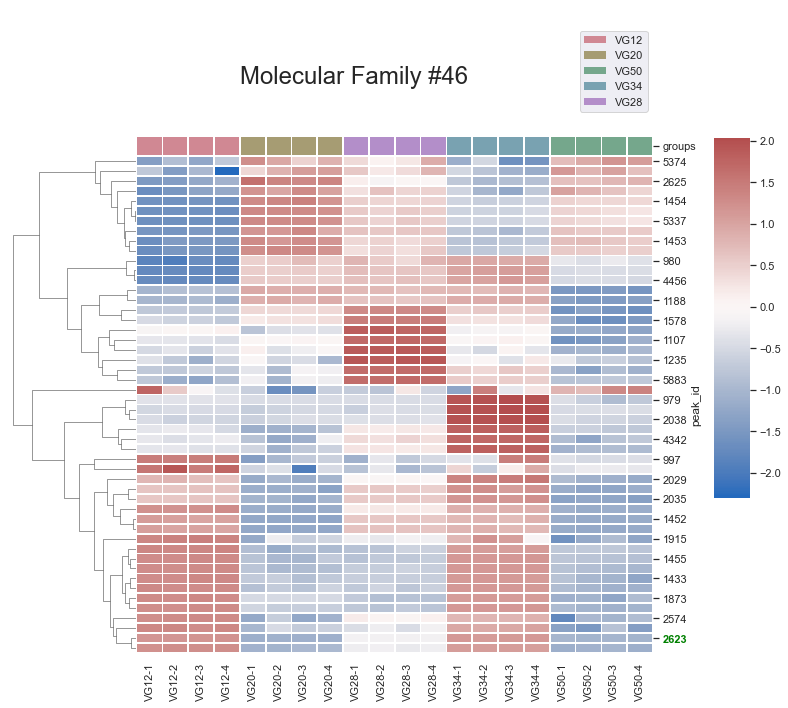

LibraryID  \
id                                                                  
764                                                           NaN   
815                                                           NaN   
979                                                           NaN   
980                                                           NaN   
993                      Spectral Match to Tryptamine from NIST14   
994                                                           NaN   
996        Spectral Match to 3-(2-Hydroxyethyl)indole from NIST14   
997                                                           NaN   
1001                                                          NaN   
1107                                                          NaN   
1108                                                          NaN   
1188                                                          NaN   
1235                                                          NaN   
1431                                                          NaN   
1433                                                          NaN   
1449                                                          NaN   
1452                                                          NaN   
1453                                                          NaN   
1454                                                          NaN   
1455                                                          NaN   
1578                                                          NaN   
1873                                                          NaN   
1889                                                          NaN   
1915                                                          NaN   
2029                                                          NaN   
2035                                                          NaN   
2038                                                          NaN   
2188                                                          NaN   
2574                                                          NaN   
2621  MLS001048999-01!1-methyl-3,4-dihydro-2H-pyrido[3,4-b]indole   
2623  MLS001048999-01!1-methyl-3,4-dihydro-2H-pyrido[3,4-b]indole   
2625                                                          NaN   
2716                                                          NaN   
2737                                                          NaN   
2763                                                          NaN   
2766                                                          NaN   
3419                                                          NaN   
3491                                                          NaN   
3539                                                          NaN   
4342                                                          NaN   
4456                                                          NaN   
4978                                                          NaN   
5302                                                          NaN   
5316                                                          NaN   
5330                                                          NaN   
5332                                                          NaN   
5337                                                          NaN   
5374                                                          NaN   
5883                                                          NaN   
7467                                                          NaN   

      Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                           
764        136.1112        3.364      157669.0          20   
815        138.0911        4.153       77589.0          20   
979        143.6275        7.023       19180.0          10   
980        143.6352        4.827       31920.0          20   
993        144.0789        7.229      759481.0          20   
994        144.0792        4.834 

Molecular Family #75


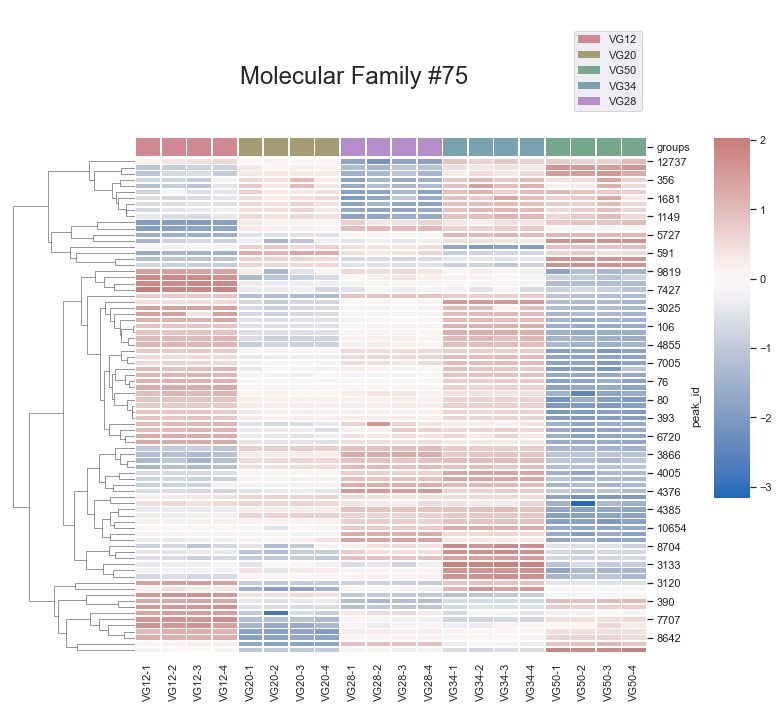

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                      
76          NaN       103.0541        1.502     1205060.0          20   
77          NaN       103.0541        1.962     3489214.0          20   
80          NaN       103.0543        1.565     1189100.0          20   
106         NaN       105.0696        2.752     9992740.0          20   
107         NaN       105.0699       11.520      447632.0          20   
...         ...            ...          ...           ...         ...   
11392       NaN       315.1694        6.731       41039.0          20   
11657       NaN       318.1478       11.998       96853.0          20   
12737       NaN       331.1635        1.948      872133.0          20   
17225       NaN       392.1801        1.960    46683357.0          20   
20680       NaN       446.2008        1.992      465663.0          20   

                                                                                                                                       link  
id                                                                                                                                           
76     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
77     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
80     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
106    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
107    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
...                                                                                                                                     ...  
11392  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11657  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12737  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
17225  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
20680  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  

[81 rows x 6 columns]

Molecular Family #508


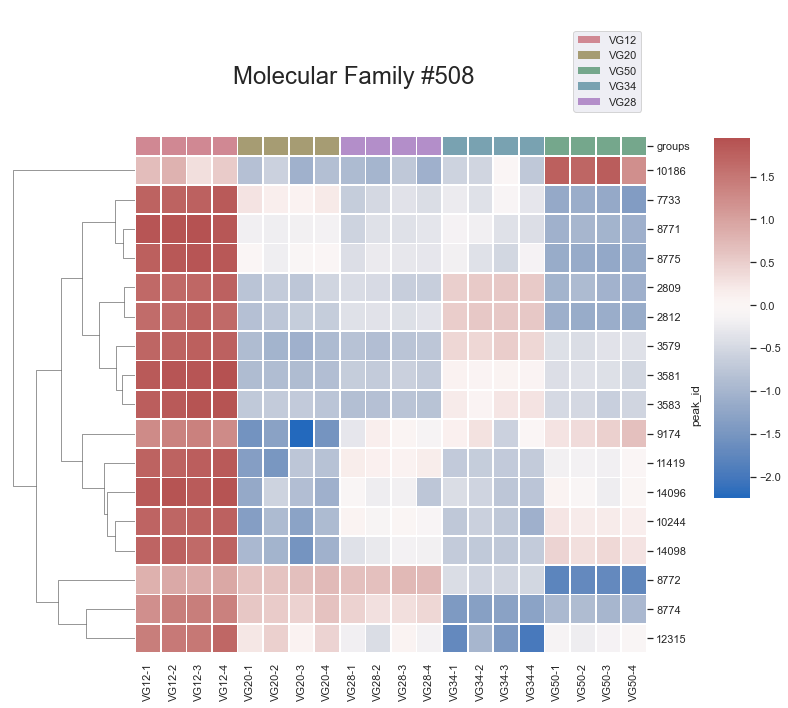

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
2809         NaN       188.1270        1.601      864002.0          20   
2812         NaN       188.1282        1.527      854658.0          20   
3579         NaN       202.1428        2.202     7324721.0          20   
3581         NaN       202.1434        1.987     3841569.0          20   
3583         NaN       202.1435        1.838     1447415.0          20   
7733         NaN       267.1702       10.472      167322.0          20   
8771         NaN       281.1846       13.799      277685.0          20   
8772         NaN       281.1856       13.988      834684.0          20   
8774         NaN       281.1864       14.640      520430.0          20   
8775         NaN       281.1866       15.108      182956.0          20   
9174         NaN       287.1939        3.965       88334.0          20   
10186        NaN       301.1389        5.175      222847.0          20   
10244        NaN       301.2116        6.498       71066.0          20   
11419        NaN       315.2270       11.303       52251.0          20   
12315        NaN       326.2440       13.958       29433.0          20   
14096        NaN       349.2114       11.405       51134.0          20   
14098        NaN       349.2125       11.841      112509.0          20   

                                                                                                                                        link  
id                                                                                                                                            
2809   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=508&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2812   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=508&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3579   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=508&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3581   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=508&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3583   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=508&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7733   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=508&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8771   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=508&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8772   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=508&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8774   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=508&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8775   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=508&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9174   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=508&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10186  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=508&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10244  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=508&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11419  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=508&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12315  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=508&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
14096  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=508&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
14098  https://gnps.ucsd.e

Molecular Family #805


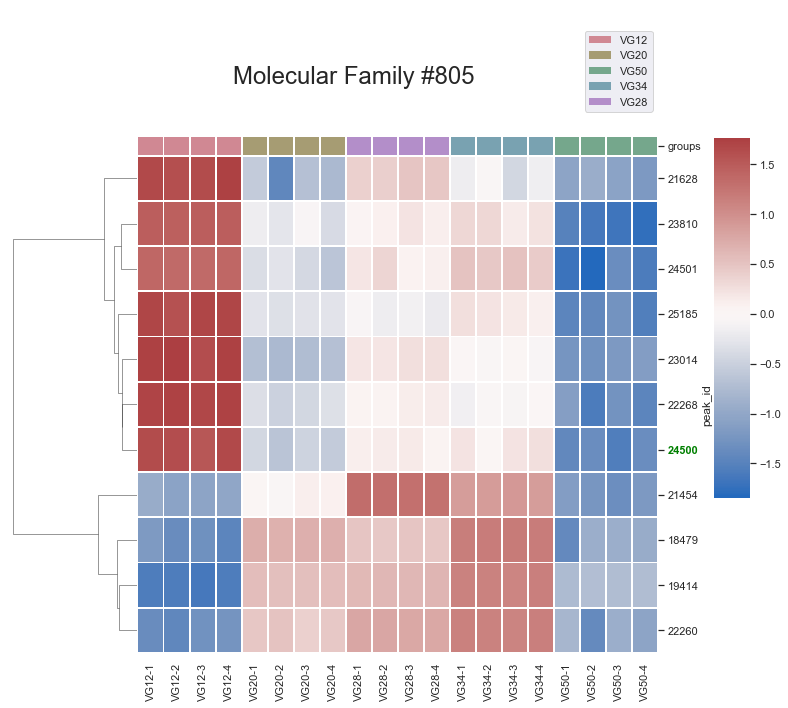

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                              
18479               NaN       411.2618        7.984     3451901.0          20   
19414               NaN       425.2745       10.719      726342.0          20   
21454               NaN       461.2726       12.798      120273.0          20   
21628               NaN       465.2701       12.511       40322.0          20   
22260               NaN       477.2683        9.573      113787.0          20   
22268               NaN       477.3084       19.631      139399.0          20   
23014               NaN       493.2994       15.898     1427779.0          20   
23810               NaN       511.2906       20.505       50064.0          20   
24500  NCGC00384828-01!       527.2852       16.911      253059.0          20   
24501               NaN       527.2881       18.048       29320.0          19   
25185               NaN       543.2792       14.081      169849.0          20   

                                                                                                                                        link  
id                                                                                                                                            
18479  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=805&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
19414  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=805&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
21454  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=805&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
21628  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=805&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
22260  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=805&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
22268  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=805&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
23014  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=805&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
23810  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=805&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
24500  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=805&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
24501  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=805&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
25185  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=805&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

Molecular Family #290


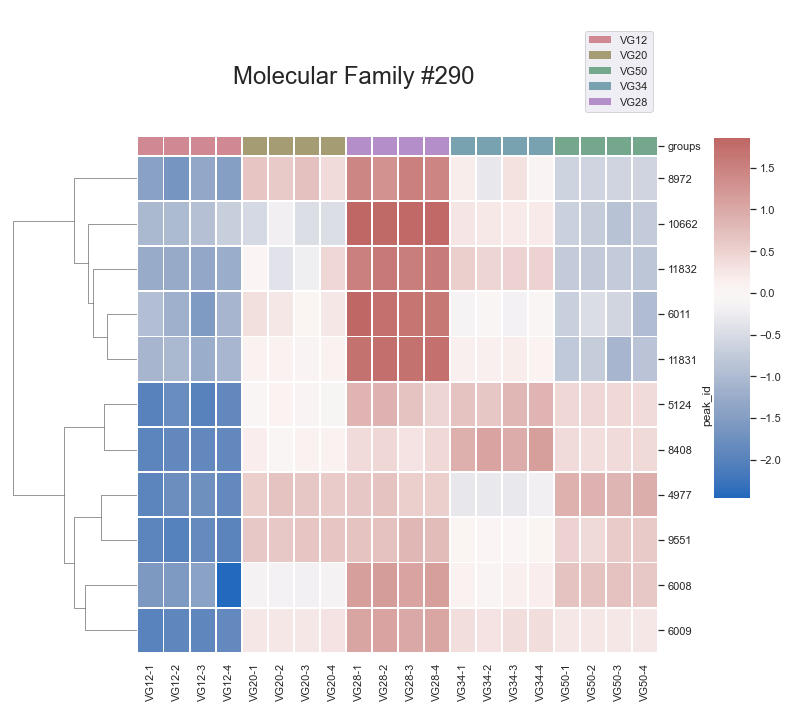

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
4977         NaN       226.1553        1.483     7331129.0          20   
5124         NaN       228.1714        1.594     1177726.0          20   
6008         NaN       242.1859        2.036     3731000.0          20   
6009         NaN       242.1860        2.158     3293822.0          20   
6011         NaN       242.1945        2.638       65638.0          20   
8408         NaN       276.1705        2.114     2946913.0          20   
8972         NaN       284.2345        2.439      146496.0          20   
9551         NaN       292.1644        1.556      912261.0          20   
10662        NaN       306.1799        1.977      215565.0          20   
11831        NaN       320.1971        3.673      258691.0          20   
11832        NaN       320.1971        3.401      355701.0          20   

                                                                                                                                        link  
id                                                                                                                                            
4977   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=290&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5124   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=290&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6008   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=290&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6009   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=290&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6011   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=290&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8408   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=290&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8972   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=290&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9551   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=290&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10662  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=290&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11831  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=290&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11832  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=290&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

Molecular Family #181


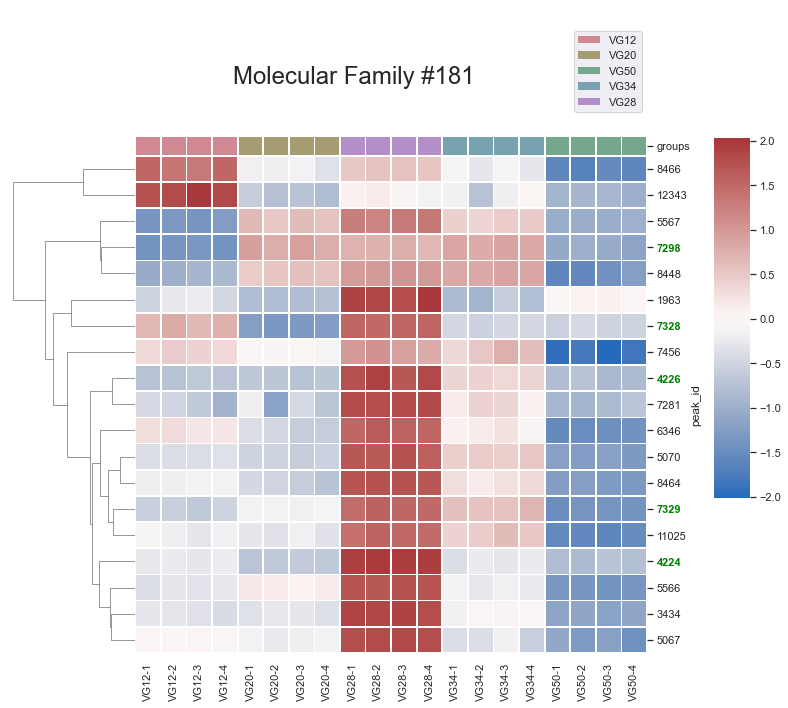

LibraryID  \
id                                                                                                           
1963                                                                                                   NaN   
3434                                                                                                   NaN   
4224                                                                 Spectral Match to Val-Leu from NIST14   
4226                                                                 Spectral Match to Val-Leu from NIST14   
5067                                                                                                   NaN   
5070                                                                                                   NaN   
5566                                                                                                   NaN   
5567                                                                                                   NaN   
6346                                                                                                   NaN   
7281                                                                                                   NaN   
7298   NCGC00384639-01_C14H16N2O3_Pyrrolo[1,2-a]pyrazine-1,4-dione, hexahydro-3-[(4-hydroxyphenyl)methyl]-   
7328                                                                                        cyclo(Phe-Leu)   
7329                                                                                        cyclo(Phe-Leu)   
7456                                                                                                   NaN   
8448                                                                                                   NaN   
8464                                                                                                   NaN   
8466                                                                                                   NaN   
11025                                                                                                  NaN   
12343                                                                                                  NaN   

       Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                            
1963        171.1131        2.576     3450801.0          20   
3434        199.1437        8.509     1455526.0          20   
4224        213.1595       11.830     1800387.0          20   
4226        213.1598       12.138     6538626.0          20   
5067        227.1753       12.762      171332.0          20   
5070        227.1756       14.711     4996633.0          20   
5566        235.1055        3.791      190496.0          20   
5567        235.1078        3.194     2291215.0          20   
6346        247.1446       13.381     5403305.0          20   
7281        261.0779       15.686       45129.0          20   
7298        261.1230        3.415    16510148.0          20   
7328        261.1600       15.646     4465653.0          20   
7329        261.1600       15.437     4179367.0          20   
7456        263.1388        6.016     4594190.0          20   
8448        277.1174        2.492      616855.0          20   
8464        277.1547        6.705     1798337.0          20   
8466        277.1552        9.085     3792107.0          20   
11025       311.1384       11.515     1645568.0          20   
12343       327.1328        3.554      789792.0          20   

                                                                                                                                        link  
id                                                                                                                                            
1963   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=181&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3434   https://gnps.ucsd.edu/Prot

Molecular Family #219


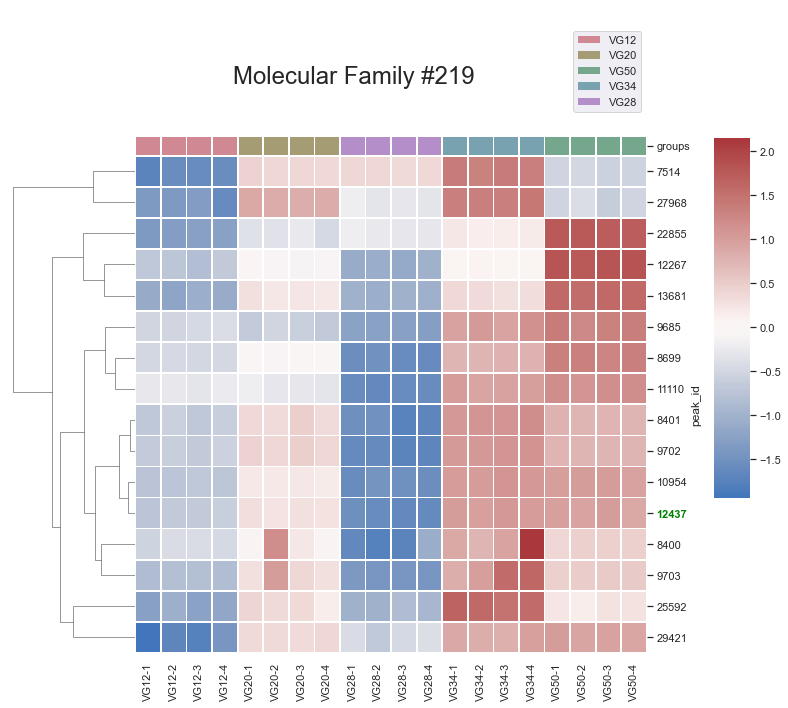

LibraryID  Precursor m/z  RTConsensus  \
id                                                                        
7514                                    NaN       264.1431        1.677   
8400                                    NaN       276.1435        1.496   
8401                                    NaN       276.1446        1.619   
8699                                    NaN       280.1393        1.358   
9685                                    NaN       294.0953        1.411   
9702                                    NaN       294.1539        1.623   
9703                                    NaN       294.1547        1.500   
10954                                   NaN       310.1288        1.865   
11110                                   NaN       312.1107        1.416   
12267                                   NaN       326.1234        1.412   
12437  N-(1-Deoxy-1-fructosyl)phenylalanine       328.1405        1.868   
13681                                   NaN       344.1345        1.415   
22855                                   NaN       490.1925        1.817   
25592                                   NaN       554.2342        1.950   
27968                                   NaN       625.2718        1.840   
29421                                   NaN       684.3121        1.882   

       PrecursorInt  no_spectra  \
id                                
7514      2705590.0          20   
8400      6144935.0          20   
8401     12612753.0          20   
8699      6984677.0          20   
9685      1101210.0          20   
9702     30817757.0          20   
9703     15923247.0          20   
10954     9870108.0          20   
11110     4064818.0          20   
12267     1304135.0          20   
12437    26187800.0          20   
13681     5022482.0          20   
22855      633161.0          20   
25592      547485.0          20   
27968      270306.0          20   
29421      291764.0          20   

                                                                                                                                        link  
id                                                                                                                                            
7514   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=219&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8400   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=219&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8401   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=219&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8699   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=219&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9685   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=219&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9702   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=219&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9703   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=219&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10954  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=219&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11110  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=219&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12267  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=219&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12437  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=219&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13681  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=219&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
22855  https://gnps.ucsd.edu/ProteoSAFe/result.jsp

Molecular Family #206


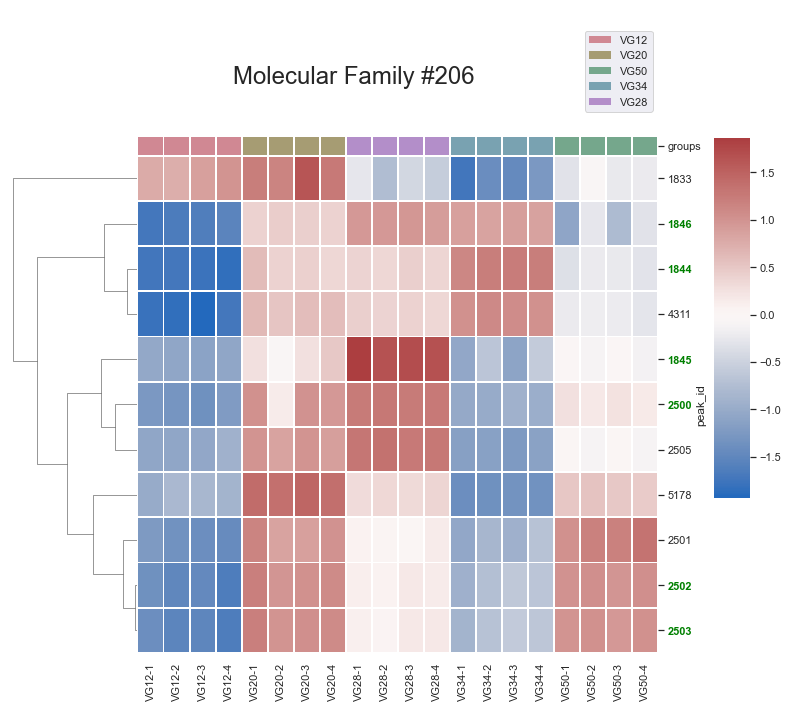

LibraryID  \
id                                                                
1833                                                        NaN   
1844                   Spectral Match to Norharmane from NIST14   
1845                   Spectral Match to Norharmane from NIST14   
1846                   Spectral Match to Norharmane from NIST14   
2500                      Spectral Match to Harmane from NIST14   
2501                                                        NaN   
2502  Massbank:PB005784 Harmane|1-methyl-9H-pyrido[3,4-b]indole   
2503  Massbank:PB005784 Harmane|1-methyl-9H-pyrido[3,4-b]indole   
2505                                                        NaN   
4311                                                        NaN   
5178                                                        NaN   

      Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                           
1833       169.0463        4.895      164066.0          20   
1844       169.0753        4.846     1026432.0          20   
1845       169.0756        6.903      977427.0          20   
1846       169.0758        6.747     2804538.0          20   
2500       183.0901        9.051     9132797.0          20   
2501       183.0903        5.562      598073.0          20   
2502       183.0904        6.835      646130.0          20   
2503       183.0904        6.782      646408.0          20   
2505       183.0917        8.957    10071656.0          20   
4311       215.0826        4.511      251697.0          20   
5178       229.0967        5.863     6848473.0          20   

                                                                                                                                       link  
id                                                                                                                                           
1833  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=206&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1844  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=206&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1845  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=206&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1846  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=206&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2500  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=206&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2501  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=206&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2502  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=206&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2503  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=206&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2505  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=206&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4311  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=206&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5178  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=206&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

Molecular Family #356


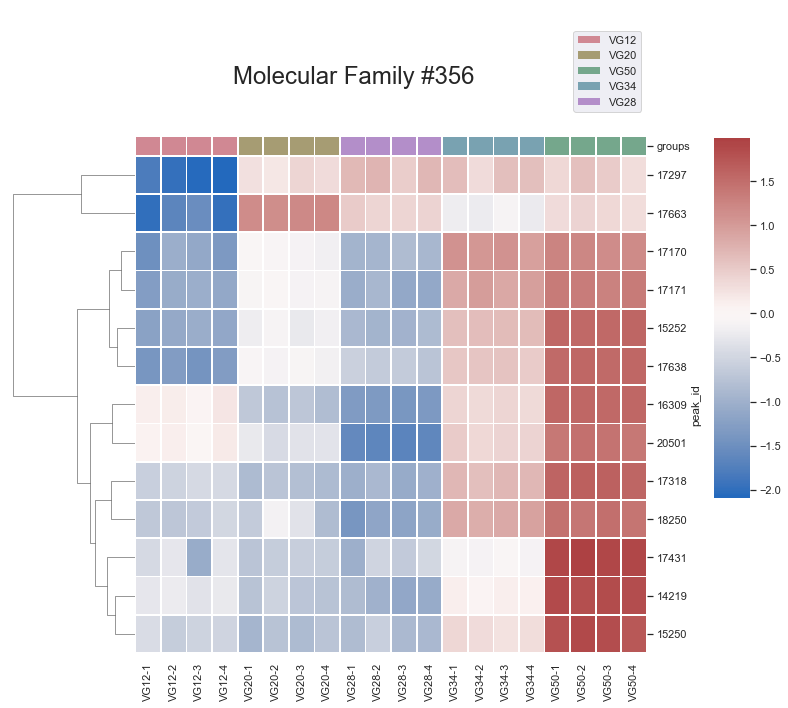

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
14219        NaN       351.1746        1.398      697671.0          20   
15250        NaN       365.1910        1.689      670403.0          20   
15252        NaN       365.1923        2.195      656339.0          20   
16309        NaN       379.2067        1.763      863315.0          20   
17170        NaN       391.2062        2.916      751618.0          20   
17171        NaN       391.2086        2.739      757729.0          20   
17297        NaN       393.1707        3.506      108549.0          20   
17318        NaN       393.2232        2.619      628193.0          20   
17431        NaN       395.2017        1.587      537997.0          20   
17638        NaN       399.1747        2.638      285616.0          20   
17663        NaN       399.2330        2.613      480845.0          20   
18250        NaN       407.2375        5.315       85881.0          20   
20501        NaN       443.2031        1.881      924017.0          20   

                                                                                                                                        link  
id                                                                                                                                            
14219  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=356&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
15250  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=356&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
15252  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=356&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
16309  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=356&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
17170  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=356&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
17171  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=356&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
17297  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=356&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
17318  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=356&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
17431  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=356&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
17638  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=356&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
17663  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=356&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
18250  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=356&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
20501  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=356&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

Molecular Family #139


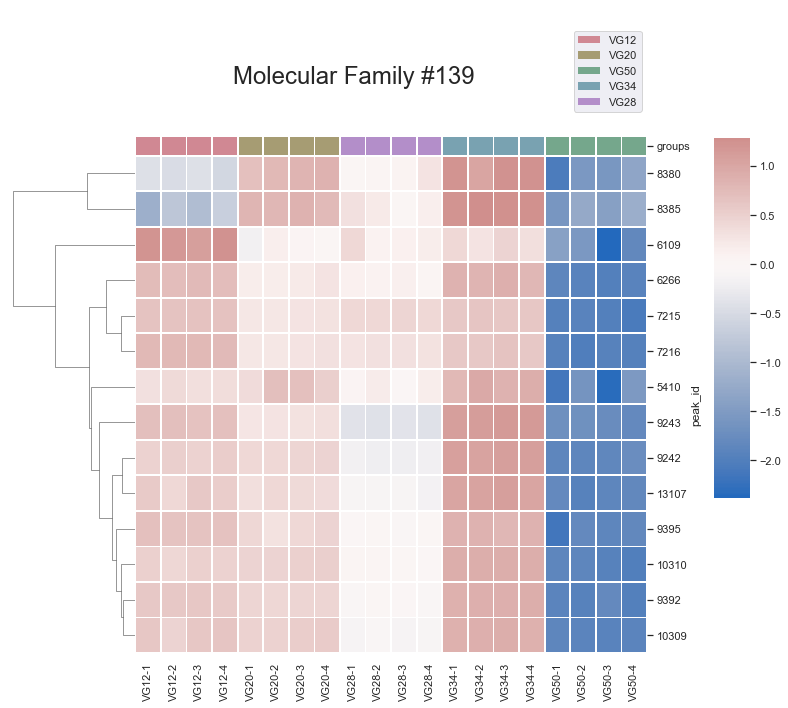

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
5410         NaN       232.1313       16.022       36591.0          20   
6109         NaN       244.0927       13.637       65188.0          20   
6266         NaN       246.1119       16.722      229476.0          20   
7215         NaN       260.1277       18.477      305554.0          20   
7216         NaN       260.1277       18.576      232025.0          20   
8380         NaN       276.1220       14.969       64975.0          20   
8385         NaN       276.1234       15.237       70074.0          20   
9242         NaN       288.1578       23.463      159511.0          20   
9243         NaN       288.1602       22.744      158782.0          20   
9392         NaN       290.1372       18.531      150217.0          20   
9395         NaN       290.1400       17.475      106440.0          20   
10309        NaN       302.1743       25.454      290116.0          20   
10310        NaN       302.1755       25.014      444076.0          20   
13107        NaN       336.1588       25.556      110309.0          20   

                                                                                                                                        link  
id                                                                                                                                            
5410   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=139&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6109   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=139&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6266   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=139&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7215   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=139&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7216   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=139&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8380   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=139&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8385   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=139&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9242   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=139&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9243   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=139&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9392   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=139&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9395   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=139&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10309  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=139&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10310  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=139&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13107  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=139&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

Molecular Family #90


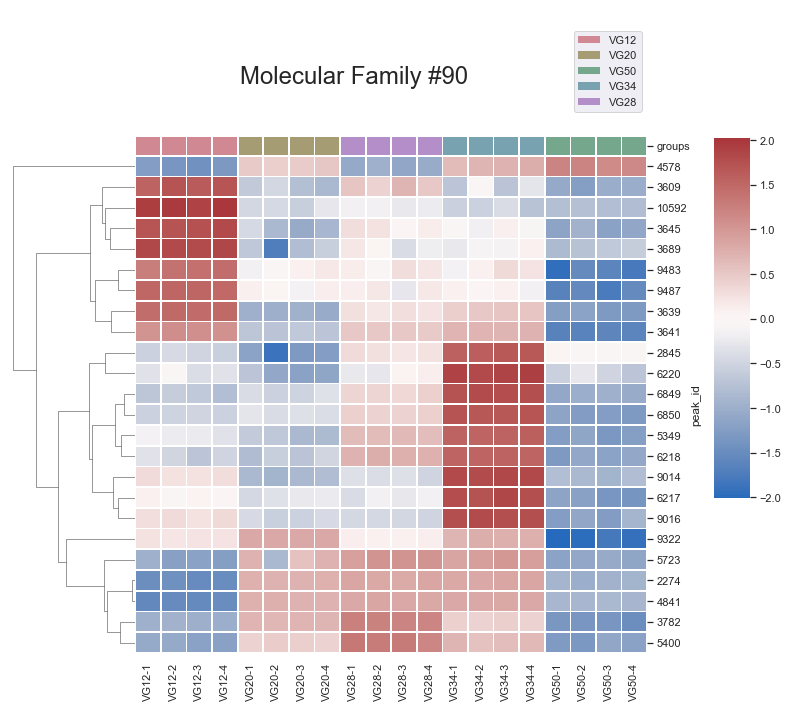

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
2274         NaN       178.0848        2.034     2017653.0          20   
2845         NaN       189.1009        2.218     1505334.0          20   
3609         NaN       203.0226        2.453       71550.0          20   
3639         NaN       203.1170        2.476     2353730.0          20   
3641         NaN       203.1170        3.031     5796377.0          20   
3645         NaN       203.1180        5.172       49913.0          20   
3689         NaN       204.1027       13.642       30220.0          20   
3782         NaN       206.0807        3.407     2230419.0          20   
4578         NaN       219.0768        1.739      833653.0          20   
4841         NaN       224.0907        2.030     8318838.0          20   
5349         NaN       231.1469        4.244       69885.0          20   
5400         NaN       232.0956       10.944      165601.0          20   
5723         NaN       238.1052        2.080      627817.0          20   
6217         NaN       245.1623       10.554       66366.0          20   
6218         NaN       245.1637        9.068      234702.0          20   
6220         NaN       245.1644        7.939       58466.0          20   
6849         NaN       255.1127        7.867      986500.0          20   
6850         NaN       255.1132        5.913     1188355.0          20   
9014         NaN       285.1225        4.068      336501.0          20   
9016         NaN       285.1238        4.473      485891.0          20   
9322         NaN       289.1528        7.916      522362.0          20   
9483         NaN       291.1691       11.235       52916.0          20   
9487         NaN       291.1725       11.425      115986.0          20   
10592        NaN       305.1855       13.712      169586.0          20   

                                                                                                                                       link  
id                                                                                                                                           
2274   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=90&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2845   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=90&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3609   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=90&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3639   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=90&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3641   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=90&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3645   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=90&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3689   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=90&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3782   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=90&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4578   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=90&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4841   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=90&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5349   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=90&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5400   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=90&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5723   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=90&ta

Molecular Family #58


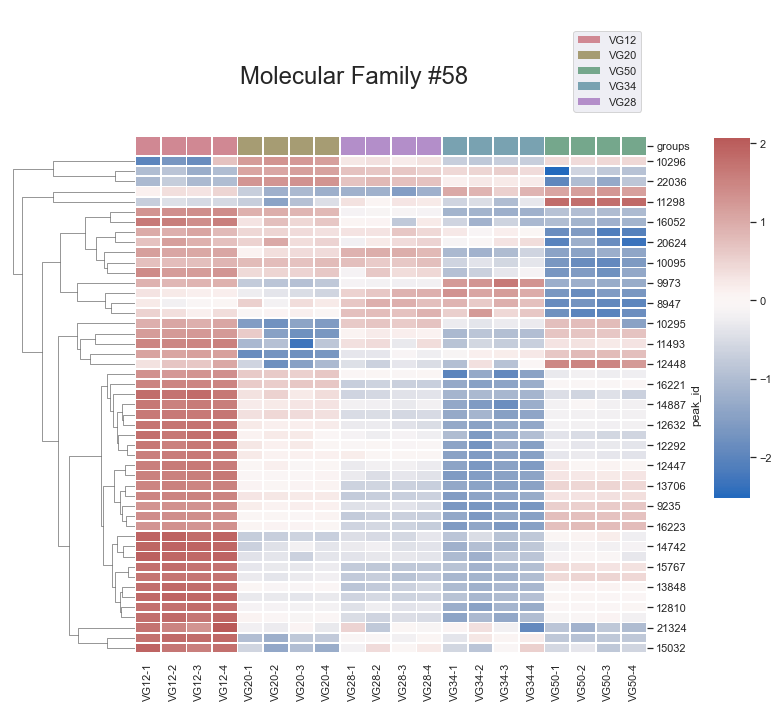

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
8217         NaN       274.1179        5.038      156787.0          20   
8947         NaN       284.1484       15.601       79358.0          20   
9077         NaN       286.1191       10.752       79511.0          20   
9235         NaN       288.1333        5.441      740400.0          20   
9237         NaN       288.1344        6.768      189026.0          20   
9973         NaN       298.1549       17.894       92481.0          20   
10095        NaN       300.1326       12.309       39947.0          20   
10295        NaN       302.1507        5.577      407031.0          20   
10296        NaN       302.1510        5.477      547726.0          20   
10971        NaN       310.1557       17.203      115481.0          20   
11135        NaN       312.1698       20.183      133508.0          20   
11298        NaN       314.1495       10.635       58543.0          20   
11493        NaN       316.1647       12.213       82263.0          20   
11655        NaN       318.1453        3.660      550027.0          20   
12292        NaN       326.1850       20.935       78821.0          20   
12447        NaN       328.1675       10.849      939899.0          20   
12448        NaN       328.1677       12.009       80562.0          20   
12628        NaN       330.1812       11.370      342132.0          20   
12632        NaN       330.1824       10.422      959131.0          20   
12810        NaN       332.1598        3.969      450518.0          20   
12811        NaN       332.1611        4.542      127258.0          20   
13531        NaN       342.1446       14.504       86084.0          20   
13705        NaN       344.1964       14.434      423088.0          20   
13706        NaN       344.1964       13.778     1763891.0          20   
13707        NaN       344.1965       12.932      448861.0          20   
13848        NaN       346.1388        4.730      217405.0          20   
13849        NaN       346.1404        4.112      653680.0          20   
13853        NaN       346.1748       12.277       68858.0          20   
14741        NaN       358.2125       17.467      180689.0          20   
14742        NaN       358.2128       17.855       68647.0          20   
14886        NaN       360.1544        4.985      857838.0          20   
14887        NaN       360.1551        5.966      179877.0          20   
14890        NaN       360.1692       20.163       79480.0          20   
14899        NaN       360.1924       12.836      130143.0          20   
15032        NaN       362.1559       11.470       49688.0          20   
15767        NaN       372.2282       19.637       51627.0          20   
15768        NaN       372.2288       19.270      150106.0          20   
15969        NaN       375.1660        4.386       80599.0          20   
16052        NaN       376.1658       14.667       39952.0          20   
16221        NaN       378.1802       15.151      379952.0          20   
16223        NaN       378.1814       15.674      107948.0          20   
16901        NaN       387.2025        9.349       55063.0          20   
17046        NaN       389.1846        5.409       38933.0          20   
17354        NaN       394.1761       10.818      177288.0          20   
19805        NaN       431.2258       10.395       54670.0          20   
20530        NaN       443.2616       16.475       37713.0          20   
20624        NaN       445.2068        9.249       95053.0          20   
21324        NaN       459.2233       11.393       64734.0          20   
22036        NaN       473.2417       15.368       27994.0          20   

                                                                                                                                       link  
id                                                                                        

Molecular Family #44


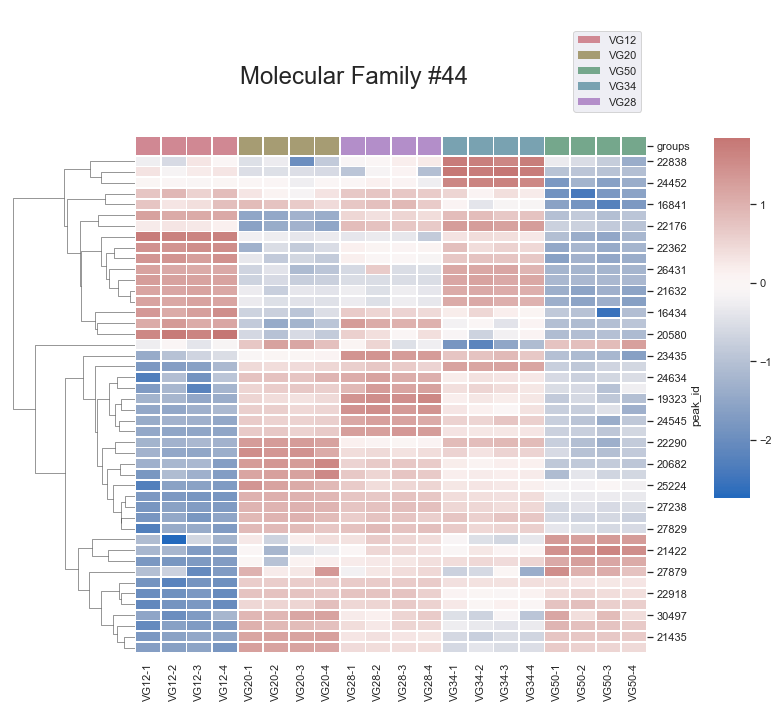

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
15604        NaN       370.1922        8.651       30328.0          20   
16434        NaN       381.1762        8.523       27382.0          20   
16841        NaN       386.2430        8.500       60035.0          20   
19323        NaN       424.1881        5.503      121188.0          20   
19682        NaN       429.2460        8.614       49619.0          20   
20580        NaN       444.2448        8.713       43447.0          20   
20682        NaN       446.2275        5.452      262672.0          20   
21422        NaN       461.1508        5.598       25382.0          20   
21435        NaN       461.2161        5.494      260983.0          20   
21436        NaN       461.2201        6.796      223531.0          20   
21632        NaN       465.2718        8.473      180477.0          20   
21634        NaN       465.2724        8.417      179091.0          20   
21636        NaN       465.2761        8.628      141869.0          20   
22175        NaN       475.2910        5.486       27857.0          20   
22176        NaN       475.2935        8.619      202959.0          20   
22290        NaN       478.2005        5.513      165193.0          20   
22362        NaN       479.2891       10.222       21824.0          20   
22838        NaN       489.3110        8.434       35134.0          20   
22918        NaN       491.2437        5.562      168248.0          20   
23435        NaN       502.2985        8.624       32582.0          20   
23724        NaN       509.2625        6.780       67000.0          20   
24123        NaN       518.3314        8.467       41655.0          16   
24452        NaN       526.3070        8.425       28501.0          20   
24520        NaN       527.3292        8.339       44961.0          20   
24545        NaN       528.2806        5.536       38025.0          20   
24592        NaN       529.2683        6.767       46595.0          20   
24634        NaN       530.2607        5.478       42218.0          20   
24650        NaN       530.3196        5.487       98627.0          20   
24765        NaN       533.2615        5.565       45882.0          20   
25224        NaN       544.2734        6.865       19609.0          20   
25284        NaN       546.2341        5.539       93942.0          20   
25411        NaN       549.2564        5.550       85939.0          20   
25466        NaN       551.1100        5.515       18148.0          20   
25628        NaN       555.2421        6.793      218362.0          20   
25759        NaN       557.4262        8.446       33020.0          13   
25780        NaN       558.2923        6.771      753376.0          20   
26325        NaN       574.2852        6.912       20521.0          20   
26431        NaN       577.4042        8.490       63727.0          17   
26843        NaN       590.2784        5.544       27328.0          20   
27207        NaN       601.2956        5.454       46904.0          20   
27238        NaN       602.2792        6.774      151296.0          20   
27829        NaN       620.2679        5.561       90519.0          20   
27879        NaN       621.3823        5.510       23194.0          20   
27896        NaN       622.2490        6.810       33045.0          20   
28518        NaN       645.3917        8.705       86823.0          20   
30497        NaN       735.2841        5.500       21054.0          20   

                                                                                                                                       link  
id                                                                                                                                           
15604  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=44&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
16434  https://gnps.ucsd.edu

Molecular Family #161


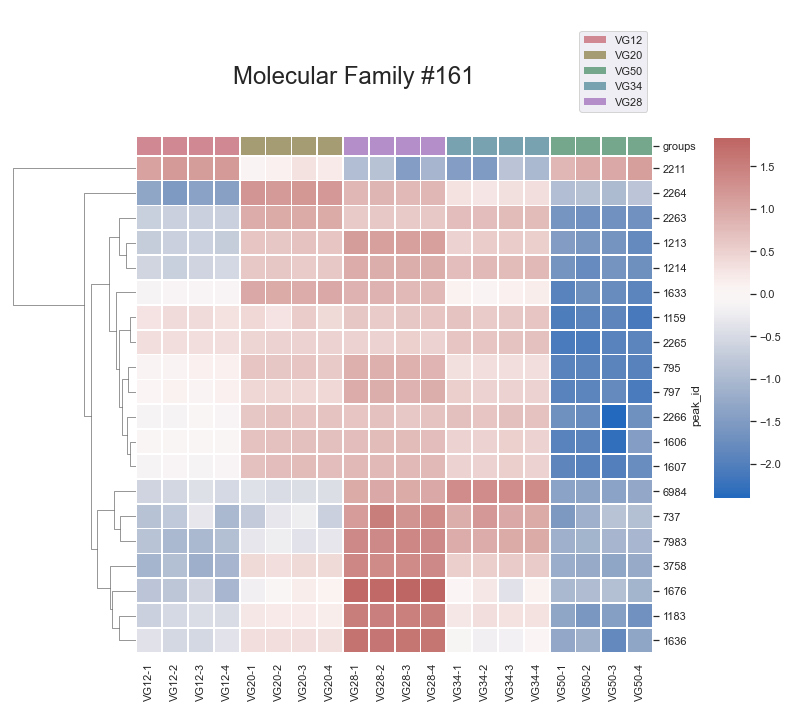

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                      
737         NaN       135.0925        1.344       84756.0          20   
795         NaN       137.1063        3.750     8663688.0          20   
797         NaN       137.1068        1.805     1451359.0          20   
1159        NaN       149.1069        1.379     3395528.0          20   
1183        NaN       150.0899        1.655     1065705.0          20   
1213        NaN       151.1225        2.298     1294072.0          20   
1214        NaN       151.1230        8.385      257296.0          20   
1606        NaN       163.1222        1.497     1589088.0          20   
1607        NaN       163.1225        1.573     1587834.0          20   
1633        NaN       164.1061        1.909      548861.0          20   
1636        NaN       164.1071        2.645      168173.0          20   
1676        NaN       165.1369        4.889       52766.0          20   
2211        NaN       177.0113        2.947      148470.0          20   
2263        NaN       177.1379        2.974     3878700.0          20   
2264        NaN       177.1379        2.442     1540215.0          20   
2265        NaN       177.1380        2.086      828799.0          20   
2266        NaN       177.1387        1.811      373668.0          20   
3758        NaN       205.1681        8.280      127570.0          20   
6984        NaN       257.1268        3.267      655580.0          20   
7983        NaN       271.1454        5.222      237875.0          20   

                                                                                                                                       link  
id                                                                                                                                           
737   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=161&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
795   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=161&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
797   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=161&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1159  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=161&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1183  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=161&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1213  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=161&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1214  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=161&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1606  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=161&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1607  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=161&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1633  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=161&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1636  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=161&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1676  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=161&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2211  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=161&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2263  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=161&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2264  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=161&task=30a1f92e87a047b58ee8c0faf2b473

Molecular Family #123


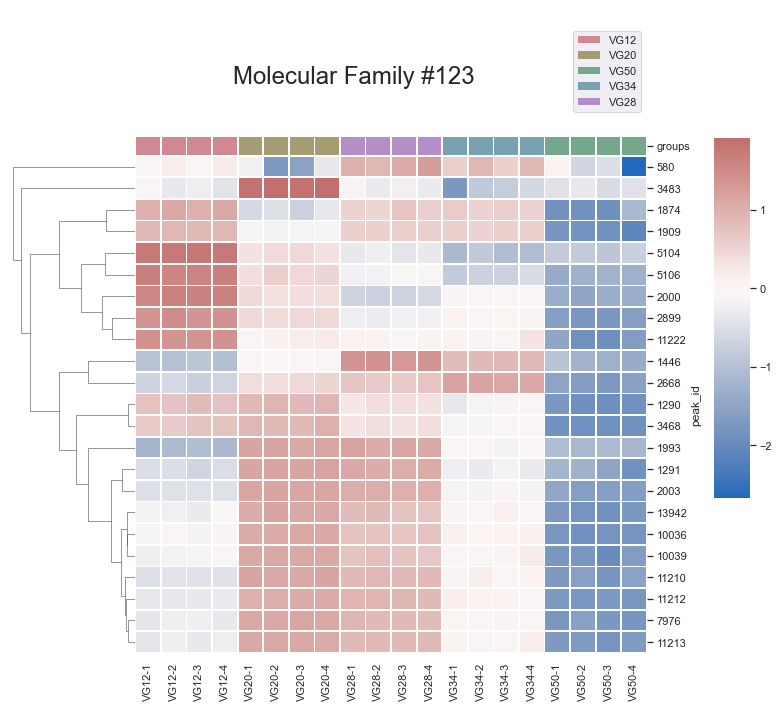

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
580          NaN       129.9802        1.220       26860.0          20   
1290         NaN       154.0854        2.177      706607.0          20   
1291         NaN       154.0854        4.097      175351.0          20   
1446         NaN       158.0822        2.415      205600.0          20   
1874         NaN       169.5817        5.416       20470.0          20   
1909         NaN       170.1178        5.409     2521704.0          20   
1993         NaN       172.0898        4.895      227368.0          20   
2000         NaN       172.0962        1.408     4138622.0          20   
2003         NaN       172.0965        4.097     1890272.0          20   
2668         NaN       186.0742        1.708      642337.0          20   
2899         NaN       190.1078        1.409     1197299.0          20   
3468         NaN       200.0921        2.173    13847222.0          20   
3483         NaN       200.1266       12.310      177540.0          20   
5104         NaN       228.1216       10.852      429634.0          20   
5106         NaN       228.1224       10.329      308007.0          20   
7976         NaN       271.1286        2.620      371456.0          20   
10036        NaN       299.1578        9.075      470014.0          20   
10039        NaN       299.1599        8.583      275200.0          20   
11210        NaN       313.1744       12.265      232749.0          20   
11212        NaN       313.1758       12.550      384344.0          20   
11213        NaN       313.1762       11.927      187473.0          20   
11222        NaN       313.2084       12.279       66346.0          20   
13942        NaN       347.1581       13.185       84619.0          20   

                                                                                                                                        link  
id                                                                                                                                            
580    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=123&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1290   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=123&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1291   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=123&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1446   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=123&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1874   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=123&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1909   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=123&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1993   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=123&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2000   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=123&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2003   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=123&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2668   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=123&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2899   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=123&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3468   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=123&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3483   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=123&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5104   http

Molecular Family #450


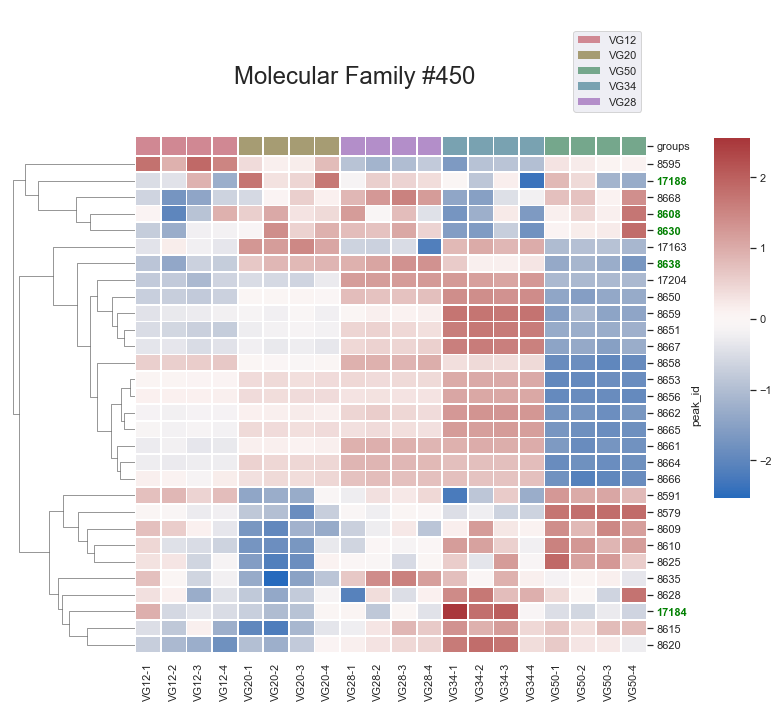

LibraryID  Precursor m/z  \
id                                                                      
8579                                               NaN       279.0189   
8591                                               NaN       279.0922   
8595                                               NaN       279.0939   
8608                                   MoNA:936698 DBP       279.1574   
8609                                               NaN       279.1576   
8610                                               NaN       279.1576   
8615                                               NaN       279.1579   
8620                                               NaN       279.1584   
8625                                               NaN       279.1586   
8628                                               NaN       279.1596   
8630                                 Dibutyl phthalate       279.1599   
8635                                               NaN       279.1604   
8638   Spectral Match to Dibutyl phthalate from NIST14       279.1676   
8650                                               NaN       279.2299   
8651                                               NaN       279.2300   
8653                                               NaN       279.2305   
8656                                               NaN       279.2310   
8658                                               NaN       279.2316   
8659                                               NaN       279.2319   
8661                                               NaN       279.2320   
8662                                               NaN       279.2321   
8664                                               NaN       279.2325   
8665                                               NaN       279.2330   
8666                                               NaN       279.2336   
8667                                               NaN       279.2350   
8668                                               NaN       279.2352   
17163                                              NaN       391.1931   
17184  Spectral Match to Dioctyl phthalate from NIST14       391.2839   
17188  Spectral Match to Dioctyl phthalate from NIST14       391.2856   
17204                                              NaN       391.6622   

       RTConsensus  PrecursorInt  no_spectra  \
id                                             
8579        10.923       12144.0          17   
8591        10.922       81188.0          20   
8595         6.436      200462.0          20   
8608        30.914     5446531.0          20   
8609         5.826      412366.0          20   
8610         8.851      434729.0          20   
8615         6.222      416269.0          20   
8620        22.630      494769.0          20   
8625         5.400      380373.0          20   
8628         5.705      397379.0          20   
8630        31.032     7053197.0          20   
8635        13.357      526200.0          20   
8638        14.320      684136.0          20   
8650        23.902       36037.0          20   
8651        22.792       37080.0          20   
8653        20.689      525160.0          20   
8656        21.696     1866831.0          20   
8658        27.582       93931.0          20   
8659        23.369       37722.0          20   
8661        26.327       40479.0          20   
8662        24.640       40221.0          20   
8664        27.106      407767.0          20   
8665        25.671       62858.0          20   
8666        27.423       44750.0          20   
8667        22.595       58217.0          20   
8668        28.473       17963.0          20   
17163        5.177      147101.0          20   
17184       34.744      329470.0          20   
17188       35.963     9006113.0          20   
17204       18.346        9940.0          15   

                                                                                                                                        link  
id                          

Molecular Family #703


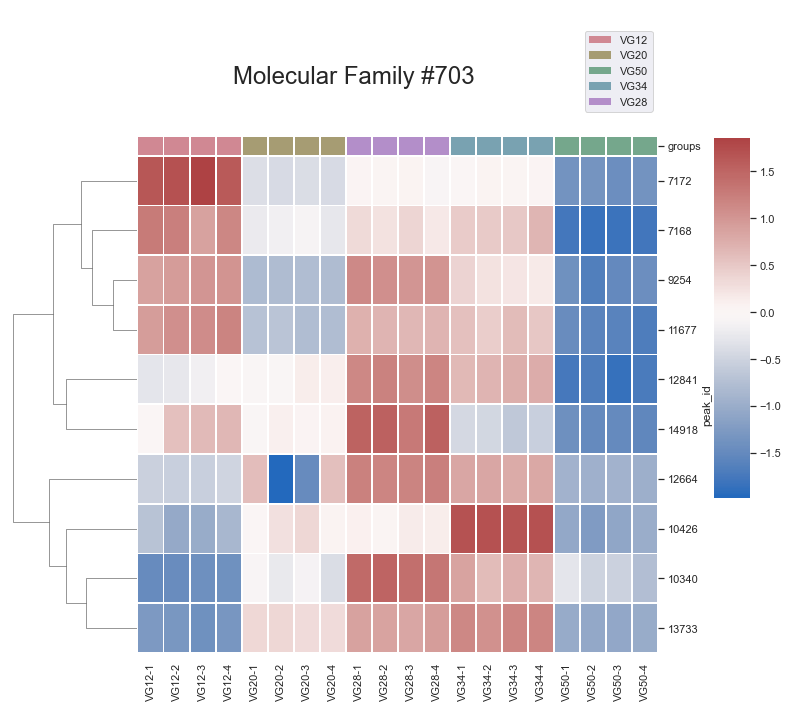

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
7168         NaN       259.2022       13.247     7855383.0          20   
7172         NaN       259.2026       12.747     5013948.0          20   
9254         NaN       288.1928        1.902     2478268.0          20   
10340        NaN       302.2084        2.402     9664787.0          20   
10426        NaN       303.1907        8.417      205793.0          20   
11677        NaN       318.2004        1.735     2175755.0          20   
12664        NaN       330.2379        6.984     2761708.0          20   
12841        NaN       332.2174        2.170     4519028.0          20   
13733        NaN       344.2549       11.438     7001336.0          20   
14918        NaN       360.2127        2.054     3434021.0          20   

                                                                                                                                        link  
id                                                                                                                                            
7168   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=703&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7172   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=703&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9254   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=703&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10340  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=703&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10426  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=703&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11677  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=703&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12664  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=703&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12841  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=703&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13733  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=703&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
14918  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=703&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

Molecular Family #24


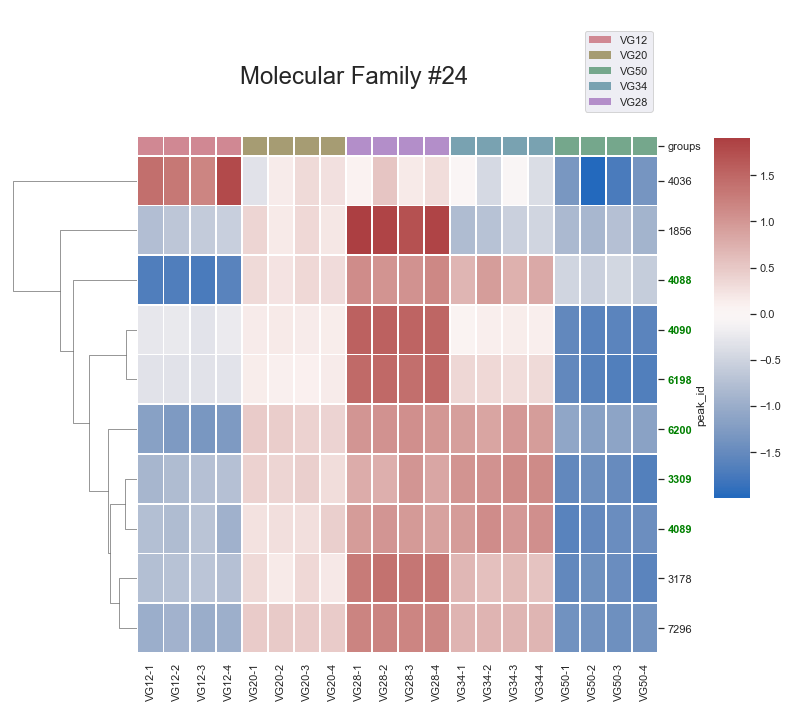

LibraryID  \
id                                                                                                
1856                                                                                        NaN   
3178                                                                                        NaN   
3309                                                                         cyclo(L-Val-L-Pro)   
4036                                                                                        NaN   
4088  NCGC00169428-02!3-(2-methylpropyl)-2,3,6,7,8,8a-hexahydropyrrolo[1,2-a]pyrazine-1,4-dione   
4089  NCGC00169428-02!3-(2-methylpropyl)-2,3,6,7,8,8a-hexahydropyrrolo[1,2-a]pyrazine-1,4-dione   
4090  NCGC00169428-02!3-(2-methylpropyl)-2,3,6,7,8,8a-hexahydropyrrolo[1,2-a]pyrazine-1,4-dione   
6198                                                                         cyclo(L-Phe-D-Pro)   
6200                                                                         cyclo(L-Phe-D-Pro)   
7296                                                                                        NaN   

      Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                           
1856       169.0963        1.863     4274151.0          20   
3178       195.1126        2.386     7706030.0          20   
3309       197.1283        3.864    36942819.0          20   
4036       211.0339        8.988      100921.0          20   
4088       211.1435        8.944    47332366.0          20   
4089       211.1435        7.866    44023153.0          20   
4090       211.1441        8.581     4054127.0          20   
6198       245.1273       10.073     5431707.0          20   
6200       245.1276       10.849    55782495.0          20   
7296       261.1223       10.125      951053.0          20   

                                                                                                                                      link  
id                                                                                                                                          
1856  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=24&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3178  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=24&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3309  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=24&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4036  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=24&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4088  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=24&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4089  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=24&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4090  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=24&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6198  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=24&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6200  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=24&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7296  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=24&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

Molecular Family #197


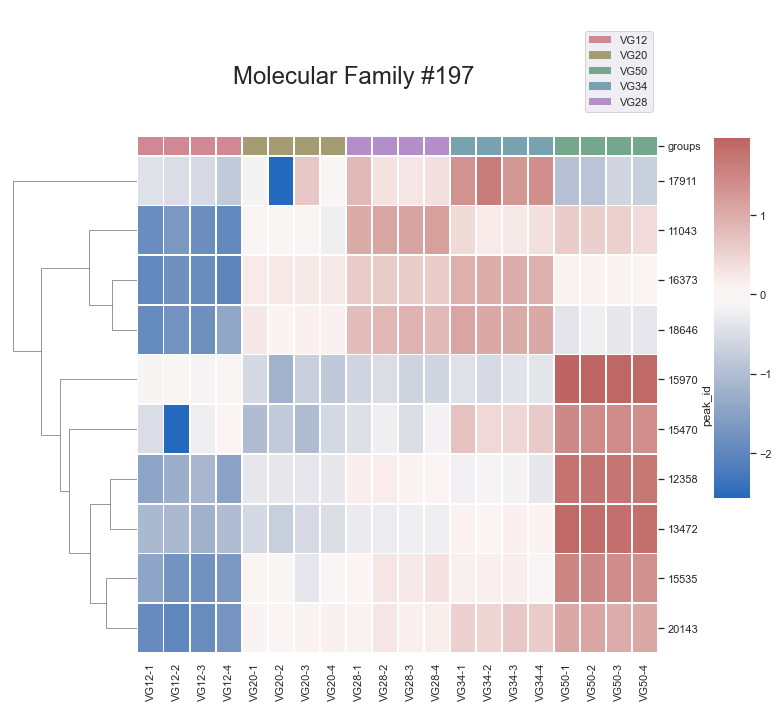

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
11043        NaN       311.1714        3.785      101716.0          20   
12358        NaN       327.1655        2.051      253369.0          20   
13472        NaN       341.1812        4.119      590443.0          20   
15470        NaN       368.2262        2.520       83298.0          20   
15535        NaN       369.2123       12.074       36262.0          20   
15970        NaN       375.1668        5.135      127461.0          20   
16373        NaN       380.1926        4.158      343839.0          20   
17911        NaN       402.2133        3.472       80308.0          20   
18646        NaN       414.1781        5.287       70514.0          20   
20143        NaN       437.2130        3.631      132957.0          20   

                                                                                                                                        link  
id                                                                                                                                            
11043  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=197&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12358  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=197&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13472  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=197&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
15470  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=197&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
15535  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=197&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
15970  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=197&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
16373  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=197&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
17911  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=197&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
18646  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=197&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
20143  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=197&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

In [21]:
for idx, row in df.iterrows():
    members = gnps_ds.dataset_pathways_to_row_ids[idx]
    if len(members) < min_members:
        continue
        
    pw_name = row['pw_name']
    p_value = row[p_value_col]
    print(pw_name)
    
    # plotting for manuscript
#     to_plot = ['Molecular Family #148']
#     if pw_name not in to_plot:
#         continue
#     else:
#         print(row)
                
    # get group intensities
    group_intensities = intensities_df.loc[members][all_samples]    
    
    # get group info
    # print('%s p-value=%.4f' % (pw_name, p_value))
    data = []
    for member in members:
        member_info = entity_dict[member]
        unique_id = member_info['unique_id']
        library_id = member_info['LibraryID']
        gnps_linkout_network = member_info['GNPSLinkout_Network']
        no_spectra = member_info['number of spectra']
        rt = member_info['RT']
        mz = member_info['mass']    
        intensity = member_info['SumPeakIntensity']
        row = [unique_id, library_id, mz, rt, intensity, no_spectra, gnps_linkout_network]
        data.append(row)
    member_df = pd.DataFrame(data, columns=['id', 'LibraryID', 'Precursor m/z', 'RTConsensus', 'PrecursorInt', 'no_spectra', 'link']).set_index('id')    
    
    # Create a categorical palette to identify the networks
    used_groups = list(set(all_groups))
    group_pal = sns.husl_palette(len(used_groups), s=.45)
    group_lut = dict(zip(map(str, used_groups), group_pal))

    # Convert the palette to vectors that will be drawn on the side of the matrix
    group_colours = pd.Series(all_groups, index=group_intensities.columns).map(group_lut)    
    group_colours.name = 'groups'
    
    # plot heatmap
    g = sns.clustermap(group_intensities, center=0, cmap=cmap, col_colors=group_colours, 
                   col_cluster=False, linewidths=0.75, figsize=(10, 10), cbar_pos=(1.0, 0.3, 0.05, 0.5))
    
    title = pw_name
    if pw_name == 'Molecular Family #127':
        title = 'Cinnamic Acid-related Molecular Family'
    elif pw_name == 'Molecular Family #148':
        title = 'Steroid-related Molecular Family'
    plt.suptitle('%s' % (title), fontsize=24, y=0.9)

    # draw group legend
    for group in used_groups:
        g.ax_col_dendrogram.bar(0, 0, color=group_lut[group], label=group, linewidth=0)
    g.ax_col_dendrogram.legend(loc="right")
    
    # make the annotated peaks to have labels in bold
    annotated_df = member_df[member_df['LibraryID'].notnull()]
    annotated_peaks = annotated_df.index.values
    for label in g.ax_heatmap.get_yticklabels():
        if label.get_text() in annotated_peaks:
            label.set_weight("bold")
            label.set_color("green")   
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)        

    out_file = '%s.pdf' % pw_name
    plt.savefig(out_file, dpi=300)
    plt.show()
    
    out_file = '%s.csv' % pw_name
    display(member_df)
    member_df.drop('link', axis=1).round(4).to_csv(out_file, index=True)

## GNPS-MS2LDA Analysis

Similar to above, but here we provide a link to GNPS-MS2LDA analysis to retrieve Mass2Motifs, and pass it to the loader.

In [22]:
gnps_ms2lda_url = 'https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=6f14abfe0c5f4b3aa206a55c50d2d99e'

In [23]:
database_name = DATABASE_GNPS_MS2LDA
loader = GNPSLoader(database_name, gnps_url, metadata_df, comparisons, gnps_ms2lda_url=gnps_ms2lda_url)
database = loader.load_data()

2021-01-07 17:12:19.944 | INFO     | pals.loader:load_data:166 - Retrieving clustering and quantification information from GNPS
2021-01-07 17:12:19.945 | DEBUG    | pals.loader:load_data:167 - https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=30a1f92e87a047b58ee8c0faf2b4734e
2021-01-07 17:12:19.945 | INFO     | pals.loader:_download_gnps:374 - Found GNPS task 30a1f92e87a047b58ee8c0faf2b4734e
29.6MiB [00:15, 3.38MiB/s]2021-01-07 17:12:36.019 | DEBUG    | pals.loader:_parse_gnps_molfam:429 - 	DB_result/1e482cc10bc64b9992b6351988b67e75.tsv
2021-01-07 17:12:36.020 | DEBUG    | pals.loader:_parse_gnps_molfam:429 - 	FEATURE-BASED-MOLECULAR-NETWORKING-30a1f92e-download_cytoscape_data-main.graphml
2021-01-07 17:12:36.020 | DEBUG    | pals.loader:_parse_gnps_molfam:429 - 	clusterinfo_summary/de5bea43ecef4445a886f881fec19b49.tsv
2021-01-07 17:12:36.021 | DEBUG    | pals.loader:_parse_gnps_molfam:433 - Found cluster info: clusterinfo_summary/de5bea43ecef4445a886f881fec19b49.tsv
2021-01-07 17:12:36

In [24]:
measurement_df = database.extra_data['measurement_df']
annotation_df = database.extra_data['annotation_df']
experimental_design = database.extra_data['experimental_design']
gnps_ds = DataSource(measurement_df, annotation_df, experimental_design, None, database=database, min_replace=SMALL)

2021-01-07 17:12:40.550 | DEBUG    | pals.feature_extraction:__init__:48 - Using user-provided database
2021-01-07 17:12:40.550 | DEBUG    | pals.feature_extraction:__init__:56 - Mapping pathway to unique ids
2021-01-07 17:12:40.556 | DEBUG    | pals.feature_extraction:__init__:70 - Creating dataset to pathway mapping
2021-01-07 17:12:40.762 | DEBUG    | pals.feature_extraction:__init__:98 - Computing unique id counts


In [25]:
plage = PLAGE(gnps_ds)
pathway_df = plage.get_results()

2021-01-07 17:12:40.875 | DEBUG    | pals.PLAGE:__init__:29 - PLAGE initialised
2021-01-07 17:12:41.351 | DEBUG    | pals.preprocessing:process:20 - Performing min-value imputation
2021-01-07 17:12:41.387 | DEBUG    | pals.preprocessing:process:36 - Performing row average imputation
2021-01-07 17:12:41.424 | DEBUG    | pals.preprocessing:process:46 - Applying log normalisation
2021-01-07 17:12:41.429 | DEBUG    | pals.preprocessing:process:53 - Scaling the data across the sample: zero mean and unit variance
2021-01-07 17:12:41.937 | DEBUG    | pals.PLAGE:get_plage_activity_df:84 - Mean values of the rows in the DF is [-0. -0.  0. ... -0. -0.  0.]
2021-01-07 17:12:41.938 | DEBUG    | pals.PLAGE:get_plage_activity_df:85 - Variance in the rows of the DF is [1. 1. 1. ... 1. 1. 1.]
2021-01-07 17:12:42.044 | DEBUG    | pals.PLAGE:set_up_resample_plage_p_df:96 - Calculating plage p-values with resampling
2021-01-07 17:12:42.045 | DEBUG    | pals.PLAGE:set_up_resample_plage_p_df:103 - Comparis

In [26]:
p_value_col = '%s p-value' % comp_name
count_col = 'unq_pw_F'
pathway_df.sort_values([p_value_col, count_col], ascending=[True, False], inplace=True)
pathway_df

pw_name  \
motif_458                                                                                                                                                               motif_458   
mb_motif_4.m2m           mb_motif_4.m2m [Loss of methyl group – indicative for presence of methoxy [O-CH3] methylsulfyl [S-CH3] or methylgroup connected to aromatic ring system]   
motif_556                                                                                                                                                               motif_556   
gnps_motif_170.m2m                                                                                                    gnps_motif_170.m2m [methoxy-methylaminophenyl substructure]   
urine_mass2motif_38.m2m                                                                 urine_mass2motif_38.m2m [methylethylimidazole substructure (i.e. from 3-methylhistamine)]   
...                                                                                                                                                                           ...   
motif_573                                                                                                                                                               motif_573   
mb_motif_195.m2m                                                                                        mb_motif_195.m2m [Loss indicative for presence of amide functional group]   
motif_671                                                                                                                                                               motif_671   
urine_mass2motif_32.m2m                                                          urine_mass2motif_32.m2m [CH3ON loss - [loss ppm out of normal range - feature selection issue?]]   
urine_mass2motif_1.m2m                                            urine_mass2motif_1.m2m [62.98196 fragment - unsure what it represents but present across several fragm spectra]   

                         VG12/VG50 p-value  unq_pw_F  tot_ds_F  F_coverage  \
motif_458                         0.000021         4         3       75.00   
mb_motif_4.m2m                    0.000032        27        19       70.37   
motif_556                         0.000034        64        30       46.88   
gnps_motif_170.m2m                0.000044        33        17       51.52   
urine_mass2motif_38.m2m           0.000053        25        12       48.00   
...                                    ...       ...       ...         ...   
motif_573                         1.000000        47        14       29.79   
mb_motif_195.m2m                  1.000000        12         4       33.33   
motif_671                         1.000000         3         2       66.67   
urine_mass2motif_32.m2m           1.000000         2         1       50.00   
urine_mass2motif_1.m2m            1.000000         2         1       50.00   

                               sf  exp_F  Ex_Cov  VG12/VG50 comb_p  
motif_458                0.114029   1.35   33.75          0.000021  
mb_motif_4.m2m           0.000104   9.09   33.67          0.000032  
motif_556                0.018924  21.55   33.67          0.000034  
gnps_motif_170.m2m       0.025618  11.11   33.67          0.000044  
urine_mass2motif_38.m2m  0.097549   8.42   33.68          0.000053  
...                           ...    ...     ...               ...  
motif_573                0.761409  15.82   33.66          1.000000  
mb_motif_195.m2m         0.616562   4.04   33.67          1.000000  
motif_671                0.263681   1.01   33.67          1.000000  
urine_mass2motif_32.m2m  0.560022   0.67   33.50          1.000000  
urine_mass2motif_1.m2m   0.560022   0.67   33.50          1.000000  

[196 rows x 9 columns]

In [27]:
df = pathway_df[pathway_df[p_value_col] < 0.05]
df

pw_name  \
motif_458                                                                                                                                                                motif_458   
mb_motif_4.m2m            mb_motif_4.m2m [Loss of methyl group – indicative for presence of methoxy [O-CH3] methylsulfyl [S-CH3] or methylgroup connected to aromatic ring system]   
motif_556                                                                                                                                                                motif_556   
gnps_motif_170.m2m                                                                                                     gnps_motif_170.m2m [methoxy-methylaminophenyl substructure]   
urine_mass2motif_38.m2m                                                                  urine_mass2motif_38.m2m [methylethylimidazole substructure (i.e. from 3-methylhistamine)]   
...                                                                                                                                                                            ...   
urine_mass2motif_237.m2m                                                                                                        urine_mass2motif_237.m2m [Proline betaine related]   
gnps_motif_49.m2m                                                                    gnps_motif_49.m2m [Loss possibly indicative of carboxylic acid group with 1-carbon attached.]   
urine_mass2motif_241.m2m                                                  urine_mass2motif_241.m2m [Loss of [hexose-H2O] – indication of hexose conjugation (for example glucose)]   
motif_478                                                                                                                                                                motif_478   
gnps_motif_54.m2m                                                                           gnps_motif_54.m2m [Fragments indicative for ferulic acid based substructure (MzCloud)]   

                          VG12/VG50 p-value  unq_pw_F  tot_ds_F  F_coverage  \
motif_458                          0.000021         4         3       75.00   
mb_motif_4.m2m                     0.000032        27        19       70.37   
motif_556                          0.000034        64        30       46.88   
gnps_motif_170.m2m                 0.000044        33        17       51.52   
urine_mass2motif_38.m2m            0.000053        25        12       48.00   
...                                     ...       ...       ...         ...   
urine_mass2motif_237.m2m           0.039549       176        38       21.59   
gnps_motif_49.m2m                  0.040842        27         7       25.93   
urine_mass2motif_241.m2m           0.041867         5         1       20.00   
motif_478                          0.043547        95        37       38.95   
gnps_motif_54.m2m                  0.049614        60        36       60.00   

                                sf  exp_F  Ex_Cov  VG12/VG50 comb_p  
motif_458                 0.114029   1.35   33.75          0.000021  
mb_motif_4.m2m            0.000104   9.09   33.67          0.000032  
motif_556                 0.018924  21.55   33.67          0.000034  
gnps_motif_170.m2m        0.025618  11.11   33.67          0.000044  
urine_mass2motif_38.m2m   0.097549   8.42   33.68          0.000053  
...                            ...    ...     ...               ...  
urine_mass2motif_237.m2m  0.999865  59.25   33.66          0.039549  
gnps_motif_49.m2m         0.855531   9.09   33.67          0.040842  
urine_mass2motif_241.m2m  0.871669   1.68   33.60          0.041867  
motif_478                 0.161552  31.98   33.66          0.043547  
gnps_motif_54.m2m         0.000024  20.20   33.67          0.049614  

[146 rows x 9 columns]

In [28]:
entity_dict = gnps_ds.entity_dict
intensities_df = gnps_ds.standardize_intensity_df()

2021-01-07 17:12:43.902 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:307 - Setting the zero intensity values in the dataframe
2021-01-07 17:12:43.906 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:309 - 0
2021-01-07 17:12:43.952 | DEBUG    | pals.feature_extraction:standardize_intensity_df:276 - Scaling the data across the sample: zero mean and unit variance


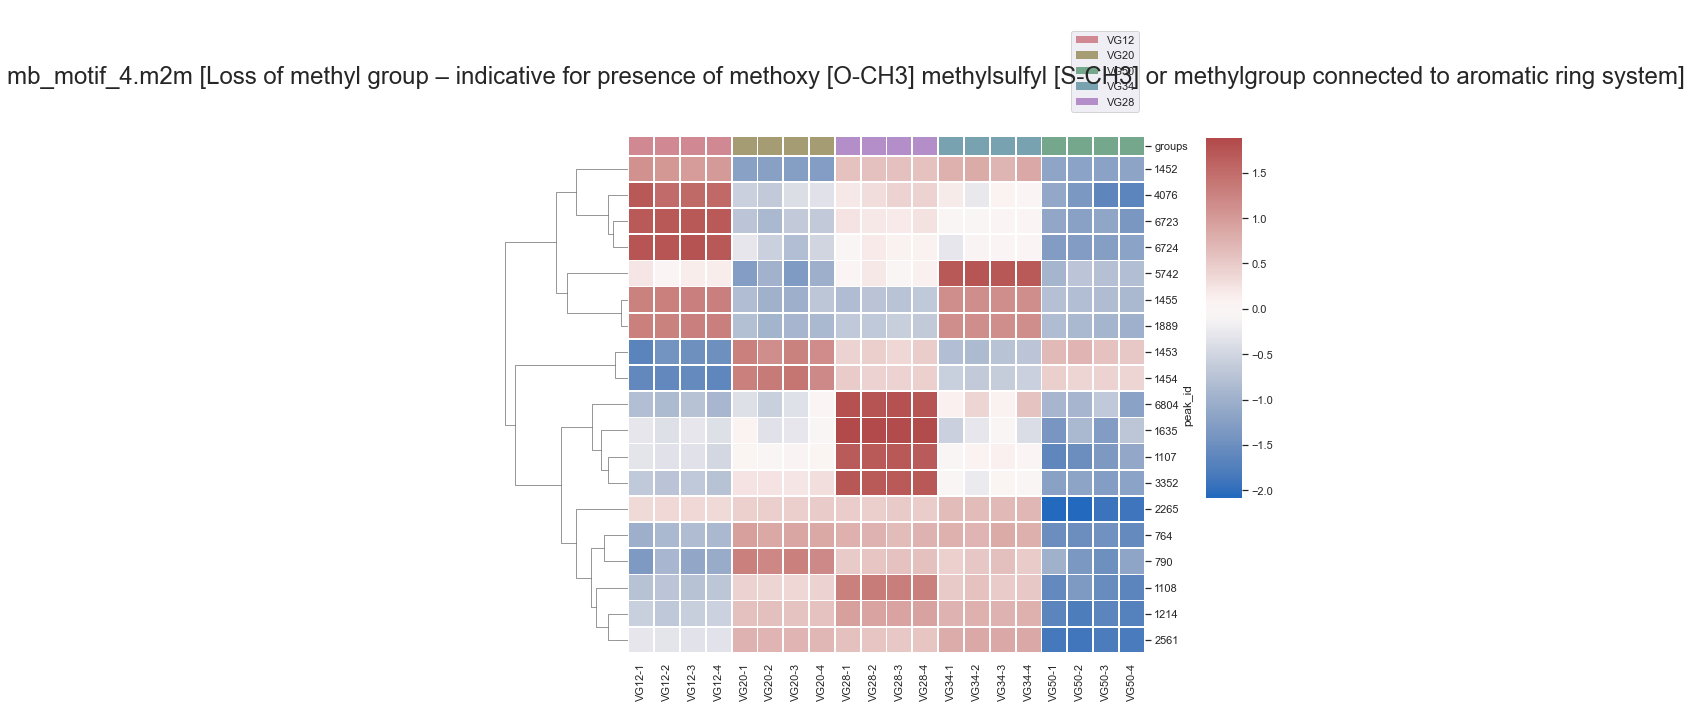

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                      
764         NaN       136.1112        3.364      157669.0          20   
790         NaN       137.0595        4.473       93884.0          20   
1107        NaN       147.0897        2.308      220321.0          20   
1108        NaN       147.0910        2.059      702687.0          20   
1214        NaN       151.1230        8.385      257296.0          20   
1452        NaN       158.0953        8.630     2018064.0          20   
1453        NaN       158.0958        5.490     2918794.0          20   
1454        NaN       158.0961        6.766     1282650.0          20   
1455        NaN       158.0965        8.440     4487817.0          20   
1635        NaN       164.1069        2.795      153689.0          20   
1889        NaN       170.0948        8.434     8521260.0          20   
2265        NaN       177.1380        2.086      828799.0          20   
2561        NaN       184.1123       12.786      832892.0          20   
3352        NaN       198.0902        7.398      145894.0          20   
4076        NaN       211.1216       14.450       24050.0          20   
5742        NaN       238.1331       14.440       37214.0          20   
6723        NaN       253.1330       12.050      470996.0          20   
6724        NaN       253.1330       12.630       90170.0          20   
6804        NaN       254.1558       11.259       48191.0          20   

                                                                                                                                        link  
id                                                                                                                                            
764     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=46&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
790    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=275&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1107    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=46&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1108    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=46&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1214   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=161&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1452    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=46&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1453    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=46&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1454    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=46&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1455    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=46&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1635   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=221&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1889    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=46&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2265   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=161&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2561  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=2010&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3352  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1307&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4076  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=2010&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5742  https://gnps.ucsd.edu/ProteoSAFe/re

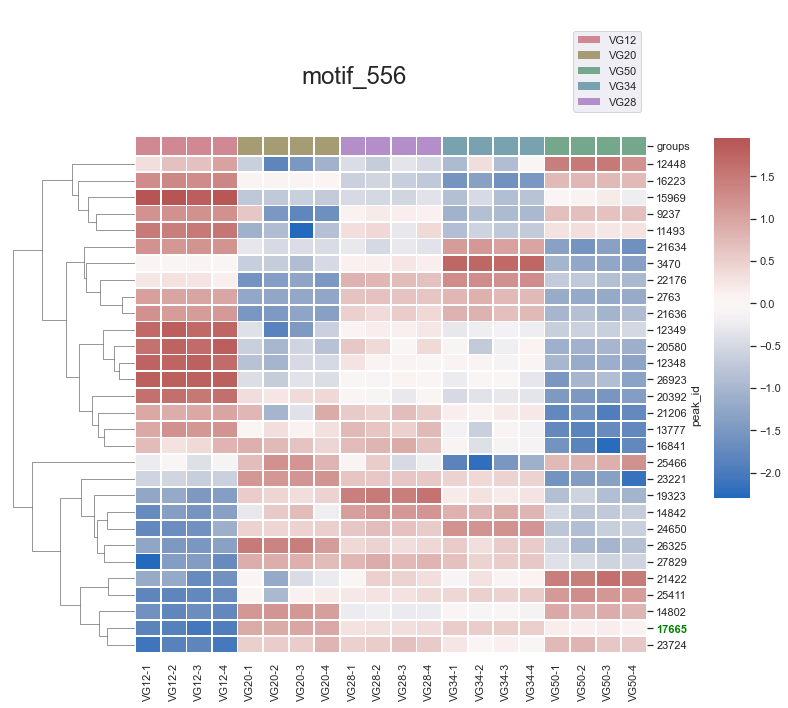

LibraryID  Precursor m/z  \
id                                                                    
2763                                             NaN       187.1223   
3470                                             NaN       200.1052   
9237                                             NaN       288.1344   
11493                                            NaN       316.1647   
12348                                            NaN       327.1427   
12349                                            NaN       327.1447   
12448                                            NaN       328.1677   
13777                                            NaN       345.1575   
14802                                            NaN       359.1696   
14842                                            NaN       359.2288   
15969                                            NaN       375.1660   
16223                                            NaN       378.1814   
16841                                            NaN       386.2430   
17665  Spectral Match to PyroGlu-Ile-Arg from NIST14       399.2364   
19323                                            NaN       424.1881   
20392                                            NaN       441.2486   
20580                                            NaN       444.2448   
21206                                            NaN       457.2083   
21422                                            NaN       461.1508   
21634                                            NaN       465.2724   
21636                                            NaN       465.2761   
22176                                            NaN       475.2935   
23221                                            NaN       498.2693   
23724                                            NaN       509.2625   
24650                                            NaN       530.3196   
25411                                            NaN       549.2564   
25466                                            NaN       551.1100   
26325                                            NaN       574.2852   
26923                                            NaN       592.3131   
27829                                            NaN       620.2679   

       RTConsensus  PrecursorInt  no_spectra  \
id                                             
2763         8.634     6817058.0          20   
3470         8.020      134473.0          20   
9237         6.768      189026.0          20   
11493       12.213       82263.0          20   
12348        4.980       45510.0          20   
12349        5.444       91259.0          20   
12448       12.009       80562.0          20   
13777        4.750       57861.0          20   
14802        4.386      107649.0          20   
14842        4.381       89594.0          20   
15969        4.386       80599.0          20   
16223       15.674      107948.0          20   
16841        8.500       60035.0          20   
17665        2.289      972581.0          20   
19323        5.503      121188.0          20   
20392       13.089       63136.0          20   
20580        8.713       43447.0          20   
21206       10.149       86920.0          20   
21422        5.598       25382.0          20   
21634        8.417      179091.0          20   
21636        8.628      141869.0          20   
22176        8.619      202959.0          20   
23221       15.244      192298.0          20   
23724        6.780       67000.0          20   
24650        5.487       98627.0          20   
25411        5.550       85939.0          20   
25466        5.515       18148.0          20   
26325        6.912       20521.0          20   
26923       18.556      193425.0          20   
27829        5.561       90519.0          20   

                                                                                                                                         link  
id                                                                                       

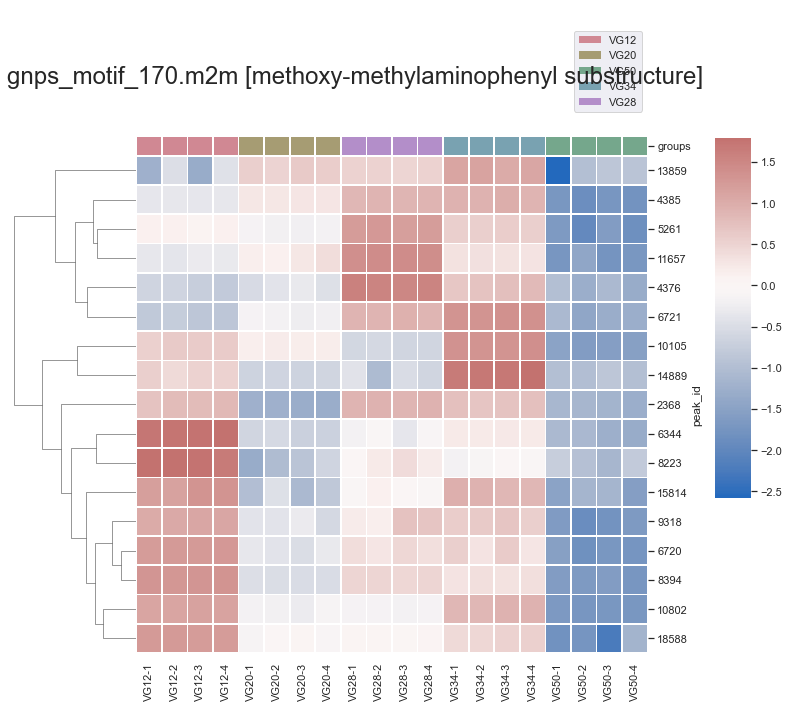

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
2368         NaN       180.1002        4.209      432965.0          20   
4376         NaN       216.1003        4.319       97639.0          20   
4385         NaN       216.1029        2.299     7051543.0          20   
5261         NaN       230.1158        3.623      264078.0          20   
6344         NaN       247.1432        8.161      311611.0          20   
6720         NaN       253.1317        4.920       55299.0          20   
6721         NaN       253.1325        5.267      164927.0          20   
8223         NaN       274.1440       10.780       58027.0          20   
8394         NaN       276.1368       11.322      306358.0          20   
9318         NaN       289.1521        4.541      105723.0          20   
10105        NaN       300.1431        1.462     9631867.0          20   
10802        NaN       308.1652       23.093      102312.0          20   
11657        NaN       318.1478       11.998       96853.0          20   
13859        NaN       346.1861        1.533      929487.0          20   
14889        NaN       360.1645        1.522      549764.0          20   
15814        NaN       373.1410        1.580      103835.0          20   
18588        NaN       413.2398        1.566      211543.0          20   

                                                                                                                                         link  
id                                                                                                                                             
2368     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4376     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4385     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5261     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6344    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=362&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6720     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6721     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8223     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8394     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9318     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10105  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1057&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10802    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11657    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13859   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=978&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
14889   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=978&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
15814   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=978&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
18588  h

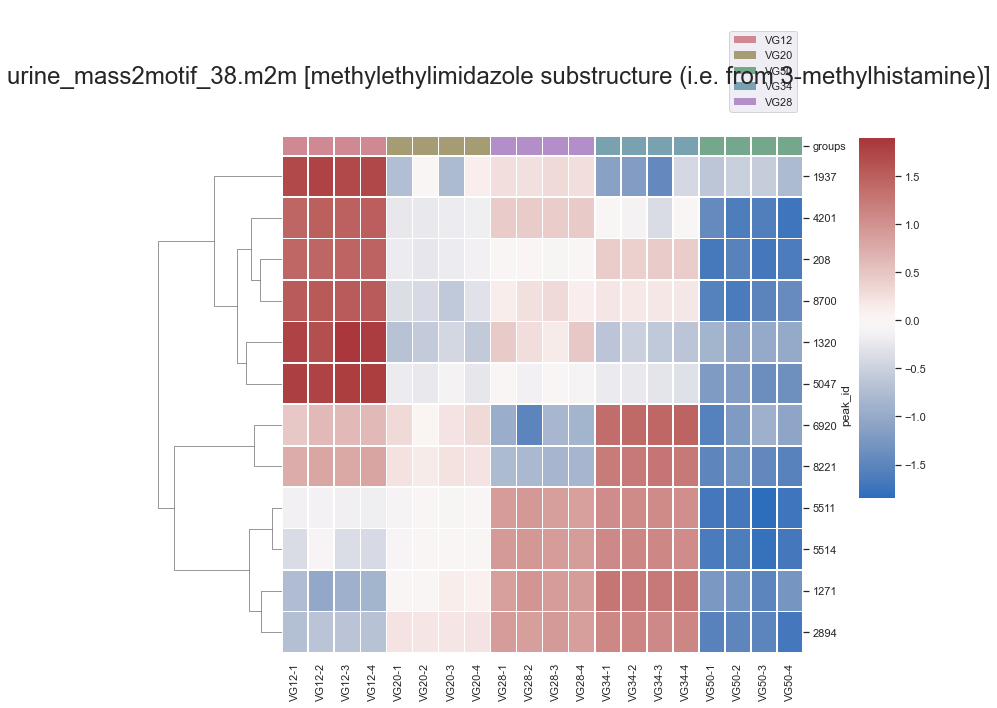

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                      
208         NaN       112.0867        1.232     2688608.0          20   
1271        NaN       153.1372        4.193      122710.0          20   
1320        NaN       155.0786        1.711      243693.0          20   
1937        NaN       171.0752        1.617      125336.0          20   
2894        NaN       190.0973        2.518     3001032.0          20   
4201        NaN       213.1238        3.810      469317.0          20   
5047        NaN       227.1386        8.205      282357.0          20   
5511        NaN       234.0851        2.737      519251.0          20   
5514        NaN       234.0871        2.670      516176.0          20   
6920        NaN       256.1296        1.242      147706.0          20   
8221        NaN       274.1397        1.226     2008662.0          20   
8700        NaN       280.1440       11.853      161894.0          20   

                                                                                                                                        link  
id                                                                                                                                            
208   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1043&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1271   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=988&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1320   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=359&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1937   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=741&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2894  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1043&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4201   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=478&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5047   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=478&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5511   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=535&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5514   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=535&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6920   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=149&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8221   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=149&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8700   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=302&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

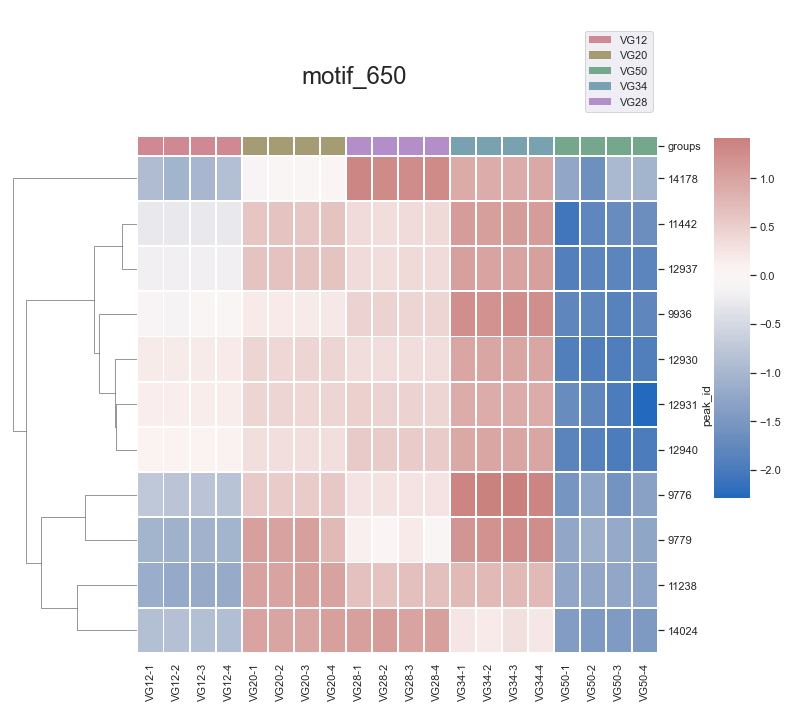

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
9776         NaN       295.2256       19.972      666032.0          20   
9779         NaN       295.2259       20.219      989139.0          20   
9936         NaN       297.2419       20.946     1257377.0          20   
11238        NaN       313.2364       20.411     1080588.0          20   
11442        NaN       315.2527       21.464     5528787.0          20   
12930        NaN       333.2624       21.698     6148267.0          20   
12931        NaN       333.2627       20.687     1621587.0          20   
12937        NaN       333.2636       21.461    11806960.0          20   
12940        NaN       333.2650       21.917     2014160.0          20   
14024        NaN       348.2734       20.741     2082680.0          20   
14178        NaN       350.2897       19.808      107466.0          20   

                                                                                                                                       link  
id                                                                                                                                           
9776   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=76&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9779   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=76&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9936   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=76&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11238  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=76&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11442  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=76&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12930  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=76&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12931  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=76&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12937  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=76&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12940  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=76&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
14024  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=76&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
14178  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=76&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

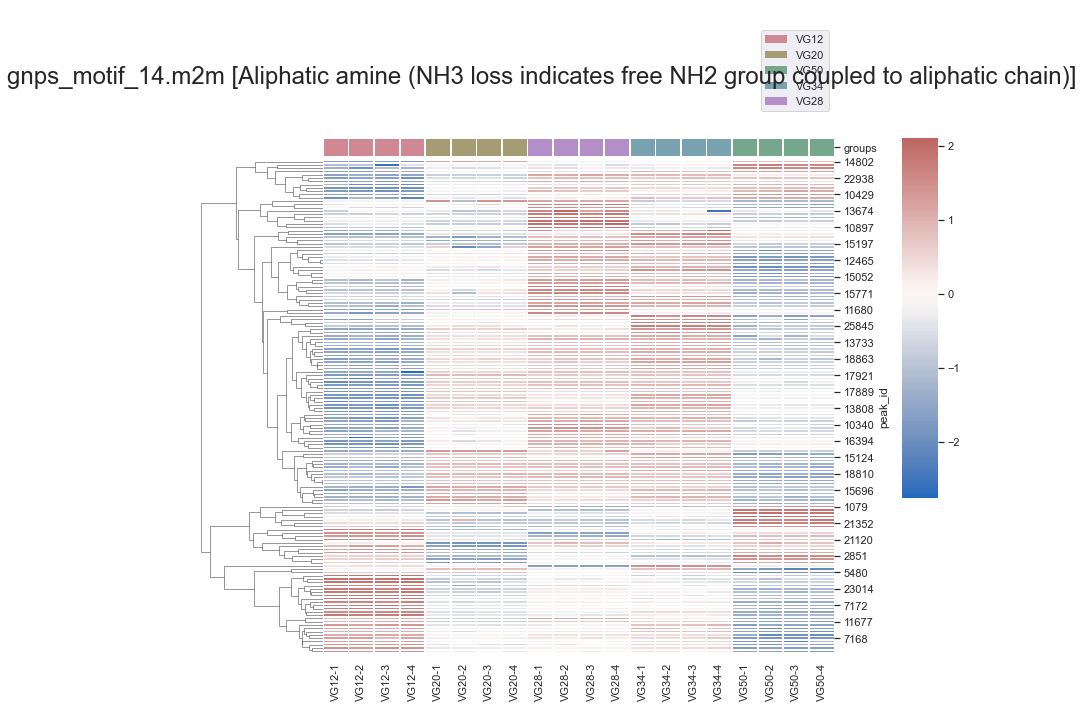

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                              
928                 NaN       142.0872        3.302     1428558.0          20   
1079                NaN       146.1172        2.745     2565670.0          20   
1415                NaN       157.0960        1.842      251762.0          20   
1520                NaN       160.0969        3.303     4387640.0          20   
1863                NaN       169.1327        1.595      437053.0          20   
...                 ...            ...          ...           ...         ...   
24500  NCGC00384828-01!       527.2852       16.911      253059.0          20   
24501               NaN       527.2881       18.048       29320.0          19   
25845               NaN       560.3293        7.217       66900.0          20   
25998               NaN       564.3388       17.901      125797.0          20   
27482               NaN       608.4028        9.222      140110.0          20   

                                                                                                                                         link  
id                                                                                                                                             
928     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=214&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1079    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=214&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1415   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1856&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1520    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=214&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1863    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=453&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
...                                                                                                                                       ...  
24500   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=805&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
24501   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=805&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
25845  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1070&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
25998  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1439&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
27482   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=165&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  

[150 rows x 6 columns]

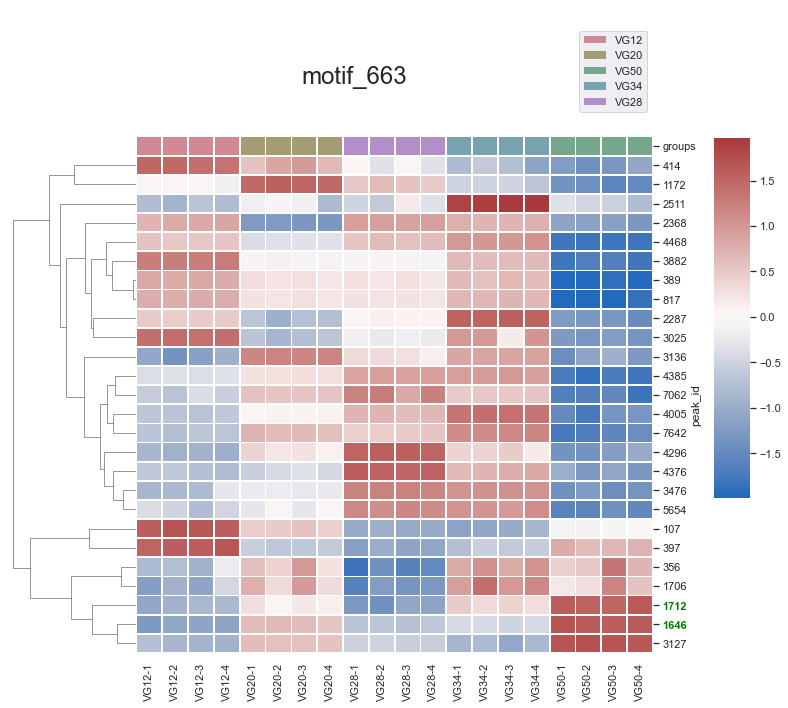

LibraryID  Precursor m/z  \
id                                                                              
107                                                        NaN       105.0699   
356                                                        NaN       120.0797   
389                                                        NaN       121.0640   
397                                                        NaN       121.0645   
414                                                        NaN       122.0587   
817                                                        NaN       138.0914   
1172                                                       NaN       150.0551   
1646  Spectral Match to p-Hydroxyphenyllactic acid from NIST14       165.0534   
1706                                                       NaN       166.0853   
1712            Spectral Match to DL-Phenylalanine from NIST14       166.0868   
2287                                                       NaN       178.1224   
2368                                                       NaN       180.1002   
2511                                                       NaN       183.1019   
3025                                                       NaN       192.1389   
3127                                                       NaN       194.1173   
3136                                                       NaN       194.1934   
3476                                                       NaN       200.1080   
3882                                                       NaN       208.1324   
4005                                                       NaN       210.1129   
4296                                                       NaN       215.0369   
4376                                                       NaN       216.1003   
4385                                                       NaN       216.1029   
4468                                                       NaN       217.1331   
5654                                                       NaN       237.0745   
7062                                                       NaN       258.1119   
7642                                                       NaN       266.1382   

      RTConsensus  PrecursorInt  no_spectra  \
id                                            
107        11.520      447632.0          20   
356         1.962    43328707.0          20   
389         1.572    29155326.0          20   
397        14.270      150318.0          20   
414         6.780       30103.0          20   
817         1.550     8576576.0          20   
1172        3.629       67893.0          20   
1646        1.457     6421442.0          20   
1706        1.961    84128834.0          20   
1712        3.004      745667.0          20   
2287        3.691      208348.0          20   
2368        4.209      432965.0          20   
2511       17.059       31260.0          20   
3025        4.959     1215659.0          20   
3127        8.710      619121.0          20   
3136        8.862       63872.0          20   
3476        6.628     2937616.0          20   
3882        1.893     6584070.0          20   
4005        4.389      164519.0          20   
4296        6.325       46060.0          20   
4376        4.319       97639.0          20   
4385        2.299     7051543.0          20   
4468        5.190      192407.0          20   
5654       10.618       47926.0          20   
7062        8.653      160294.0          20   
7642       14.819      114695.0          20   

                                                                                                                                        link  
id                                                                                                                                            
107     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
356     https://gnps.ucsd.edu/ProteoSA

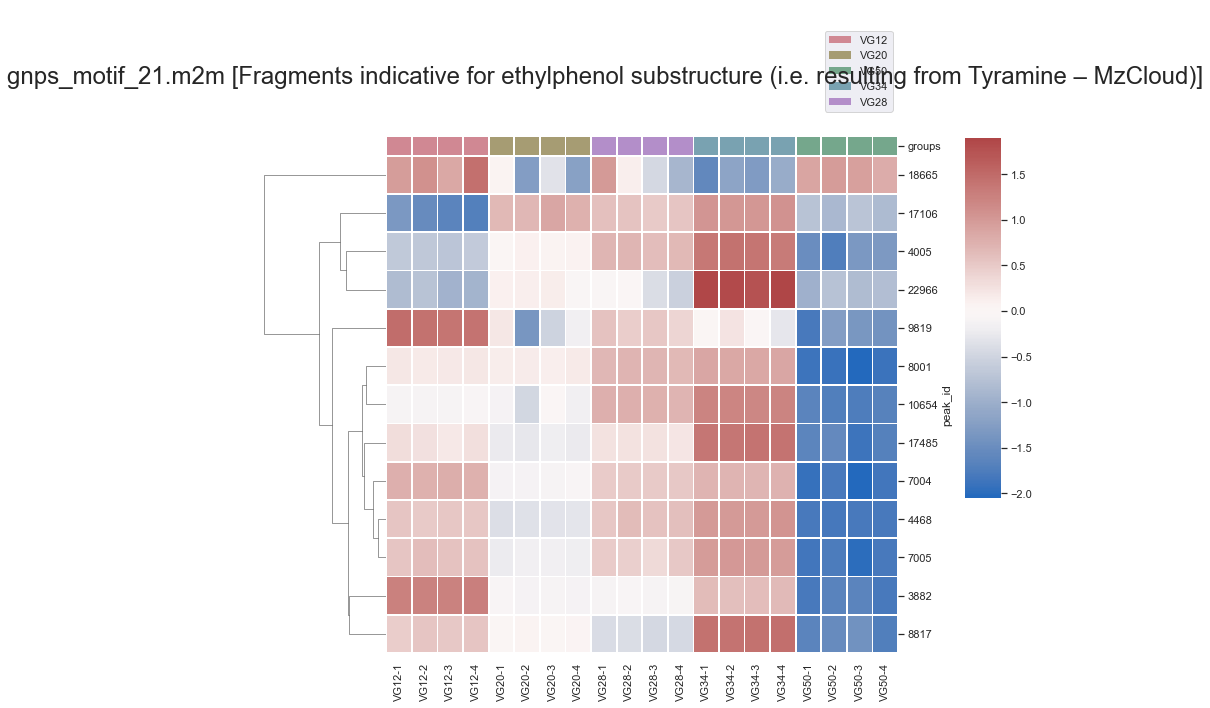

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
3882         NaN       208.1324        1.893     6584070.0          20   
4005         NaN       210.1129        4.389      164519.0          20   
4468         NaN       217.1331        5.190      192407.0          20   
7004         NaN       257.1633        7.817      380784.0          20   
7005         NaN       257.1633        4.017       82711.0          20   
8001         NaN       271.1814        9.540      701205.0          20   
8817         NaN       282.1334        1.461     1401126.0          20   
9819         NaN       296.1087       12.438       33400.0          20   
10654        NaN       306.1496       10.079       75998.0          20   
17106        NaN       390.2114        1.504      657508.0          20   
17485        NaN       396.1776        1.529      525051.0          20   
18665        NaN       414.2349        1.626      174103.0          20   
22966        NaN       492.2441        1.513      700315.0          20   

                                                                                                                                         link  
id                                                                                                                                             
3882     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4005     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4468     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7004     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7005     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8001     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8817   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1057&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9819     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10654    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
17106   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=962&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
17485   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=978&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
18665  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1597&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
22966  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1085&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

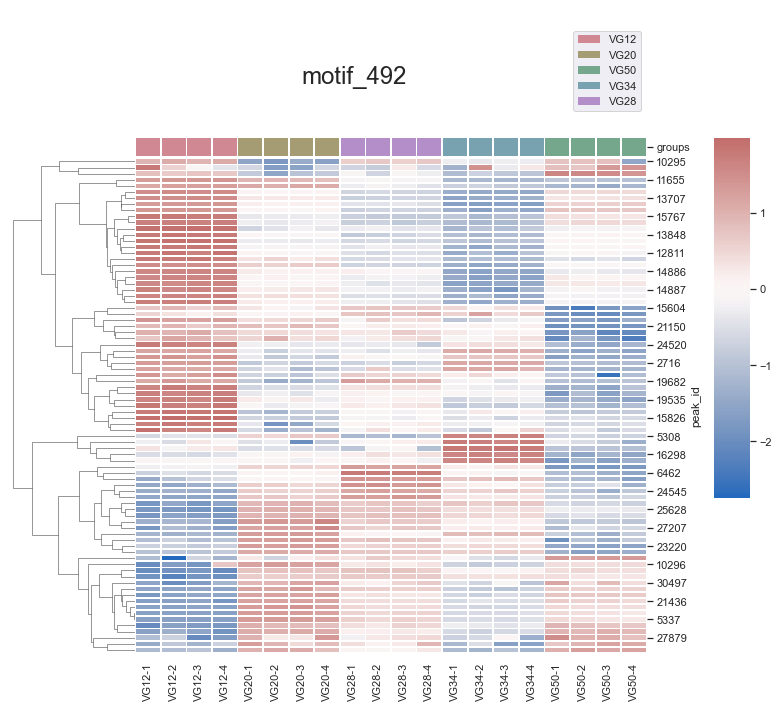

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
1449         NaN       158.0885        6.819     1135207.0          20   
1454         NaN       158.0961        6.766     1282650.0          20   
2716         NaN       186.5335        8.436      156332.0          19   
5308         NaN       231.0501        2.188      195638.0          20   
5316         NaN       231.0813        6.978       45170.0          20   
...          ...            ...          ...           ...         ...   
27896        NaN       622.2490        6.810       33045.0          20   
28518        NaN       645.3917        8.705       86823.0          20   
29999        NaN       710.2966        5.500       68268.0          20   
30375        NaN       729.2657        5.510       49381.0          20   
30497        NaN       735.2841        5.500       21054.0          20   

                                                                                                                                         link  
id                                                                                                                                             
1449     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=46&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1454     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=46&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2716     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=46&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5308   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1060&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5316     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=46&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
...                                                                                                                                       ...  
27896    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=44&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
28518    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=44&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
29999  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1122&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
30375  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1122&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
30497    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=44&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  

[81 rows x 6 columns]

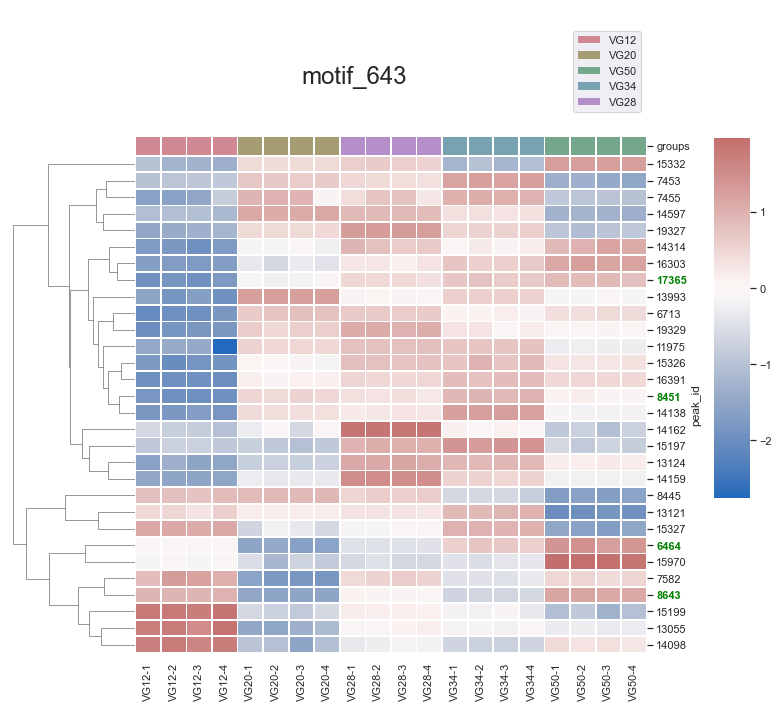

LibraryID  Precursor m/z  RTConsensus  \
id                                                                             
6464       Spectral Match to Met-Val from NIST14       249.1256        2.255   
6713                                         NaN       253.1172        2.763   
7453                                         NaN       263.1382        3.824   
7455                                         NaN       263.1386        7.206   
7582                                         NaN       265.1545        5.273   
8445                                         NaN       277.1170        9.843   
8451   Spectral Match to PyroGlu-Phe from NIST14       277.1189        9.217   
8643       Spectral Match to Leu-Phe from NIST14       279.1702        9.235   
11975                                        NaN       322.1758        8.334   
13055                                        NaN       335.1979        9.825   
13121                                        NaN       336.1910       11.816   
13124                                        NaN       336.1916        9.095   
13993                                        NaN       348.1550        9.102   
14098                                        NaN       349.2125       11.841   
14138                                        NaN       350.1719        6.215   
14159                                        NaN       350.2066       12.560   
14162                                        NaN       350.2070       13.346   
14314                                        NaN       352.1871        8.882   
14597                                        NaN       356.1955       12.037   
15197                                        NaN       364.2224       10.805   
15199                                        NaN       364.2230       15.912   
15326                                        NaN       366.1989       12.334   
15327                                        NaN       366.1993        8.378   
15332                                        NaN       366.2018        8.545   
15970                                        NaN       375.1668        5.135   
16303                                        NaN       379.1956        8.903   
16391                                        NaN       380.2188       11.818   
17365  Spectral Match to Glu-Val-Phe from NIST14       394.1968       12.048   
19327                                        NaN       424.2081       10.007   
19329                                        NaN       424.2084       12.222   

       PrecursorInt  no_spectra  \
id                                
6464       643066.0          20   
6713      2066506.0          20   
7453     28028519.0          20   
7455       334753.0          20   
7582      8928988.0          20   
8445       432908.0          20   
8451      9658780.0          20   
8643     11017924.0          20   
11975     1524203.0          20   
13055       99141.0          20   
13121     1080941.0          20   
13124      838420.0          20   
13993      340845.0          20   
14098      112509.0          20   
14138      226046.0          20   
14159      729540.0          20   
14162      100918.0          20   
14314     1067939.0          20   
14597      179180.0          20   
15197     1200919.0          20   
15199      149698.0          20   
15326      157778.0          20   
15327      591910.0          20   
15332     1026954.0          20   
15970      127461.0          20   
16303      159019.0          20   
16391      435425.0          20   
17365      187036.0          20   
19327      139953.0          20   
19329      116164.0          20   

                                                                                                                                         link  
id                                                                                                                                             
6464    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_disp

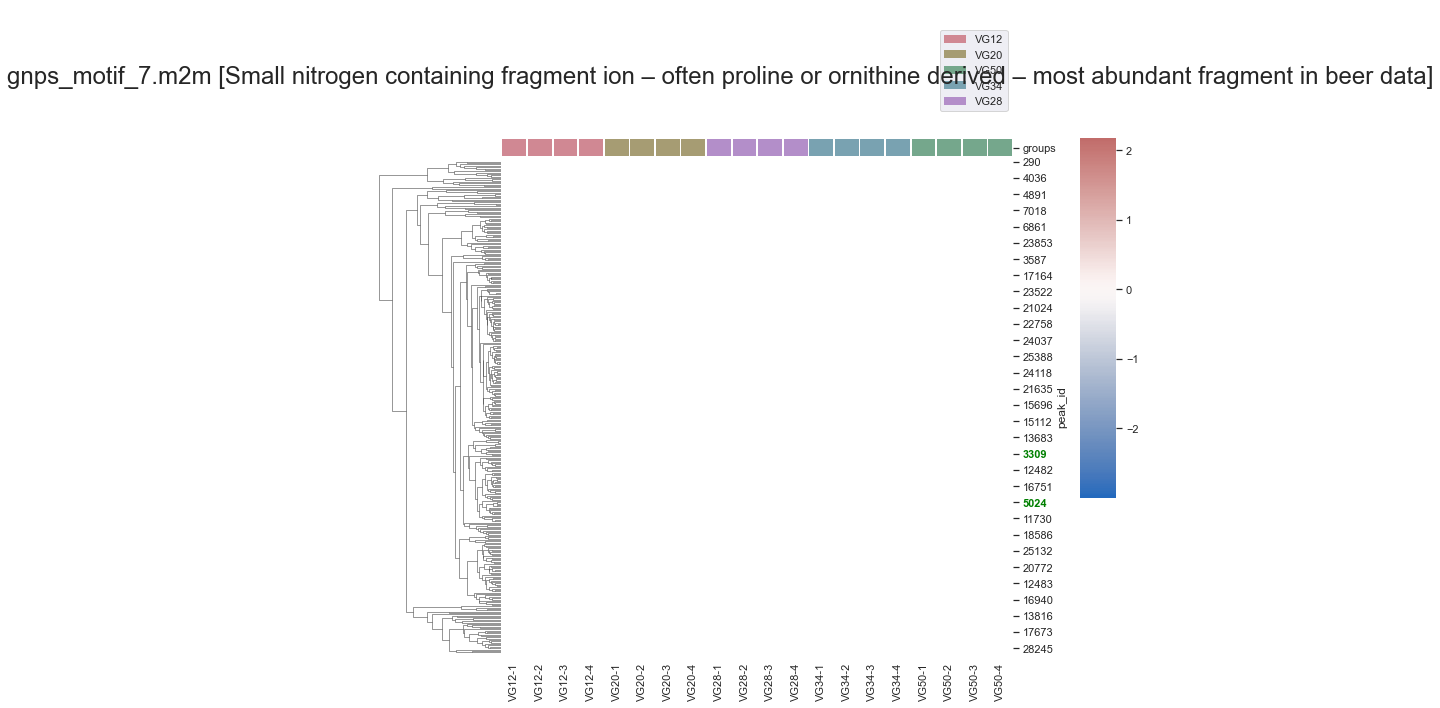

LibraryID  \
id                                                                                    
290                                                                             NaN   
1856                                                                            NaN   
2117                                                                            NaN   
2141   Massbank:PB000421 Arginine|2-amino-5-(diaminomethylideneamino)pentanoic acid   
3162                                                                            NaN   
...                                                                             ...   
29331                                                                           NaN   
29717                                                                           NaN   
30116                                                                           NaN   
31391                                                                           NaN   
31759                                                                           NaN   

       Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                            
290         116.0705        1.337     3717785.0          20   
1856        169.0963        1.863     4274151.0          20   
2117        175.0564        1.304      668250.0          20   
2141        175.1195        1.249     5867956.0          20   
3162        195.0754        1.622     2180005.0          20   
...              ...          ...           ...         ...   
29331       681.3480        2.777      116318.0          20   
29717       697.3198       13.091      115685.0          20   
30116       715.3256        9.796       42539.0          20   
31391       799.3607       11.040       46372.0          20   
31759       830.3544       11.501       38600.0          19   

                                                                                                                                         link  
id                                                                                                                                             
290      https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=51&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1856     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=24&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2117   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1073&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2141   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1073&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3162   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1497&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
...                                                                                                                                       ...  
29331  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1682&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
29717   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=938&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
30116   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=522&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
31391     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=9&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
31759   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=522&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  

[364 rows x 6 columns]

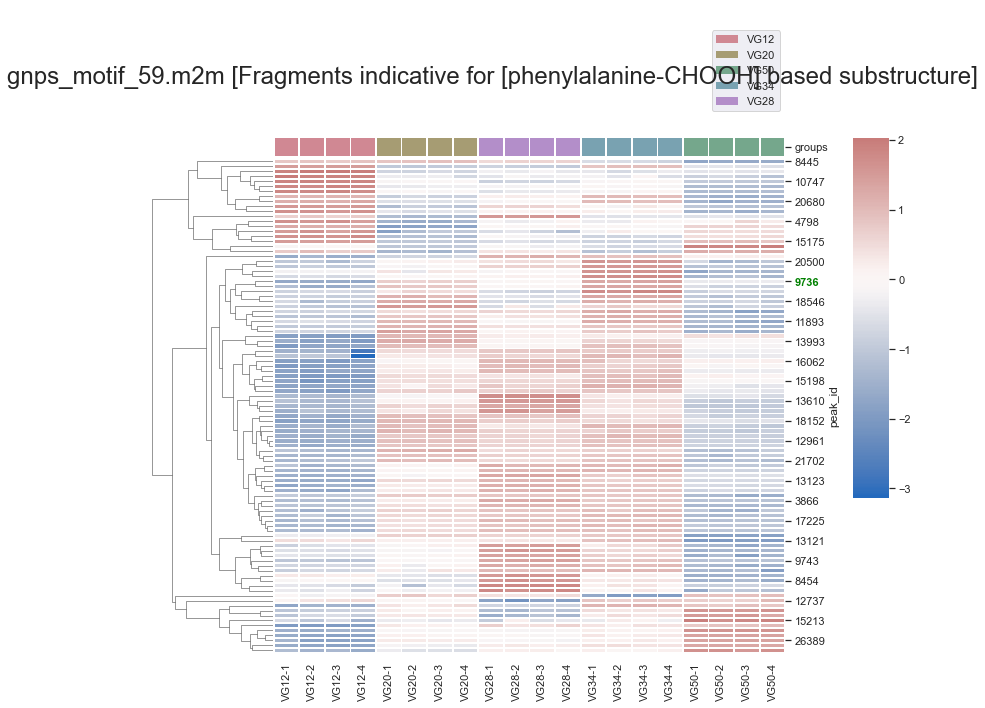

LibraryID  Precursor m/z  \
id                                                                     
1712   Spectral Match to DL-Phenylalanine from NIST14       166.0868   
3120                                              NaN       194.1162   
3866                                              NaN       208.0965   
4796                                              NaN       223.1069   
4798                                              NaN       223.1084   
...                                               ...            ...   
25517                                             NaN       552.2648   
25769                                             NaN       558.2508   
26389                                             NaN       576.2997   
27658                                             NaN       615.2348   
27812                                             NaN       619.3050   

       RTConsensus  PrecursorInt  no_spectra  \
id                                             
1712         3.004      745667.0          20   
3120         8.532      404767.0          20   
3866         9.922     1752591.0          20   
4796         3.004     6769881.0          20   
4798         2.196     3187134.0          20   
...            ...           ...         ...   
25517        3.008      332957.0          20   
25769       11.038      111519.0          20   
26389       12.860       92469.0          20   
27658       14.691       17694.0          20   
27812        4.204       39920.0          20   

                                                                                                                                         link  
id                                                                                                                                             
1712     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3120     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3866     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4796     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4798     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
...                                                                                                                                       ...  
25517   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=904&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
25769  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=2045&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
26389   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=773&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
27658  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1142&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
27812   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=152&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  

[99 rows x 6 columns]

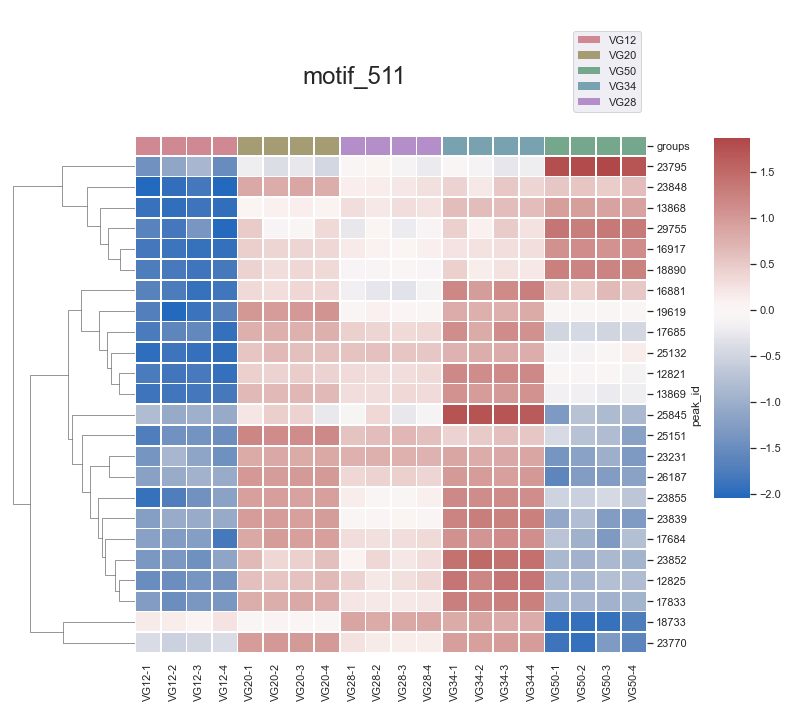

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
12821        NaN       332.1801        2.905      991746.0          20   
12825        NaN       332.1825        3.178      676132.0          20   
13868        NaN       346.1964        6.803      787954.0          20   
13869        NaN       346.1979        5.907      496310.0          20   
16881        NaN       387.1789        3.155      180552.0          20   
16917        NaN       387.2231        3.176      211237.0          20   
17684        NaN       399.2616        3.611      142265.0          20   
17685        NaN       399.2618        3.471      239241.0          20   
17833        NaN       401.2410        3.216      502029.0          20   
18733        NaN       415.2520        9.763      401246.0          20   
18890        NaN       417.2331        4.098      307448.0          20   
19619        NaN       428.2484        2.792      196279.0          20   
23231        NaN       498.3252        9.775      272478.0          19   
23770        NaN       510.3248       11.840      103801.0          20   
23795        NaN       511.2043        2.280      124524.0          20   
23839        NaN       512.2720        9.270      385750.0          20   
23848        NaN       512.3185        9.261      114230.0          20   
23852        NaN       512.3426       11.949       41901.0          20   
23855        NaN       512.3433       11.709      135329.0          20   
25132        NaN       542.2796       11.754       66335.0          20   
25151        NaN       542.3187       11.775       49872.0          20   
25845        NaN       560.3293        7.217       66900.0          20   
26187        NaN       569.3674        8.647      414986.0          18   
29755        NaN       698.4079       13.662       14754.0          19   

                                                                                                                                         link  
id                                                                                                                                             
12821   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=205&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12825   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=205&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13868   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=205&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13869   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=205&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
16881   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=984&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
16917   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=984&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
17684  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1401&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
17685  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1401&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
17833   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=896&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
18733   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=935&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
18890  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1486&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
19619   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=497&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
23231   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_d

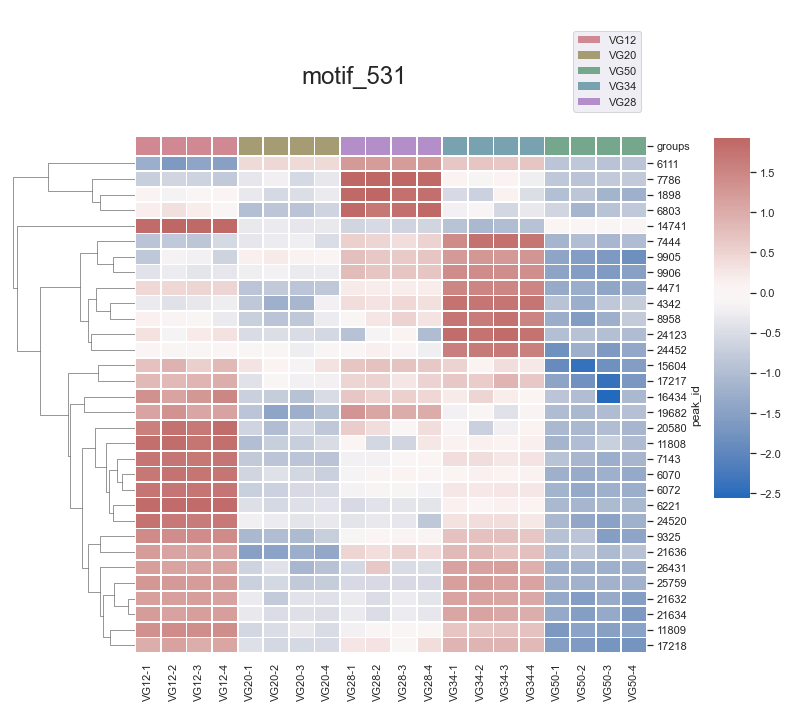

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
1898         NaN       170.0972        3.366       46206.0          20   
4342         NaN       215.1551       11.704      106690.0          20   
4471         NaN       217.1340        8.046     2166334.0          20   
6070         NaN       243.1495        8.307      459765.0          20   
6072         NaN       243.1496        9.776      950090.0          20   
6111         NaN       244.0956       19.214      220554.0          20   
6221         NaN       245.1653       14.081     1160834.0          20   
6803         NaN       254.1515       12.688       31603.0          20   
7143         NaN       259.1441       11.390      152281.0          20   
7444         NaN       263.1233        7.827       49273.0          20   
7786         NaN       268.1689       15.823       87834.0          20   
8958         NaN       284.1743       11.750       22361.0          20   
9325         NaN       289.1542       12.776       84376.0          20   
9905         NaN       297.1604       13.843       65488.0          20   
9906         NaN       297.1605       14.348       81329.0          20   
11808        NaN       320.1401        5.589      117347.0          20   
11809        NaN       320.1427        5.857      107860.0          20   
14741        NaN       358.2125       17.467      180689.0          20   
15604        NaN       370.1922        8.651       30328.0          20   
16434        NaN       381.1762        8.523       27382.0          20   
17217        NaN       392.1608       11.218       33165.0          20   
17218        NaN       392.1632       11.656       45223.0          20   
19682        NaN       429.2460        8.614       49619.0          20   
20580        NaN       444.2448        8.713       43447.0          20   
21632        NaN       465.2718        8.473      180477.0          20   
21634        NaN       465.2724        8.417      179091.0          20   
21636        NaN       465.2761        8.628      141869.0          20   
24123        NaN       518.3314        8.467       41655.0          16   
24452        NaN       526.3070        8.425       28501.0          20   
24520        NaN       527.3292        8.339       44961.0          20   
25759        NaN       557.4262        8.446       33020.0          13   
26431        NaN       577.4042        8.490       63727.0          17   

                                                                                                                                         link  
id                                                                                                                                             
1898   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1224&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4342     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=46&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4471     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=81&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6070   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1006&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6072   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1006&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6111   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1636&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6221   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1006&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6803   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1150&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7143    https://gnps.ucsd.edu/ProteoSAFe/result.js

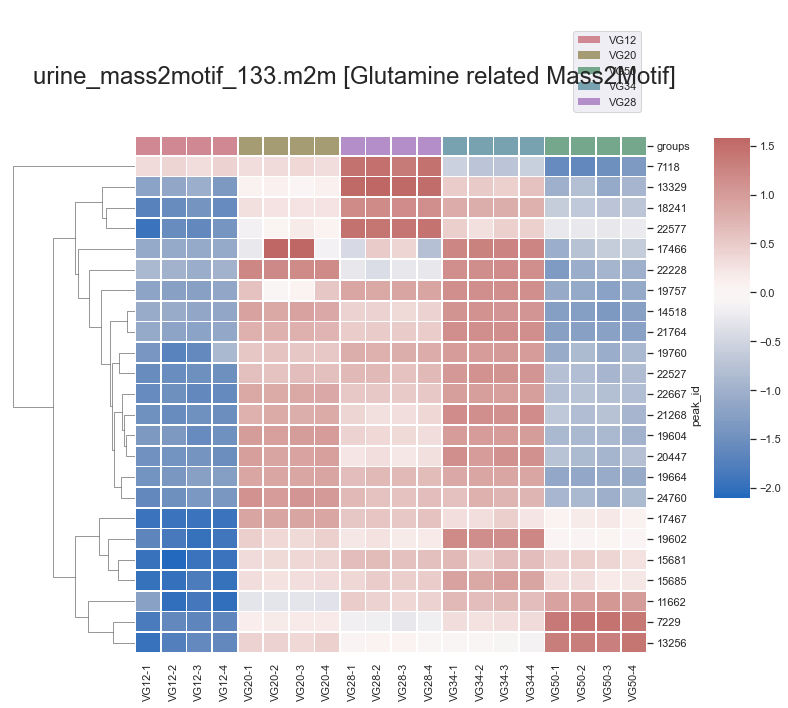

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
7118         NaN       259.0926        1.474     3468325.0          20   
7229         NaN       260.1612        1.466     4497672.0          20   
11662        NaN       318.1646        2.591      441698.0          20   
13256        NaN       338.1471        1.464      846650.0          20   
13329        NaN       339.1549        3.660      271957.0          20   
14518        NaN       355.1597        1.630     2973464.0          20   
15681        NaN       371.1908        3.501      817590.0          20   
15685        NaN       371.1932        2.977      345113.0          20   
17466        NaN       395.7118        2.638       52221.0          17   
17467        NaN       395.7140        2.725       56218.0          16   
18241        NaN       407.2289        4.986      286203.0          20   
19602        NaN       428.2110        2.758      157669.0          20   
19604        NaN       428.2126        3.813      860442.0          20   
19664        NaN       429.1976        5.078      350653.0          20   
19757        NaN       430.2635        5.749      421981.0          20   
19760        NaN       430.2655        5.667      450511.0          20   
20447        NaN       442.2332        3.153      189893.0          20   
21268        NaN       458.2232        2.642      418283.0          20   
21764        NaN       468.2464        6.711     1761262.0          20   
22228        NaN       476.7296       10.432      659050.0          18   
22527        NaN       483.2171        1.665     1283818.0          20   
22577        NaN       484.2734       12.973      130622.0          20   
22667        NaN       486.2542        1.646     3931932.0          20   
24760        NaN       533.2343        6.023       87108.0          20   

                                                                                                                                         link  
id                                                                                                                                             
7118     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=13&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7229   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1573&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11662   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=983&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13256    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=13&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13329   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=249&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
14518  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1085&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
15681   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=305&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
15685   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=305&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
17466   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=537&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
17467   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=537&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
18241   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=639&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
19602   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=497&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
19604   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_d

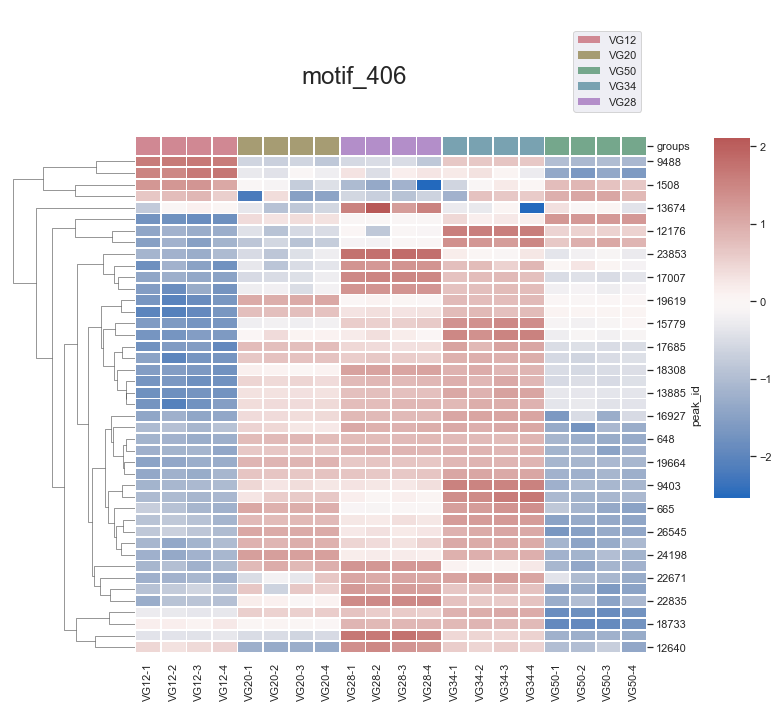

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
648          NaN       132.1009        7.214     1172860.0          20   
665          NaN       132.1018        9.003      332000.0          20   
1508         NaN       159.6302        6.180       13210.0          20   
5070         NaN       227.1756       14.711     4996633.0          20   
8703         NaN       280.1537       17.294      260330.0          20   
9403         NaN       290.1692        3.162      738599.0          20   
9488         NaN       291.1729       14.623      113306.0          20   
11686        NaN       318.2029        4.793     1266484.0          20   
12176        NaN       324.6533        9.743       57105.0          20   
12640        NaN       330.2017        2.701      566629.0          20   
13674        NaN       344.0776       12.134       38156.0          20   
13798        NaN       345.2127        5.228      446287.0          20   
13885        NaN       346.2346       11.184     1067849.0          20   
14536        NaN       355.2313        3.731       99567.0          20   
14978        NaN       361.1691        1.687      781136.0          20   
15628        NaN       370.2690       16.891      133959.0          20   
15779        NaN       372.2864       17.623      154368.0          20   
15810        NaN       373.1283       10.962       68505.0          20   
16091        NaN       376.2248       10.353       54430.0          20   
16927        NaN       387.2577        4.905      174607.0          20   
17002        NaN       388.2416       13.494       58381.0          20   
17007        NaN       388.2444       14.064       51111.0          20   
17685        NaN       399.2618        3.471      239241.0          20   
18297        NaN       408.2137       11.547      263462.0          20   
18308        NaN       408.2470       12.303      219669.0          20   
18733        NaN       415.2520        9.763      401246.0          20   
18890        NaN       417.2331        4.098      307448.0          20   
19619        NaN       428.2484        2.792      196279.0          20   
19664        NaN       429.1976        5.078      350653.0          20   
20586        NaN       444.2705        2.618       37932.0          20   
21587        NaN       464.3581       21.456       90681.0          20   
21807        NaN       469.2300       10.081      668525.0          20   
21945        NaN       471.3545       16.230       89131.0          20   
22671        NaN       486.2904       12.427       86580.0          20   
22835        NaN       489.3079       17.570       39695.0          20   
22944        NaN       491.3238       16.226       23378.0          20   
23236        NaN       498.3268       12.043      107702.0          20   
23853        NaN       512.3432       15.036       50696.0          20   
24198        NaN       520.2749        4.764      444138.0          20   
26545        NaN       581.3284       13.829      103259.0          20   
26575        NaN       582.3132       14.409      167588.0          20   
28417        NaN       641.3888       10.094      114200.0          20   
29754        NaN       698.4078       10.014       42877.0          20   

                                                                                                                                         link  
id                                                                                                                                             
648     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=214&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
665    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1898&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1508    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=709&task=3

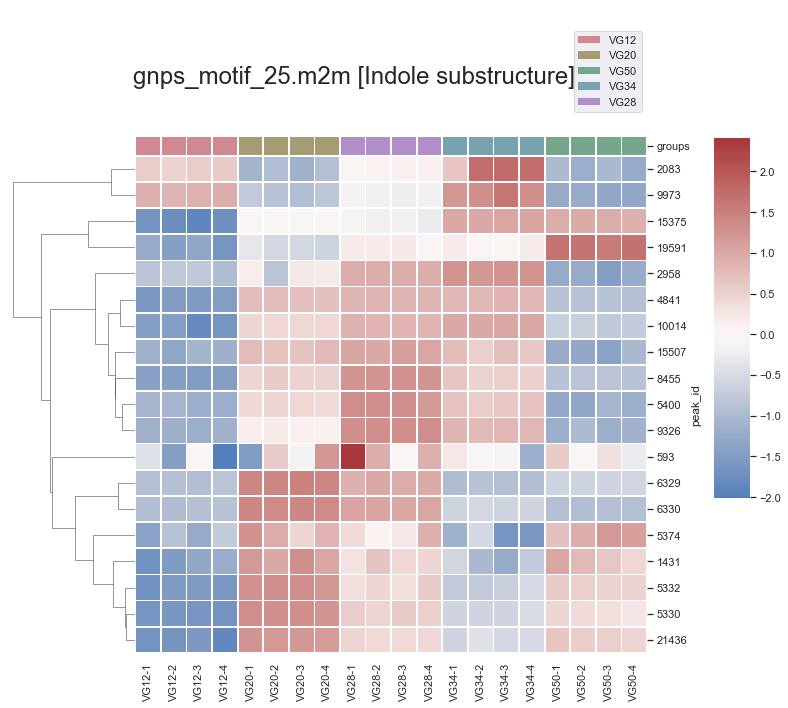

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
593          NaN       130.0638       39.990      145919.0          20   
1431         NaN       157.5978        5.510       25874.0          20   
2083         NaN       174.0906        6.595      133844.0          20   
2958         NaN       191.1152        3.478      274451.0          20   
4841         NaN       224.0907        2.030     8318838.0          20   
5330         NaN       231.1113        6.820    20679848.0          20   
5332         NaN       231.1119        5.490    44942157.0          20   
5374         NaN       231.7420        5.509       11245.0          20   
5400         NaN       232.0956       10.944      165601.0          20   
6329         NaN       247.1067        2.819     2919574.0          20   
6330         NaN       247.1069        2.676     2828084.0          20   
8455         NaN       277.1200       10.369       90910.0          20   
9326         NaN       289.1545       11.656      281416.0          20   
9973         NaN       298.1549       17.894       92481.0          20   
10014        NaN       299.1002        5.546      647914.0          20   
15375        NaN       367.1477        3.009      252647.0          20   
15507        NaN       369.1414       14.059       59967.0          20   
19591        NaN       428.1816       13.429       58089.0          20   
21436        NaN       461.2201        6.796      223531.0          20   

                                                                                                                                         link  
id                                                                                                                                             
593     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=308&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1431     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=46&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2083    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=723&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2958    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=283&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4841     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=90&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5330     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=46&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5332     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=46&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5374     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=46&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5400     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=90&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6329    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=625&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6330    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=625&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8455    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=435&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9326    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=625&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9973     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=58&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10014   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=625&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1537

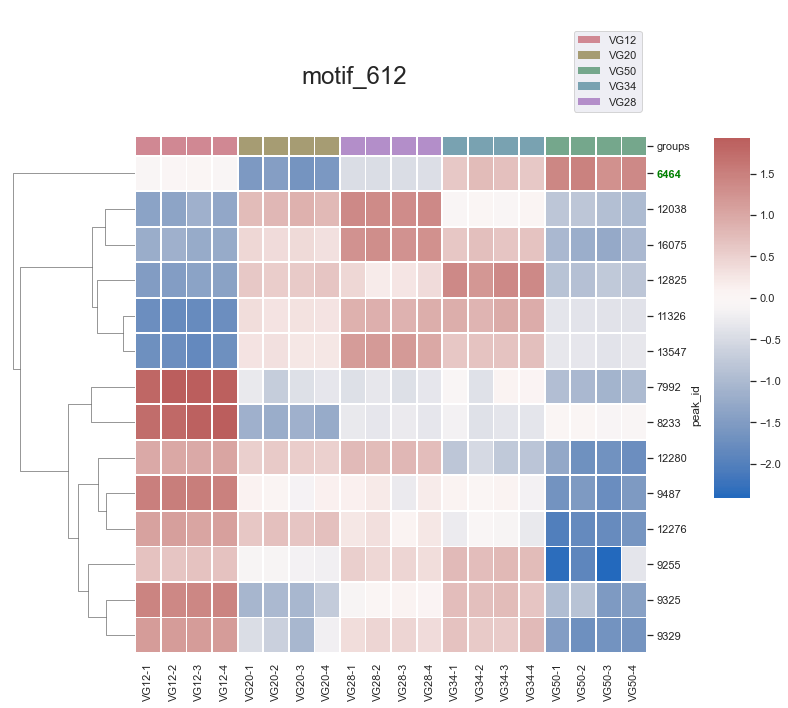

LibraryID  Precursor m/z  RTConsensus  \
id                                                                         
6464   Spectral Match to Met-Val from NIST14       249.1256        2.255   
7992                                     NaN       271.1651        1.826   
8233                                     NaN       274.1773        2.642   
9255                                     NaN       288.1929        4.821   
9325                                     NaN       289.1542       12.776   
9329                                     NaN       289.1562       11.425   
9487                                     NaN       291.1725       11.425   
11326                                    NaN       314.2077        3.529   
12038                                    NaN       323.1616        2.053   
12276                                    NaN       326.1503       13.381   
12280                                    NaN       326.1520       19.023   
12825                                    NaN       332.1825        3.178   
13547                                    NaN       342.2004       10.384   
16075                                    NaN       376.2083        7.324   

       PrecursorInt  no_spectra  \
id                                
6464       643066.0          20   
7992       684609.0          20   
8233      1373992.0          20   
9255       925934.0          20   
9325        84376.0          20   
9329        92858.0          20   
9487       115986.0          20   
11326     4509939.0          20   
12038      446395.0          20   
12276       68790.0          20   
12280       48466.0          20   
12825      676132.0          20   
13547     1361639.0          20   
16075       90904.0          20   

                                                                                                                                         link  
id                                                                                                                                             
6464    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=829&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7992    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=653&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8233    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=214&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9255    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=214&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9325   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1006&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9329   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1006&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9487     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=90&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11326    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=51&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12038    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=96&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12276    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=91&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12280    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=91&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12825   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=205&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13547  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1316&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
16075   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=561&tas

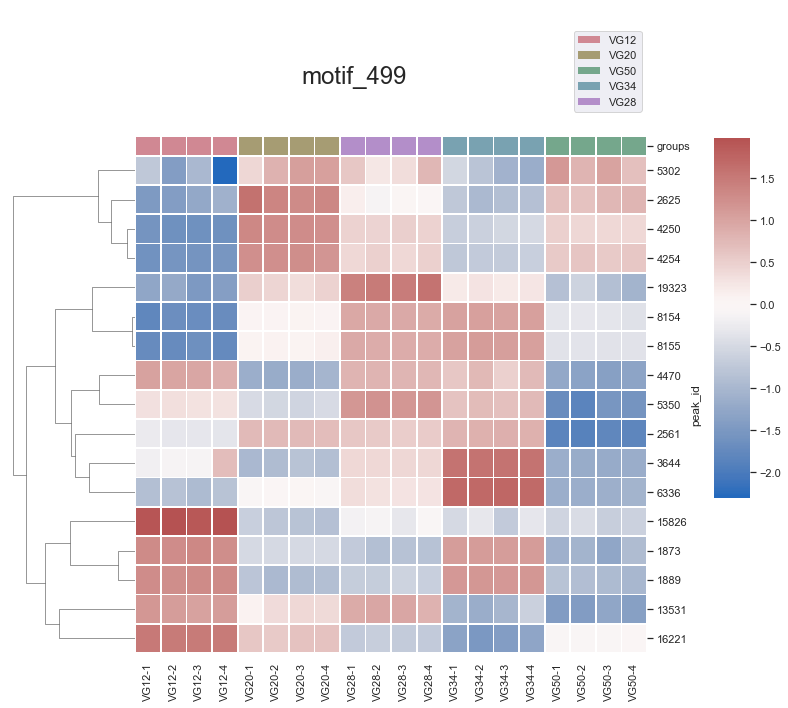

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
1873         NaN       169.5633        8.436       86952.0          17   
1889         NaN       170.0948        8.434     8521260.0          20   
2561         NaN       184.1123       12.786      832892.0          20   
2625         NaN       185.1088        6.799      297310.0          20   
3644         NaN       203.1176        6.502      847678.0          20   
4250         NaN       214.0843        6.820     2591324.0          20   
4254         NaN       214.0863        5.490     5798546.0          20   
4470         NaN       217.1339        8.485      169442.0          20   
5302         NaN       230.9600        5.528       16405.0          20   
5350         NaN       231.1476        9.984      355054.0          20   
6336         NaN       247.1271       13.158      230241.0          20   
8154         NaN       273.1603       13.483      738784.0          20   
8155         NaN       273.1606       12.324      779423.0          20   
13531        NaN       342.1446       14.504       86084.0          20   
15826        NaN       373.1892       11.588      108804.0          20   
16221        NaN       378.1802       15.151      379952.0          20   
19323        NaN       424.1881        5.503      121188.0          20   

                                                                                                                                         link  
id                                                                                                                                             
1873     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=46&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1889     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=46&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2561   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=2010&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2625     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=46&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3644     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=81&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4250    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=438&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4254    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=438&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4470   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1006&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5302     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=46&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5350   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1393&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6336   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1006&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8154   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1393&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8155   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1393&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13531    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=58&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
15826   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=103&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
16221    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=58&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
19323   

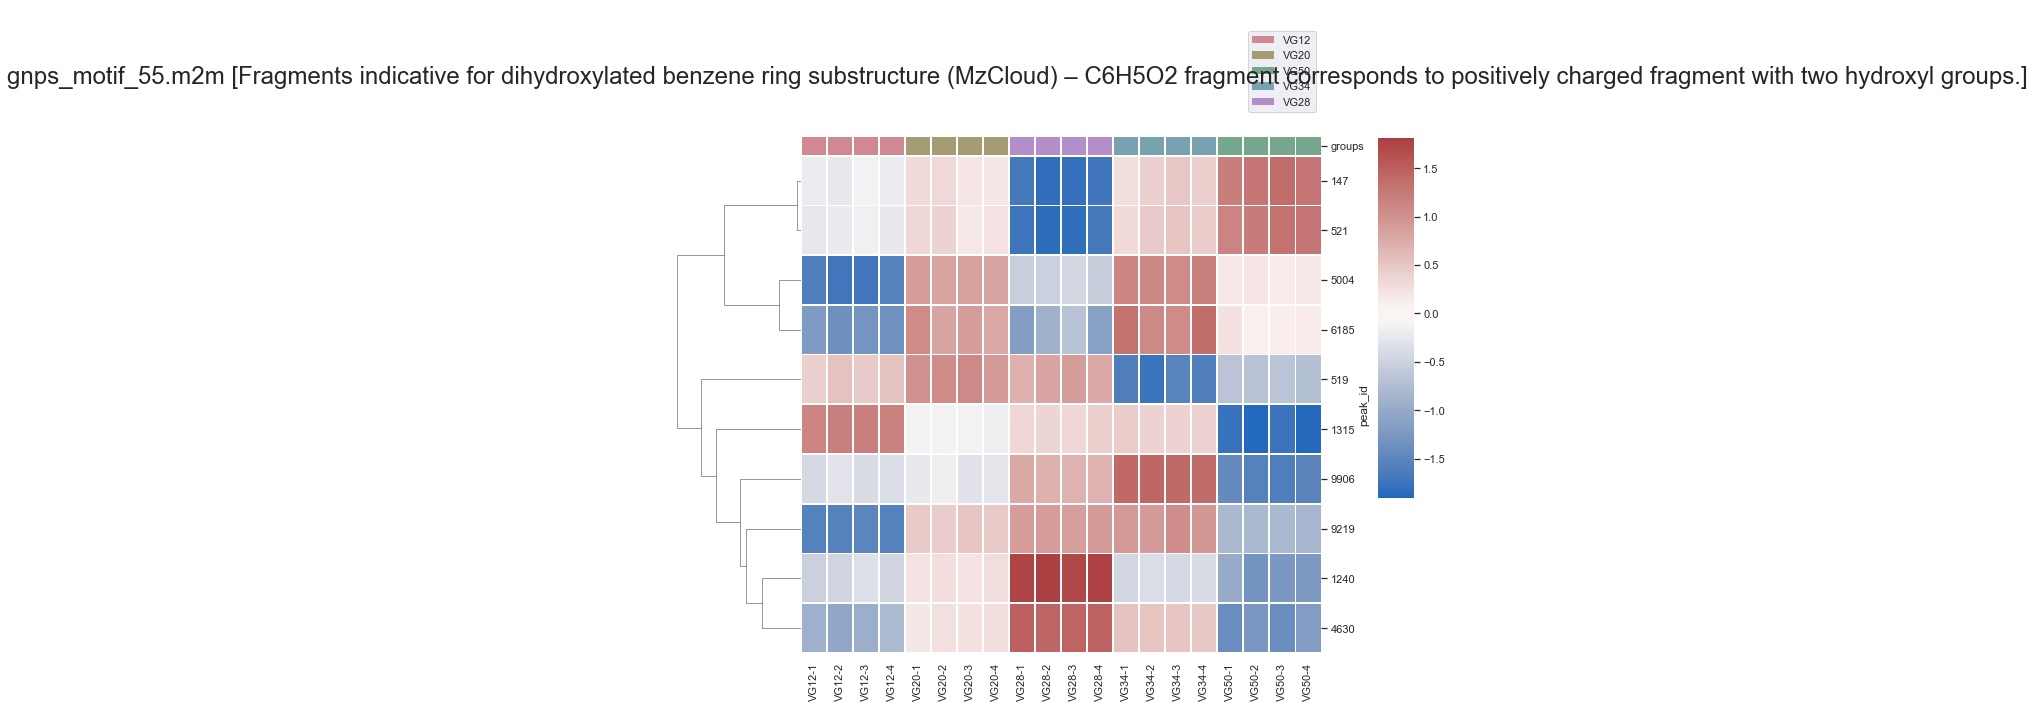

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                      
147         NaN       109.0289        2.180     4877550.0          20   
519         NaN       127.0387        2.868     1390139.0          20   
521         NaN       127.0394        2.180     7053023.0          20   
1240        NaN       152.1068        1.823      396335.0          20   
1315        NaN       155.0696        6.244      234439.0          20   
4630        NaN       220.0956        2.917      683698.0          20   
5004        NaN       227.0691       12.410      322317.0          20   
6185        NaN       245.0806       12.405       61183.0          20   
9219        NaN       288.0875        3.338     1133708.0          20   
9906        NaN       297.1605       14.348       81329.0          20   

                                                                                                                                        link  
id                                                                                                                                            
147     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=13&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
519    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=992&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
521     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=13&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1240    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=13&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1315    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=13&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4630    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=13&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5004   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=647&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6185   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=647&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9219    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=13&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9906  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1245&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

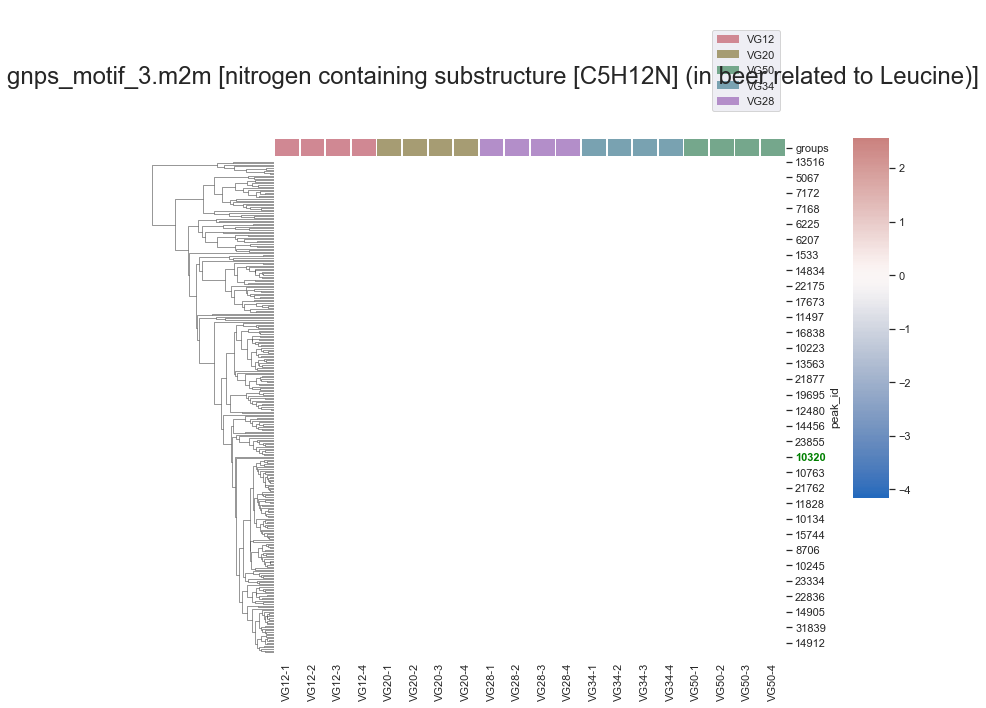

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                      
667         NaN       132.1019        1.510    14786650.0          20   
1533        NaN       160.1334        5.615     3878939.0          20   
1534        NaN       160.1336        5.681     3507331.0          20   
1962        NaN       171.1130        2.906     1373187.0          20   
2092        NaN       174.1120        7.222     5852363.0          20   
...         ...            ...          ...           ...         ...   
29287       NaN       679.3657        9.009      316456.0          20   
29929       NaN       706.3096        1.641      525985.0          20   
30030       NaN       711.4646       12.517       54289.0          17   
31839       NaN       838.3512        1.639      271112.0          20   
31873       NaN       841.4434       14.535       73868.0          19   

                                                                                                                                         link  
id                                                                                                                                             
667     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=214&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1533    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=214&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1534    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=214&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1962   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1856&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2092    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=214&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
...                                                                                                                                       ...  
29287   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=165&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
29929  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=2014&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
30030   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=234&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
31839  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=2014&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
31873   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=944&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  

[317 rows x 6 columns]

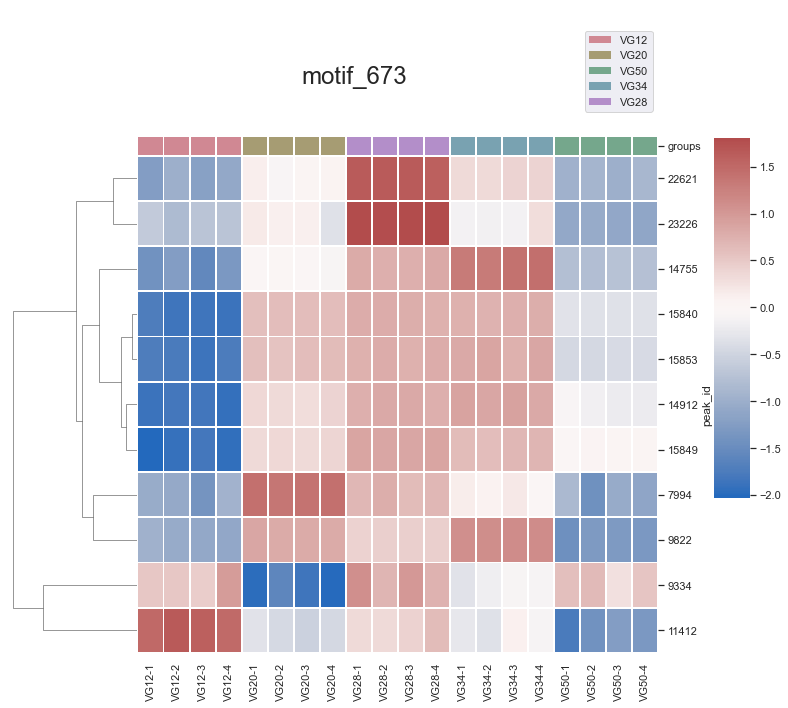

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
7994         NaN       271.1652        9.014      122509.0          20   
9334         NaN       289.1740        7.701      279100.0          20   
9822         NaN       296.1115       13.346      239921.0          20   
11412        NaN       315.2059       18.394       23543.0          20   
14755        NaN       358.2683       13.295     1238403.0          20   
14912        NaN       360.2121        6.721      326329.0          20   
15840        NaN       373.2423       10.451      517848.0          20   
15849        NaN       373.2445       10.927     1000591.0          20   
15853        NaN       373.2449       10.042      197140.0          20   
22621        NaN       485.2583       13.531      121782.0          20   
23226        NaN       498.2925       14.595      605650.0          20   

                                                                                                                                         link  
id                                                                                                                                             
7994   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1569&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9334    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=303&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9822   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1817&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11412   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=966&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
14755   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=233&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
14912   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=643&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
15840  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1120&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
15849  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1120&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
15853  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1120&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
22621   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=581&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
23226  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1220&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

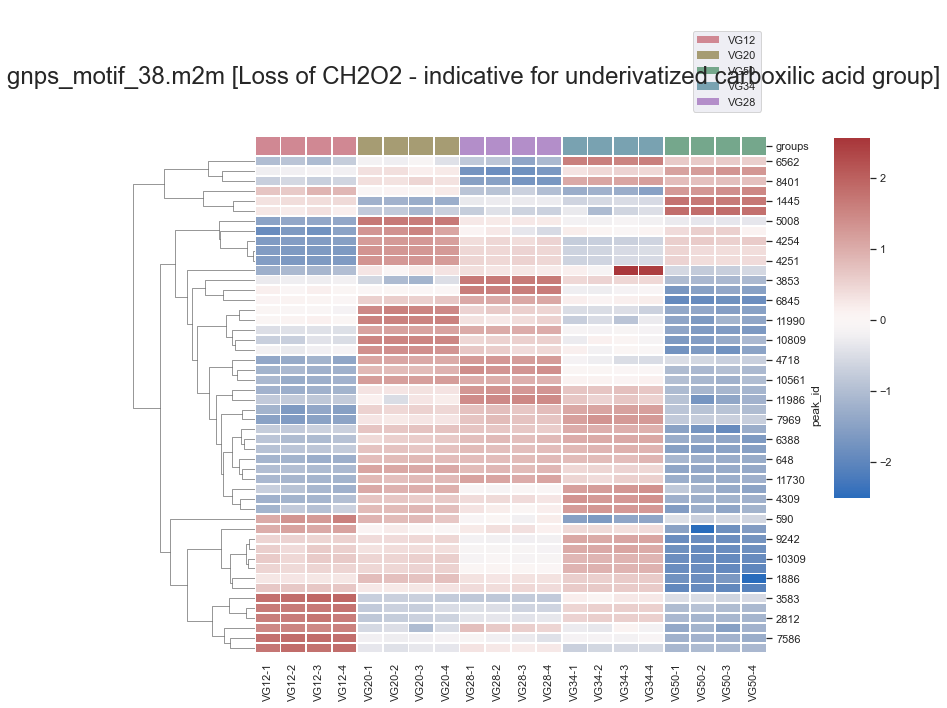

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
432          NaN       123.0431        2.853      123303.0          20   
521          NaN       127.0394        2.180     7053023.0          20   
590          NaN       130.0500        1.478    10780196.0          20   
648          NaN       132.1009        7.214     1172860.0          20   
665          NaN       132.1018        9.003      332000.0          20   
667          NaN       132.1019        1.510    14786650.0          20   
1172         NaN       150.0551        3.629       67893.0          20   
1445         NaN       158.0814        2.087     3793274.0          20   
1886         NaN       170.0813        2.100      377579.0          20   
2003         NaN       172.0965        4.097     1890272.0          20   
2208         NaN       177.0077        5.292      135167.0          20   
2809         NaN       188.1270        1.601      864002.0          20   
2812         NaN       188.1282        1.527      854658.0          20   
3430         NaN       199.1432        3.309      515852.0          20   
3583         NaN       202.1435        1.838     1447415.0          20   
3852         NaN       208.0595        2.148      188437.0          20   
3853         NaN       208.0597        3.834      716759.0          20   
4250         NaN       214.0843        6.820     2591324.0          20   
4251         NaN       214.0859        6.766     2608768.0          20   
4254         NaN       214.0863        5.490     5798546.0          20   
4309         NaN       215.0821        2.531      298981.0          20   
4718         NaN       222.0757        1.546      399140.0          20   
4728         NaN       222.0971        2.207      389141.0          20   
4835         NaN       224.0784        1.596     1221306.0          20   
5008         NaN       227.0806        5.409     4707667.0          20   
5719         NaN       238.0929        2.004     1086078.0          20   
6037         NaN       243.0763        6.268      111297.0          20   
6388         NaN       248.0921        6.379       48181.0          20   
6437         NaN       249.0773       11.765       45808.0          20   
6562         NaN       251.0553        3.748      102428.0          20   
6845         NaN       255.1111       10.892      289434.0          20   
7215         NaN       260.1277       18.477      305554.0          20   
7586         NaN       265.1548        4.779      178899.0          20   
7969         NaN       271.1089       15.509       98959.0          20   
8385         NaN       276.1234       15.237       70074.0          20   
8401         NaN       276.1446        1.619    12612753.0          20   
9242         NaN       288.1578       23.463      159511.0          20   
10309        NaN       302.1743       25.454      290116.0          20   
10310        NaN       302.1755       25.014      444076.0          20   
10561        NaN       305.0927       13.790      211938.0          20   
10809        NaN       308.1953        8.468       45894.0          20   
10810        NaN       308.1969        6.720       90098.0          20   
11730        NaN       319.1283        3.482      242061.0          20   
11986        NaN       322.2007       14.309       27849.0          20   
11990        NaN       322.2106       11.867       62655.0          20   
12229        NaN       325.2133       20.757      128433.0          20   
13107        NaN       336.1588       25.556      110309.0          20   
14598        NaN       356.1959       12.803       58359.0          20   
18707        NaN       415.1975       22.257       95835.0          20   
18711        NaN       415.2006       22.008       56818.0          20   

                                                                                                                                         link  
id            

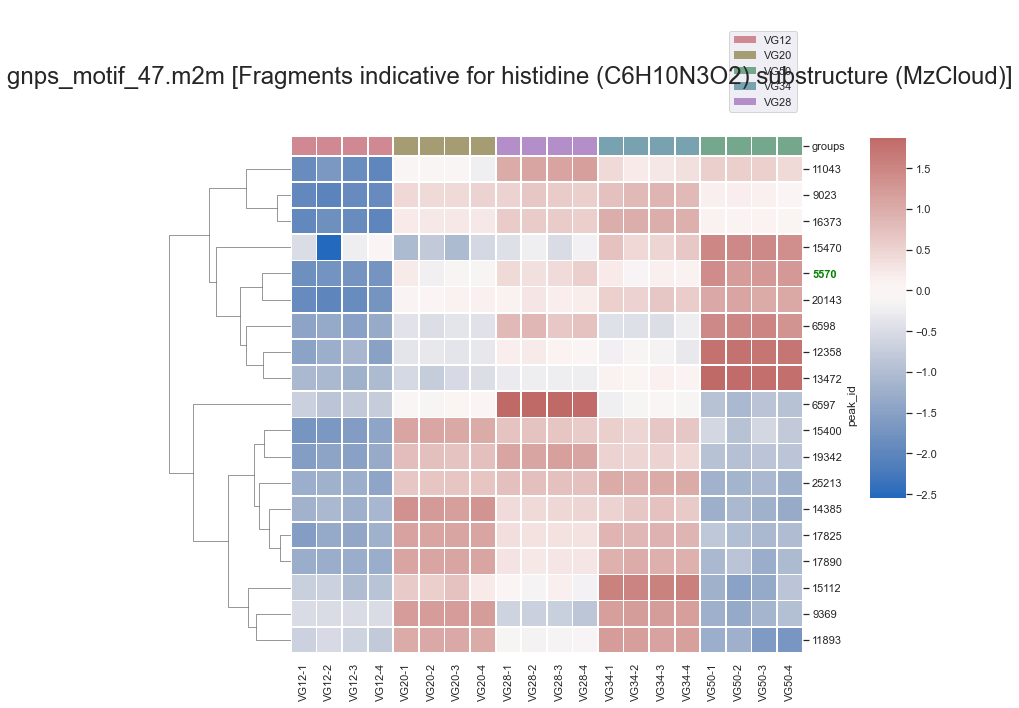

LibraryID  Precursor m/z  RTConsensus  \
id                                                                         
5570   Spectral Match to His-Pro from NIST14       235.1189        1.397   
6597                                     NaN       251.1490        2.282   
6598                                     NaN       251.1493        1.658   
9023                                     NaN       285.1345        2.342   
9369                                     NaN       289.6872        8.399   
11043                                    NaN       311.1714        3.785   
11893                                    NaN       321.1727        3.957   
12358                                    NaN       327.1655        2.051   
13472                                    NaN       341.1812        4.119   
14385                                    NaN       353.1814        2.108   
15112                                    NaN       363.2005        5.517   
15400                                    NaN       367.1975        3.593   
15470                                    NaN       368.2262        2.520   
16373                                    NaN       380.1926        4.158   
17825                                    NaN       401.2340        4.064   
17890                                    NaN       401.7336        3.890   
19342                                    NaN       424.2581       10.164   
20143                                    NaN       437.2130        3.631   
25213                                    NaN       544.2123        3.631   

       PrecursorInt  no_spectra  \
id                                
5570      7523501.0          20   
6597       450906.0          20   
6598      3667599.0          20   
9023      2931881.0          20   
9369        63433.0          16   
11043      101716.0          20   
11893      285631.0          20   
12358      253369.0          20   
13472      590443.0          20   
14385      207048.0          20   
15112       81650.0          20   
15400      296737.0          20   
15470       83298.0          20   
16373      343839.0          20   
17825      312284.0          20   
17890      163075.0          16   
19342       98646.0          20   
20143      132957.0          20   
25213      504545.0          20   

                                                                                                                                         link  
id                                                                                                                                             
5570    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=844&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6597    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=844&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6598    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=844&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9023    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=844&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9369    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=891&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11043   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=197&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11893   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=592&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12358   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=197&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13472   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=197&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
14385   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=756&task=30a1f92e87a047b58ee

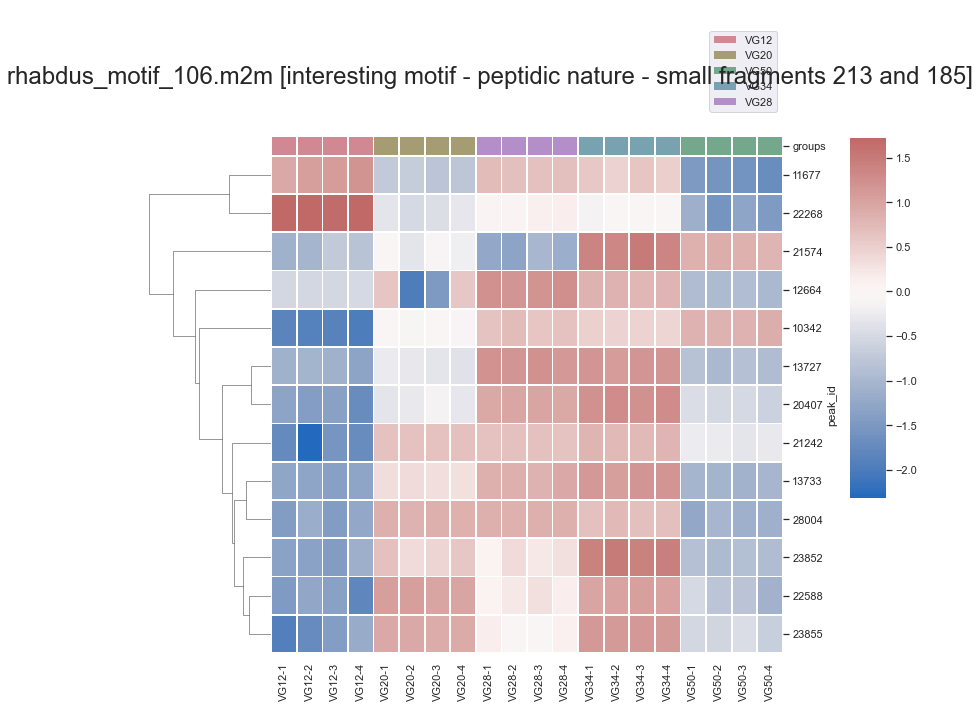

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
10342        NaN       302.2087        2.694      684190.0          20   
11677        NaN       318.2004        1.735     2175755.0          20   
12664        NaN       330.2379        6.984     2761708.0          20   
13727        NaN       344.2531       10.867     3027377.0          20   
13733        NaN       344.2549       11.438     7001336.0          20   
20407        NaN       441.3090       13.533      154278.0          20   
21242        NaN       457.3383       14.635      151624.0          20   
21574        NaN       464.2602        2.372      208299.0          20   
22268        NaN       477.3084       19.631      139399.0          20   
22588        NaN       484.3118        9.802       62470.0          20   
23852        NaN       512.3426       11.949       41901.0          20   
23855        NaN       512.3433       11.709      135329.0          20   
28004        NaN       626.3854        8.069       85616.0          18   

                                                                                                                                        link  
id                                                                                                                                            
10342  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=835&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11677  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=703&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12664  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=703&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13727  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=711&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13733  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=703&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
20407  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=563&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
21242  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=752&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
21574   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=95&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
22268  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=805&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
22588  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=971&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
23852  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=563&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
23855  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=563&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
28004  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=808&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

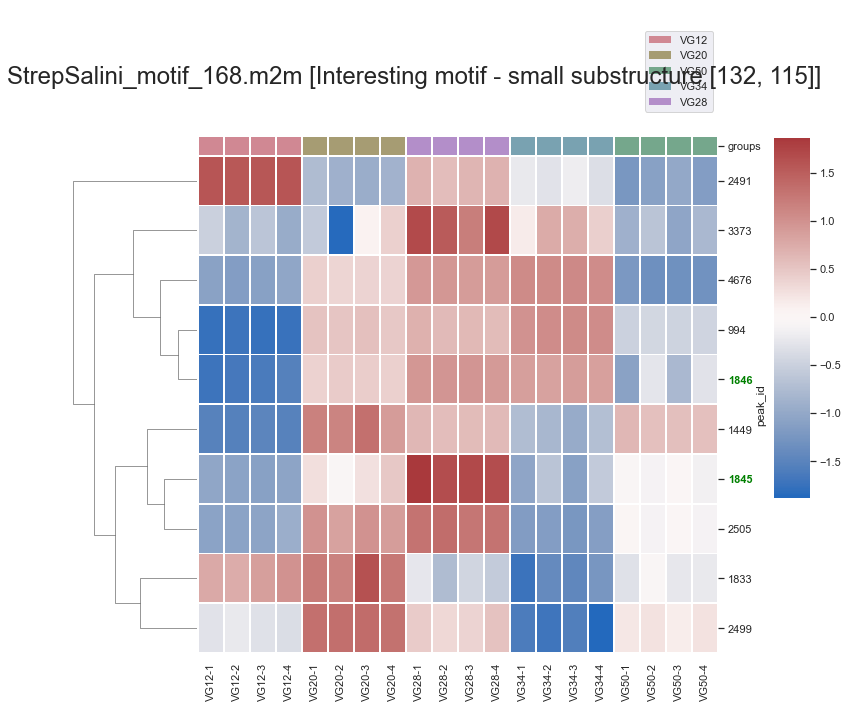

LibraryID  Precursor m/z  RTConsensus  \
id                                                                           
994                                        NaN       144.0792        4.834   
1449                                       NaN       158.0885        6.819   
1833                                       NaN       169.0463        4.895   
1845  Spectral Match to Norharmane from NIST14       169.0756        6.903   
1846  Spectral Match to Norharmane from NIST14       169.0758        6.747   
2491                                       NaN       183.0630        9.672   
2499                                       NaN       183.0890        5.855   
2505                                       NaN       183.0917        8.957   
3373                                       NaN       198.1136       13.451   
4676                                       NaN       221.0810       12.983   

      PrecursorInt  no_spectra  \
id                               
994      3076353.0          20   
1449     1135207.0          20   
1833      164066.0          20   
1845      977427.0          20   
1846     2804538.0          20   
2491      147290.0          20   
2499      193080.0          20   
2505    10071656.0          20   
3373       39331.0          20   
4676      418871.0          20   

                                                                                                                                        link  
id                                                                                                                                            
994     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=46&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1449    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=46&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1833   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=206&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1845   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=206&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1846   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=206&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2491  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1529&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2499  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1529&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2505   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=206&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3373   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=246&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4676  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1965&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

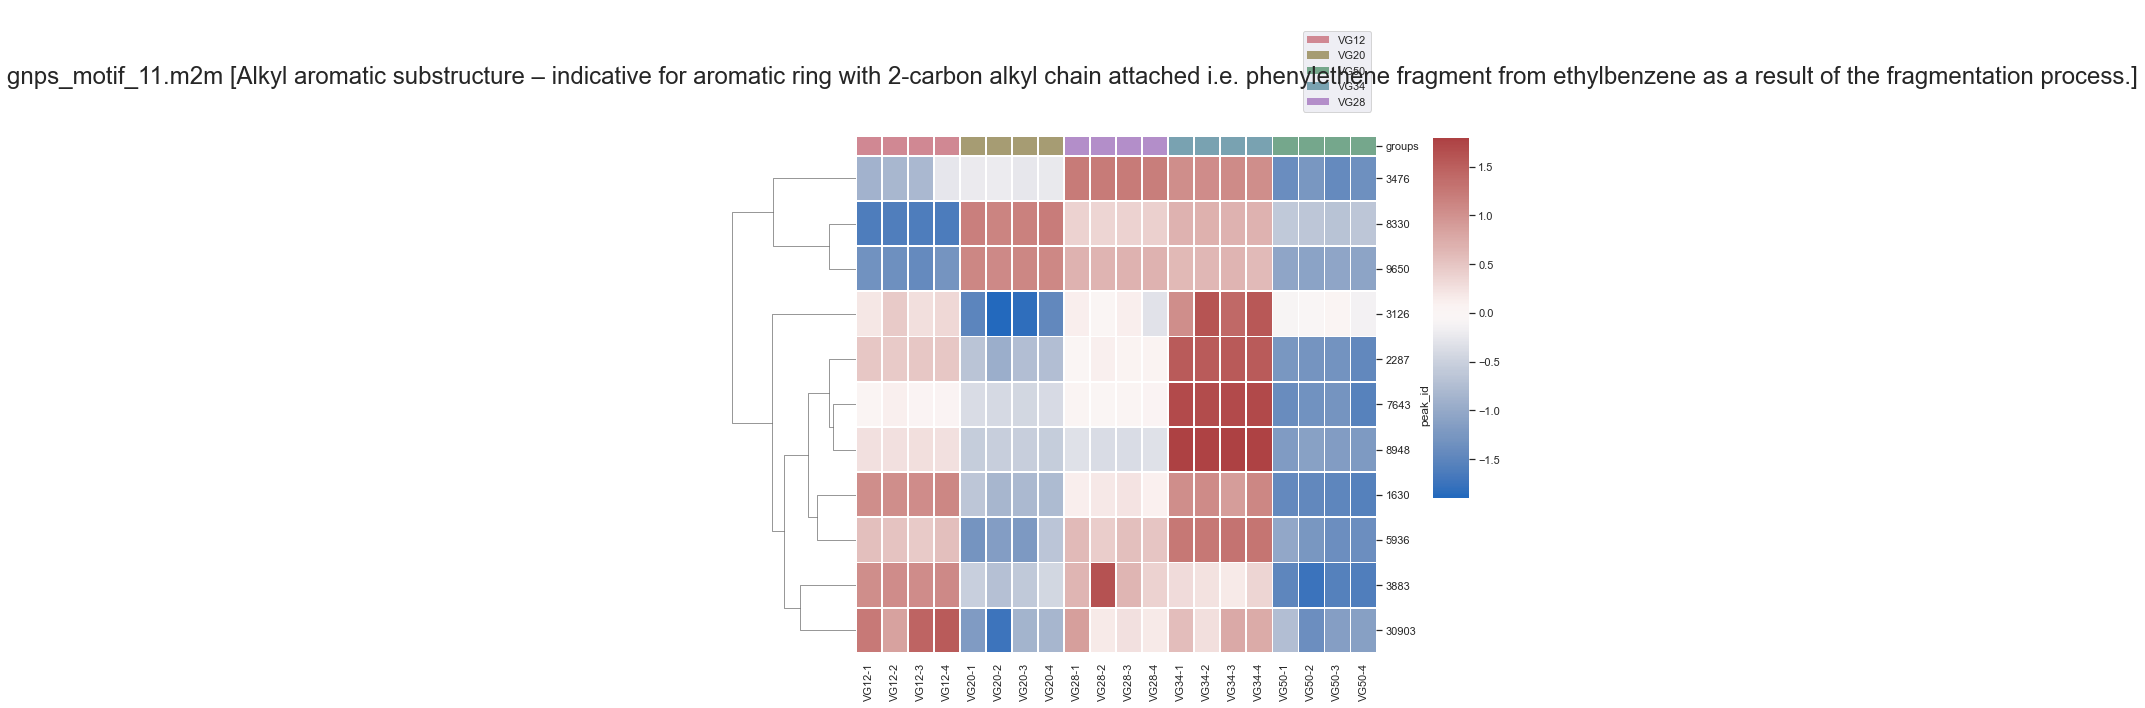

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
1630         NaN       164.1052       11.775      171813.0          20   
2287         NaN       178.1224        3.691      208348.0          20   
3126         NaN       194.1171       11.958      136202.0          20   
3476         NaN       200.1080        6.628     2937616.0          20   
3883         NaN       208.1325       11.807      115469.0          20   
5936         NaN       241.1711       13.273       51604.0          20   
7643         NaN       266.1388        2.548      636383.0          20   
8330         NaN       275.1988       19.076      243854.0          20   
8948         NaN       284.1487        2.565     2892682.0          20   
9650         NaN       293.2101       19.330      279437.0          20   
30903        NaN       760.4654       30.921       51071.0          20   

                                                                                                                                         link  
id                                                                                                                                             
1630     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2287     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3126     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3476     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3883     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5936   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1568&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7643    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=929&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8330     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=76&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8948    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=929&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9650     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=76&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
30903  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1151&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

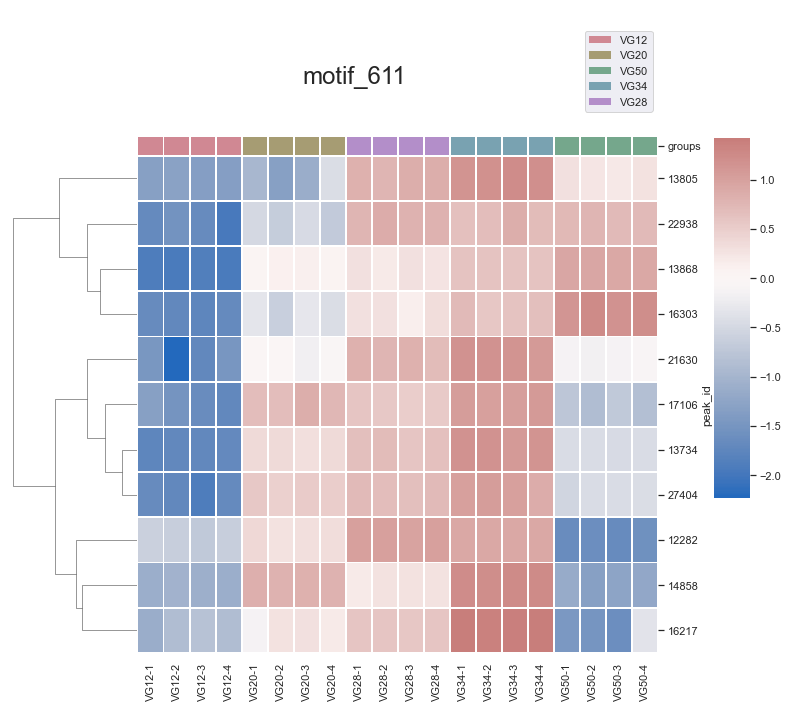

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
12282        NaN       326.1696        5.708      858516.0          20   
13734        NaN       344.2560       12.143     3336889.0          20   
13805        NaN       345.2142        5.792      495743.0          20   
13868        NaN       346.1964        6.803      787954.0          20   
14858        NaN       359.2690       20.649      553222.0          20   
16217        NaN       378.1673        1.803      339541.0          20   
16303        NaN       379.1956        8.903      159019.0          20   
17106        NaN       390.2114        1.504      657508.0          20   
21630        NaN       465.2705        9.079      177471.0          20   
22938        NaN       491.2946        3.482      120978.0          20   
27404        NaN       606.3496        9.213      167573.0          20   

                                                                                                                                         link  
id                                                                                                                                             
12282   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=208&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13734   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=752&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13805    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=61&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13868   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=205&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
14858   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=710&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
16217  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1651&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
16303  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1614&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
17106   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=962&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
21630    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=22&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
22938  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1493&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
27404   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=165&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

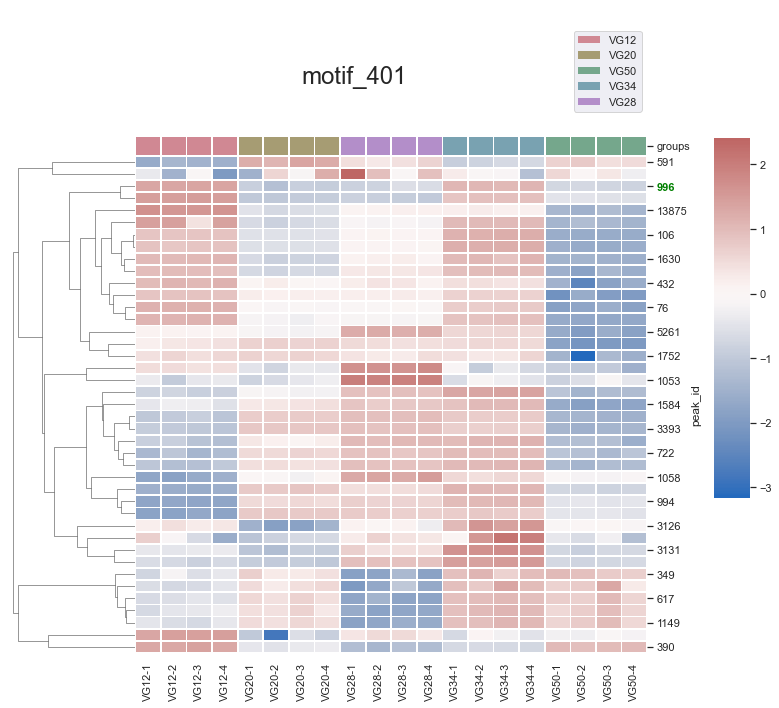

LibraryID  Precursor m/z  \
id                                                                             
76                                                        NaN       103.0541   
77                                                        NaN       103.0541   
80                                                        NaN       103.0543   
106                                                       NaN       105.0696   
111                                                       NaN       105.0905   
349                                                       NaN       119.7066   
390                                                       NaN       121.0641   
391                                                       NaN       121.0641   
421                                                       NaN       122.0955   
432                                                       NaN       123.0431   
582                                                       NaN       130.0477   
591                                                       NaN       130.0631   
593                                                       NaN       130.0638   
603                                                       NaN       130.1222   
617                                                       NaN       131.0491   
721                                                       NaN       135.0439   
722                                                       NaN       135.0442   
994                                                       NaN       144.0792   
996    Spectral Match to 3-(2-Hydroxyethyl)indole from NIST14       144.0794   
1053                                                      NaN       146.0571   
1058                                                      NaN       146.0595   
1149                                                      NaN       149.0591   
1584                                                      NaN       163.0389   
1630                                                      NaN       164.1052   
1681                                                      NaN       165.5628   
1752                                                      NaN       167.0690   
3018                                                      NaN       192.1366   
3103                                                      NaN       194.0819   
3120                                                      NaN       194.1162   
3126                                                      NaN       194.1171   
3131                                                      NaN       194.1182   
3393                                                      NaN       199.0401   
3837                                                      NaN       207.1380   
4743                                                      NaN       222.1477   
5102                                                      NaN       228.1018   
5261                                                      NaN       230.1158   
5353                                                      NaN       231.1502   
5921                                                      NaN       241.1422   
6721                                                      NaN       253.1325   
10802                                                     NaN       308.1652   
13875                                                     NaN       346.2116   

       RTConsensus  PrecursorInt  no_spectra  \
id                                             
76           1.502     1205060.0          20   
77           1.962     3489214.0          20   
80           1.565     1189100.0          20   
106          2.752     9992740.0          20   
111          2.874       65487.0          20   
349          1.962      565821.0          20   
390          3.698      615698.0          20   
391          9.039      427469.0          20   
421          2.752     4056511.0          20   
432          2.853      123303.0          20   
582         31.162      110227.0   

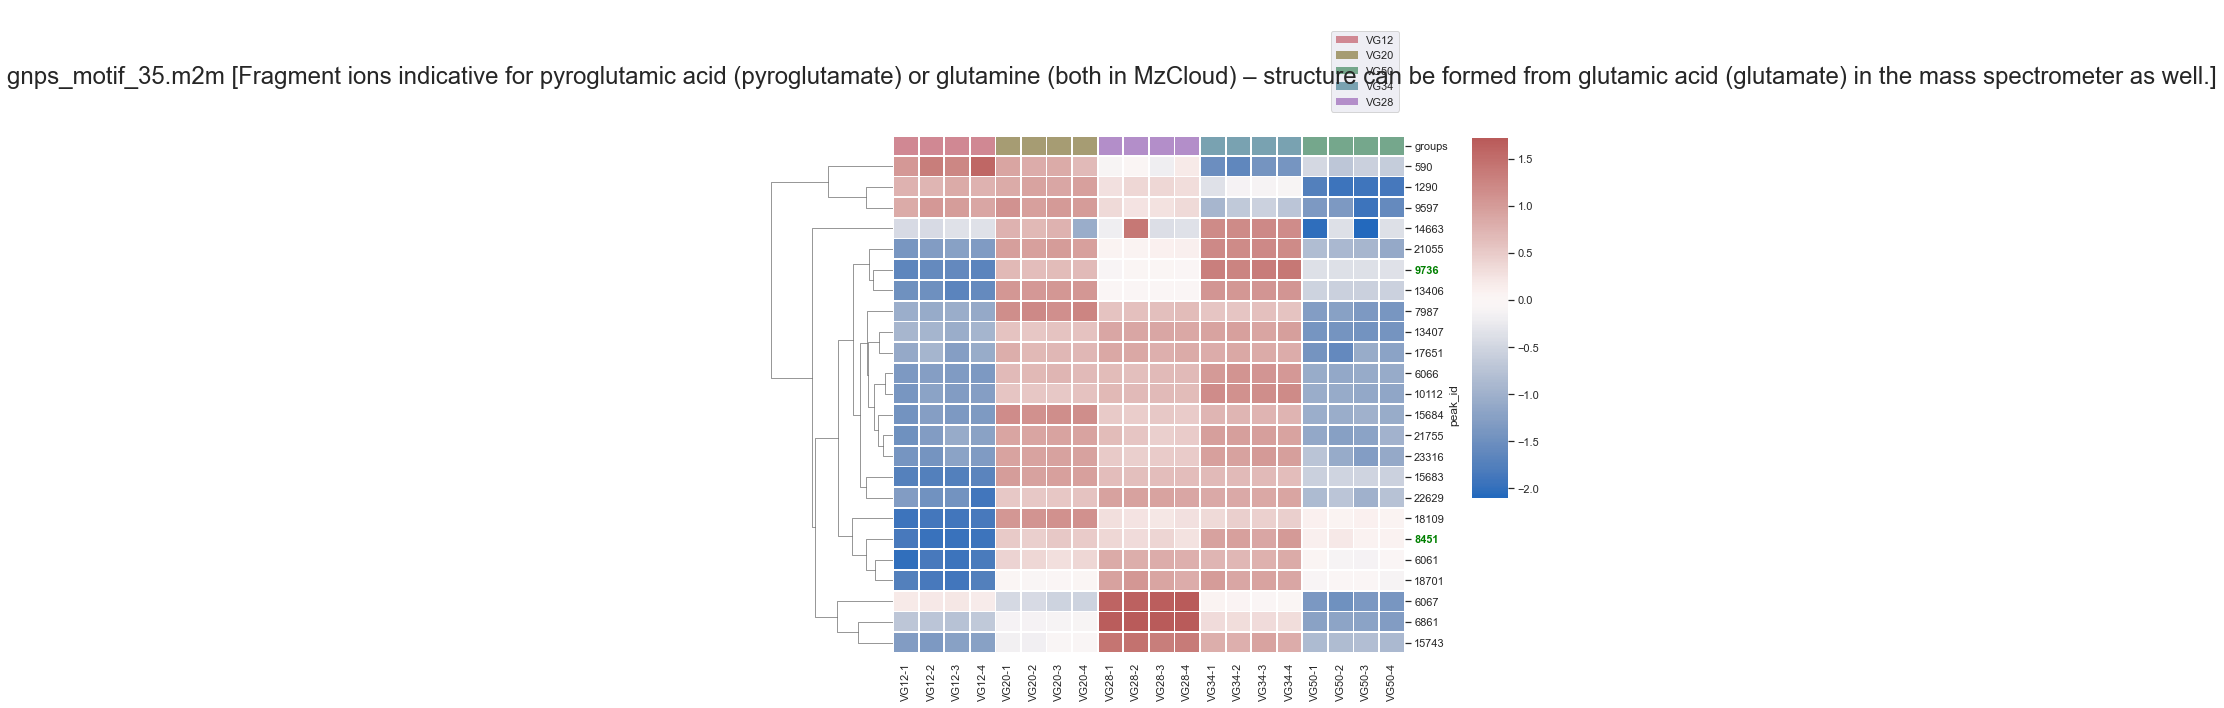

LibraryID  Precursor m/z  RTConsensus  \
id                                                                             
590                                          NaN       130.0500        1.478   
1290                                         NaN       154.0854        2.177   
6061                                         NaN       243.1325        7.189   
6066                                         NaN       243.1338        5.788   
6067                                         NaN       243.1340        4.323   
6861                                         NaN       255.1329        7.664   
7987                                         NaN       271.1636       14.417   
8451   Spectral Match to PyroGlu-Phe from NIST14       277.1189        9.217   
9597                                         NaN       293.1096        2.906   
9736       Spectral Match to Glu Phe from METLIN       295.1279        4.045   
10112                                        NaN       300.1553        5.328   
13406                                        NaN       340.1871        9.028   
13407                                        NaN       340.1879        9.998   
14663                                        NaN       357.1766        5.082   
15683                                        NaN       371.1921        6.077   
15684                                        NaN       371.1921        5.371   
15743                                        NaN       372.1762        3.859   
17651                                        NaN       399.2012        9.056   
18109                                        NaN       405.1778        7.755   
18701                                        NaN       415.1815        2.347   
21055                                        NaN       454.2286        2.973   
21755                                        NaN       468.2405        8.457   
22629                                        NaN       485.2696        2.211   
23316                                        NaN       500.2323        6.320   

       PrecursorInt  no_spectra  \
id                                
590      10780196.0          20   
1290       706607.0          20   
6061     16780392.0          20   
6066      8579400.0          20   
6067      2477899.0          20   
6861      2924285.0          20   
7987       634756.0          20   
8451      9658780.0          20   
9597       201219.0          20   
9736       436388.0          20   
10112      297391.0          20   
13406     5529322.0          20   
13407     4010046.0          20   
14663      156822.0          20   
15683     2132781.0          20   
15684      588845.0          20   
15743      749067.0          20   
17651      133154.0          20   
18109     1144535.0          20   
18701      205242.0          20   
21055      608490.0          20   
21755      268715.0          20   
22629      380908.0          20   
23316       86266.0          20   

                                                                                                                                         link  
id                                                                                                                                             
590      https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=13&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1290    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=123&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6061    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=389&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6066    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=389&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6067    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=389&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6861    https://gnps.ucsd.edu/ProteoSAF

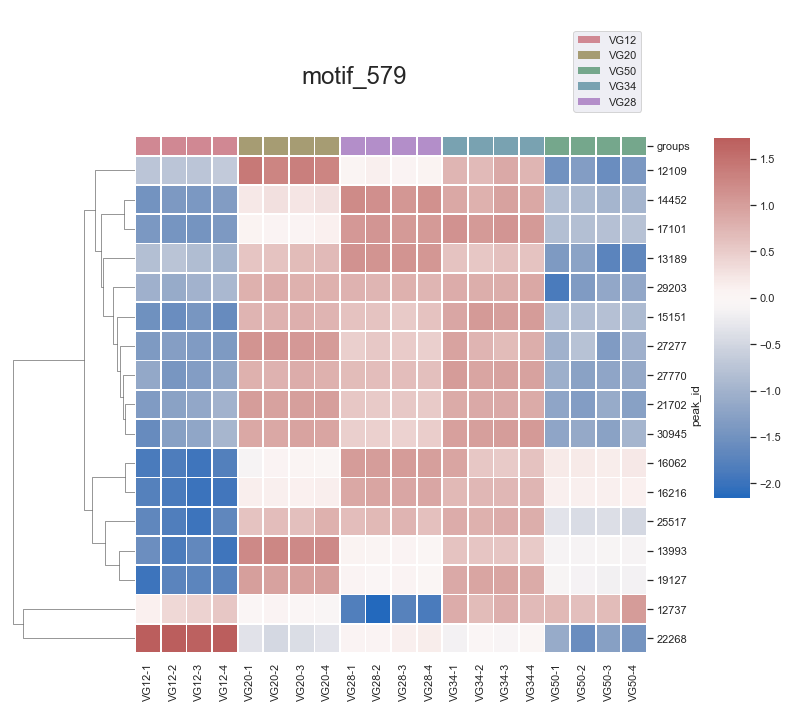

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
12109        NaN       324.1557        3.408      859334.0          20   
12737        NaN       331.1635        1.948      872133.0          20   
13189        NaN       337.1753       14.999       63724.0          20   
13993        NaN       348.1550        9.102      340845.0          20   
14452        NaN       354.1639        3.593      201159.0          20   
15151        NaN       364.1514        7.808      455914.0          20   
16062        NaN       376.1846       12.455      737098.0          20   
16216        NaN       378.1653        8.721     1011316.0          20   
17101        NaN       390.2025       14.533     1041882.0          20   
19127        NaN       421.1732        6.458      234248.0          20   
21702        NaN       467.1764        4.580      124494.0          20   
22268        NaN       477.3084       19.631      139399.0          20   
25517        NaN       552.2648        3.008      332957.0          20   
27277        NaN       603.3003       10.843      102981.0          19   
27770        NaN       618.2903       10.885      404267.0          20   
29203        NaN       675.3694       10.919      196763.0          20   
30945        NaN       764.3619       10.920      209034.0          19   

                                                                                                                                         link  
id                                                                                                                                             
12109  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=2211&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12737    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13189   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=371&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13993  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1121&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
14452   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=120&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
15151   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=571&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
16062   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=987&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
16216   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=571&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
17101   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=273&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
19127   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=413&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
21702   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=448&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
22268   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=805&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
25517   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=904&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
27277   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=118&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
27770   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=118&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
29203   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=165&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
30945   

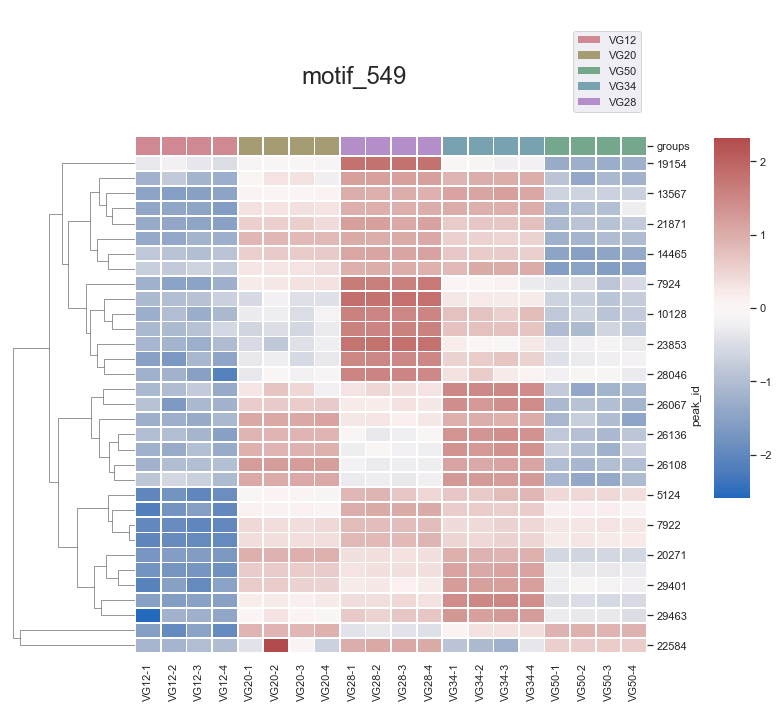

LibraryID  Precursor m/z  RTConsensus  \
id                                                                             
5124                                         NaN       228.1714        1.594   
7922                                         NaN       270.1910        2.219   
7923                                         NaN       270.1929        2.358   
7924                                         NaN       270.1932        2.890   
10128                                        NaN       300.1913        2.244   
10662                                        NaN       306.1799        1.977   
13567                                        NaN       342.2377       10.509   
13568  Spectral Match to Ile-Pro-Ile from NIST14       342.2377       10.833   
14465                                        NaN       354.2008       13.532   
14902                                        NaN       360.1936        6.429   
16752                                        NaN       385.2435        4.423   
17253                                        NaN       392.2207        6.949   
17673                                        NaN       399.2591        7.805   
19154                                        NaN       421.2784        8.603   
19155                                        NaN       421.2785        7.864   
19292                                        NaN       423.2584        4.610   
20271                                        NaN       439.2911       12.367   
20400                                        NaN       441.3046       13.010   
21871                                        NaN       470.2942        7.835   
22584                                        NaN       484.3098       11.190   
23853                                        NaN       512.3432       15.036   
23857                                        NaN       512.3461       13.898   
26067                                        NaN       566.2822       10.894   
26108                                        NaN       567.3486       10.359   
26136                                        NaN       568.3328       10.913   
26185                                        NaN       569.3660       11.280   
27745                                        NaN       617.3291        8.418   
28046                                        NaN       627.3670       12.571   
28390                                        NaN       640.3996       13.820   
29266                                        NaN       678.3812       13.704   
29401                                        NaN       683.4677       10.823   
29463                                        NaN       685.4893       10.817   
31087                                        NaN       773.4529       15.932   

       PrecursorInt  no_spectra  \
id                                
5124      1177726.0          20   
7922     10778659.0          20   
7923      4873371.0          20   
7924       230882.0          20   
10128     1556731.0          20   
10662      215565.0          20   
13567     1435252.0          20   
13568     8023035.0          20   
14465      178785.0          20   
14902      223462.0          20   
16752      304648.0          20   
17253       55424.0          20   
17673      302895.0          20   
19154       65765.0          20   
19155     1092182.0          20   
19292      200400.0          20   
20271     1939786.0          20   
20400      452873.0          20   
21871       96297.0          20   
22584      254732.0          20   
23853       50696.0          20   
23857      123464.0          20   
26067      115820.0          20   
26108      166948.0          20   
26136      160350.0          20   
26185      136584.0          20   
27745      485879.0          20   
28046       26660.0          20   
28390       78004.0          19   
29266       36161.0          20   
29401      111165.0          20   
29463       77153.0          19   
31087      102918.0          20   

            

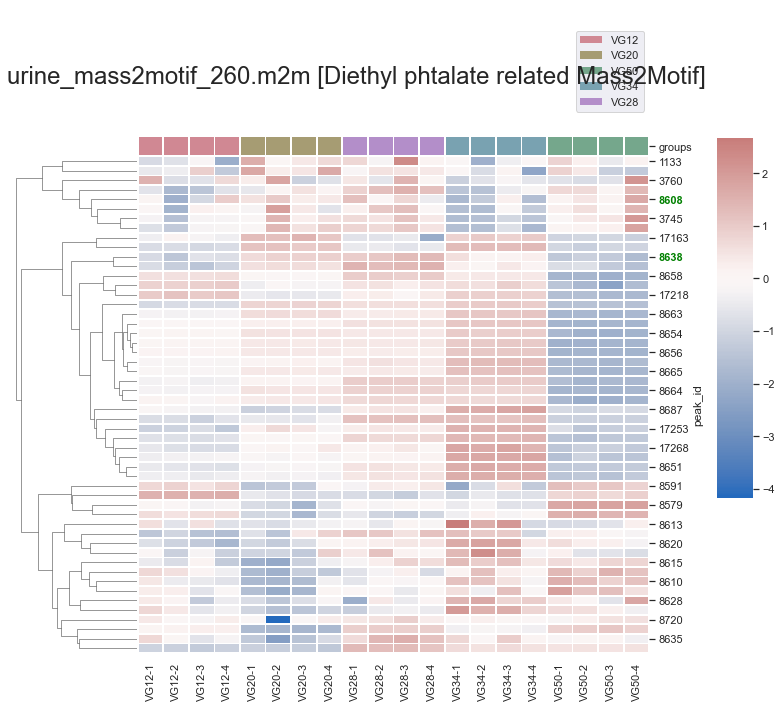

LibraryID  Precursor m/z  \
id                                                                      
1133                                               NaN       148.5534   
1147                                               NaN       149.0236   
3745                                               NaN       205.0860   
3760                                               NaN       205.1950   
8579                                               NaN       279.0189   
8591                                               NaN       279.0922   
8608                                   MoNA:936698 DBP       279.1574   
8609                                               NaN       279.1576   
8610                                               NaN       279.1576   
8613                                               NaN       279.1578   
8615                                               NaN       279.1579   
8620                                               NaN       279.1584   
8623                                               NaN       279.1584   
8625                                               NaN       279.1586   
8628                                               NaN       279.1596   
8630                                 Dibutyl phthalate       279.1599   
8632                                               NaN       279.1601   
8635                                               NaN       279.1604   
8638   Spectral Match to Dibutyl phthalate from NIST14       279.1676   
8639                                               NaN       279.1677   
8640                                               NaN       279.1684   
8641                                               NaN       279.1693   
8650                                               NaN       279.2299   
8651                                               NaN       279.2300   
8653                                               NaN       279.2305   
8654                                               NaN       279.2308   
8656                                               NaN       279.2310   
8657                                               NaN       279.2310   
8658                                               NaN       279.2316   
8659                                               NaN       279.2319   
8661                                               NaN       279.2320   
8662                                               NaN       279.2321   
8663                                               NaN       279.2323   
8664                                               NaN       279.2325   
8665                                               NaN       279.2330   
8666                                               NaN       279.2336   
8667                                               NaN       279.2350   
8668                                               NaN       279.2352   
8679                                               NaN       280.0056   
8687                                               NaN       280.0957   
8707                                               NaN       280.1562   
8720                                               NaN       280.2462   
12631                                              NaN       330.1816   
17163                                              NaN       391.1931   
17164                                              NaN       391.1937   
17180                                              NaN       391.2831   
17188  Spectral Match to Dioctyl phthalate from NIST14       391.2856   
17204                                              NaN       391.6622   
17217                                              NaN       392.1608   
17218                                              NaN       392.1632   
17253                                              NaN       392.2207   
17268                                              NaN       392.2978   

       RTConsensus  PrecursorInt  no_spectra  \
id                                             
1133  

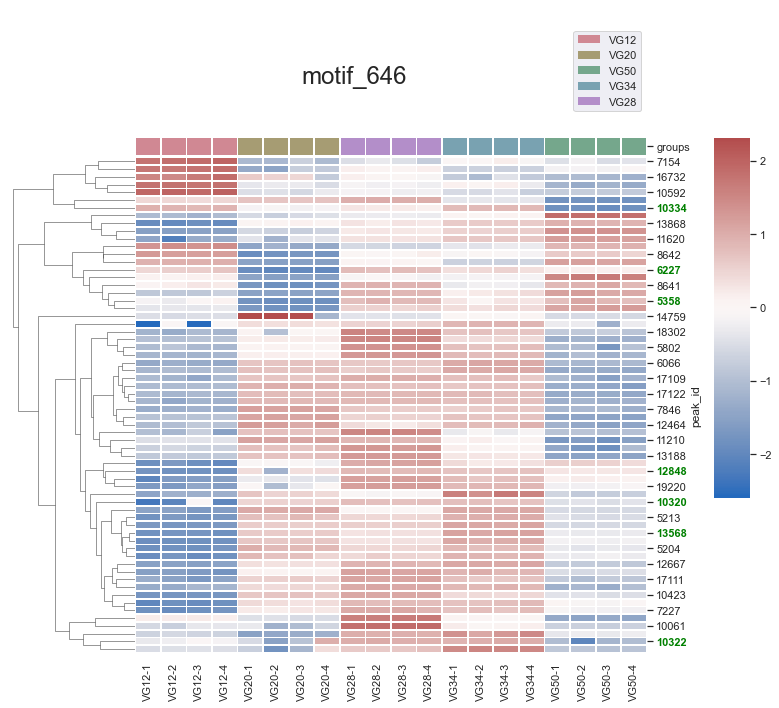

LibraryID  Precursor m/z  RTConsensus  \
id                                                                         
5204                                     NaN       229.1537        1.408   
5207                                     NaN       229.1538        5.169   
5210   Spectral Match to Pro-Ile from NIST14       229.1542        2.826   
5212   Spectral Match to Pro-Leu from NIST14       229.1548        2.428   
5213                                     NaN       229.1549        1.601   
...                                      ...            ...          ...   
18071                                    NaN       404.2387        7.923   
18302                                    NaN       408.2445       13.622   
18308                                    NaN       408.2470       12.303   
18819                                    NaN       416.2738       12.983   
19220                                    NaN       422.2657       15.546   

       PrecursorInt  no_spectra  \
id                                
5204      6300575.0          20   
5207       597962.0          20   
5210     38933764.0          20   
5212     33945412.0          20   
5213      3424563.0          20   
...             ...         ...   
18071       98156.0          20   
18302      113056.0          20   
18308      219669.0          20   
18819      957577.0          20   
19220       53295.0          20   

                                                                                                                                         link  
id                                                                                                                                             
5204    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=326&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5207   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1736&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5210     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=51&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5212     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=51&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5213    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=326&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
...                                                                                                                                       ...  
18071    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=10&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
18302   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=249&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
18308  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1069&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
18819   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=542&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
19220   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=249&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  

[64 rows x 6 columns]

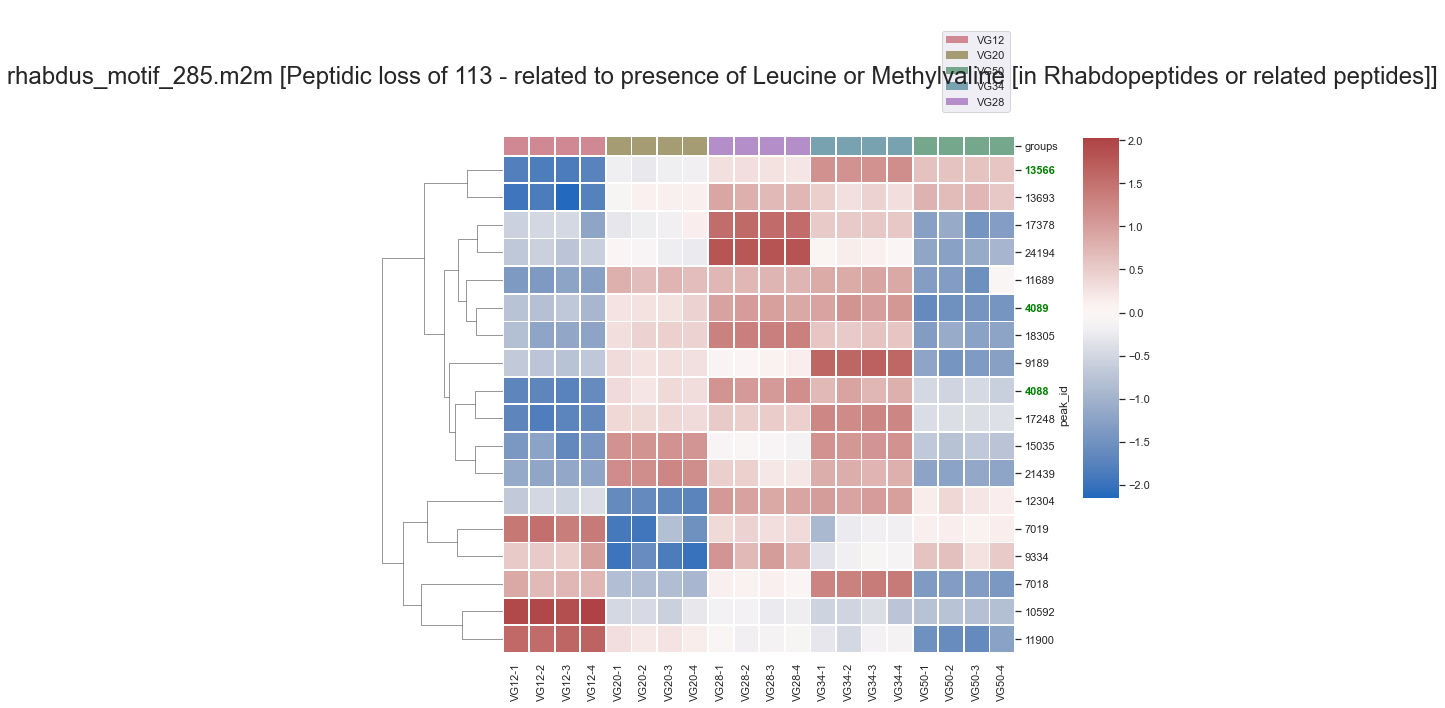

LibraryID  \
id                                                                                                 
4088   NCGC00169428-02!3-(2-methylpropyl)-2,3,6,7,8,8a-hexahydropyrrolo[1,2-a]pyrazine-1,4-dione   
4089   NCGC00169428-02!3-(2-methylpropyl)-2,3,6,7,8,8a-hexahydropyrrolo[1,2-a]pyrazine-1,4-dione   
7018                                                                                         NaN   
7019                                                                                         NaN   
9189                                                                                         NaN   
9334                                                                                         NaN   
10592                                                                                        NaN   
11689                                                                                        NaN   
11900                                                                                        NaN   
12304                                                                                        NaN   
13566                                                  Spectral Match to Ile-Pro-Ile from NIST14   
13693                                                                                        NaN   
15035                                                                                        NaN   
17248                                                                                        NaN   
17378                                                                                        NaN   
18305                                                                                        NaN   
21439                                                                                        NaN   
24194                                                                                        NaN   

       Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                            
4088        211.1435        8.944    47332366.0          20   
4089        211.1435        7.866    44023153.0          20   
7018        257.1858       11.002    12264761.0          20   
7019        257.1863       11.538     2997940.0          20   
9189        287.1970        7.467       65055.0          20   
9334        289.1740        7.701      279100.0          20   
10592       305.1855       13.712      169586.0          20   
11689       318.2030        6.776      204237.0          20   
11900       321.1804        6.378       37224.0          20   
12304       326.2075        2.597     1202410.0          20   
13566       342.2374       10.005     1168842.0          20   
13693       344.1804        2.043      429728.0          20   
15035       362.1682        9.022      844450.0          20   
17248       392.2181        6.389      194736.0          20   
17378       394.2307       14.879       97816.0          20   
18305       408.2465       16.892       84821.0          20   
21439       461.2350       12.340      240359.0          20   
24194       520.2733       14.595      144527.0          20   

                                                                                                                                         link  
id                                                                                                                                             
4088     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=24&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4089     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=24&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7018     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=51&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7019     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=51&task=30a1f9

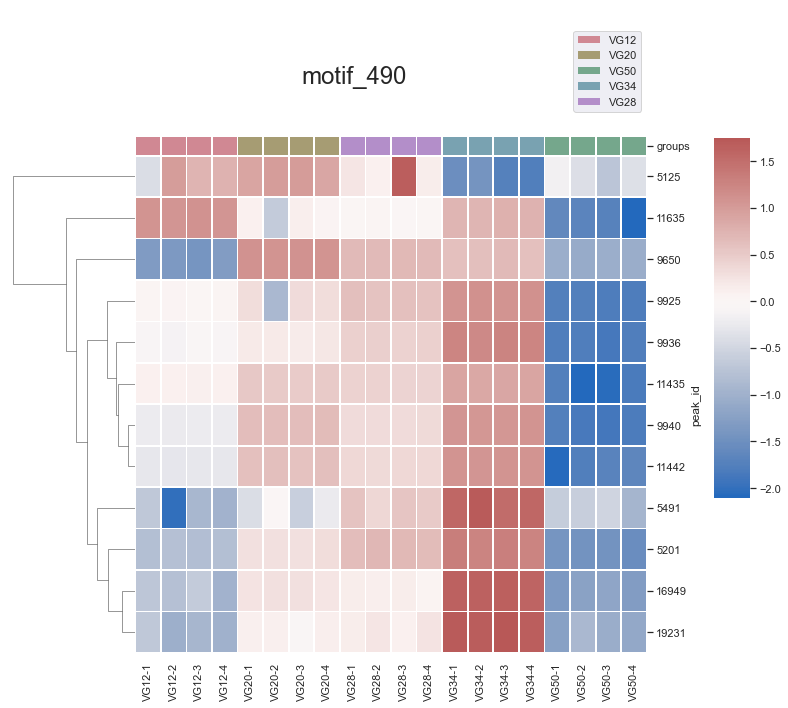

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
5125         NaN       228.1936       34.398      304675.0          20   
5201         NaN       229.1432       17.703     1377128.0          20   
5491         NaN       233.1746       13.804       41797.0          20   
9650         NaN       293.2101       19.330      279437.0          20   
9925         NaN       297.2408       21.929     1332375.0          20   
9936         NaN       297.2419       20.946     1257377.0          20   
9940         NaN       297.2427       21.456     6827872.0          20   
11435        NaN       315.2517       21.202     1207483.0          20   
11442        NaN       315.2527       21.464     5528787.0          20   
11635        NaN       317.2686       26.046       72175.0          20   
16949        NaN       387.2751       22.818       53206.0          20   
19231        NaN       422.3119       23.026       24622.0          20   

                                                                                                                                         link  
id                                                                                                                                             
5125     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=76&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5201    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=339&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5491   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1501&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9650     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=76&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9925     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=76&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9936     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=76&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9940     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=76&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11435   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=831&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11442    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=76&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11635    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=76&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
16949   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=831&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
19231   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=196&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

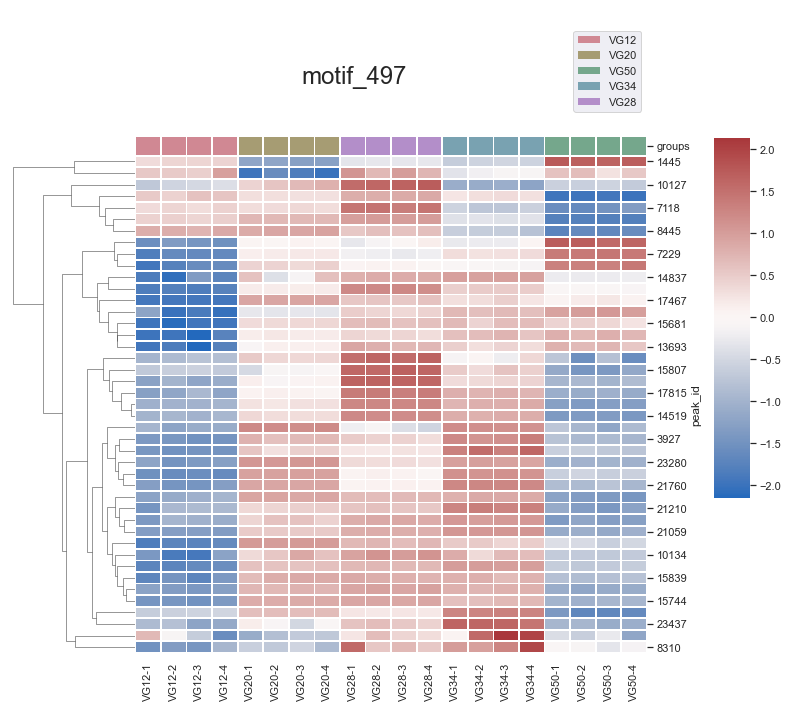

LibraryID  Precursor m/z  RTConsensus  \
id                                                                             
582                                          NaN       130.0477       31.162   
604                                          NaN       130.1222       10.459   
1445                                         NaN       158.0814        2.087   
3561                                         NaN       202.0711        2.341   
3927                                         NaN       209.0906        1.676   
5024   Spectral Match to PyroGlu-Pro from NIST14       227.1017        1.958   
5998                                         NaN       242.1476        2.854   
6065                                         NaN       243.1337        8.629   
7118                                         NaN       259.0926        1.474   
7229                                         NaN       260.1612        1.466   
8310                                         NaN       275.1605        3.807   
8445                                         NaN       277.1170        9.843   
9334                                         NaN       289.1740        7.701   
10116                                        NaN       300.1565        4.918   
10127                                        NaN       300.1912        7.664   
10134                                        NaN       300.1982        5.929   
11662                                        NaN       318.1646        2.591   
12286                                        NaN       326.1720        3.966   
13256                                        NaN       338.1471        1.464   
13333                                        NaN       339.1575        4.963   
13683                                        NaN       344.1447        2.050   
13693                                        NaN       344.1804        2.043   
14519                                        NaN       355.1604        1.763   
14837                                        NaN       359.2280        5.868   
15681                                        NaN       371.1908        3.501   
15744                                        NaN       372.1763        7.577   
15745                                        NaN       372.1766        4.614   
15807                                        NaN       373.1273       13.309   
15839                                        NaN       373.2421       13.322   
17467                                        NaN       395.7140        2.725   
17660                                        NaN       399.2232       13.313   
17815                                        NaN       401.2029        3.829   
18108                                        NaN       405.1765        5.756   
18152                                        NaN       406.1585        9.017   
21057                                        NaN       454.2292        5.301   
21059                                        NaN       454.2294        5.209   
21210                                        NaN       457.2285        2.819   
21760                                        NaN       468.2452        7.453   
22277                                        NaN       477.7128       11.655   
22580                                        NaN       484.2766       12.338   
22621                                        NaN       485.2583       13.531   
23280                                        NaN       499.2497        4.547   
23437                                        NaN       502.3182       10.318   

       PrecursorInt  no_spectra  \
id                                
582        110227.0          20   
604        216065.0          20   
1445      3793274.0          20   
3561       840033.0          20   
3927       899787.0          20   
5024     13669771.0          20   
5998       702213.0          20   
6065      1263724.0          20   
7118      3468325.0          20   
7229      4497672.0          20   
8310       487957.

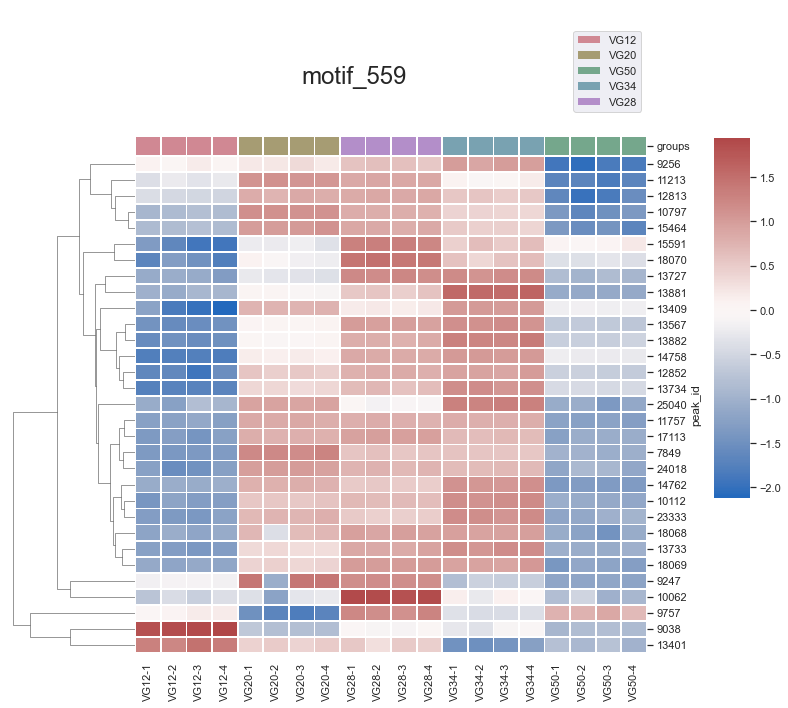

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
7849         NaN       269.1501        9.524      671071.0          20   
9038         NaN       285.1825        3.182      590219.0          20   
9247         NaN       288.1908        5.133     1398571.0          20   
9256         NaN       288.1930        6.307     2368111.0          20   
9757         NaN       295.1653        4.685      968413.0          20   
10062        NaN       299.2316       14.697       20334.0          20   
10112        NaN       300.1553        5.328      297391.0          20   
10797        NaN       308.1596        6.465       88378.0          20   
11213        NaN       313.1762       11.927      187473.0          20   
11757        NaN       319.1879        3.305      774461.0          20   
12813        NaN       332.1613       12.991       82458.0          20   
12852        NaN       332.2184        9.957     1680122.0          20   
13401        NaN       340.1657       21.151       48911.0          20   
13409        NaN       340.1883        8.303     3157298.0          20   
13567        NaN       342.2377       10.509     1435252.0          20   
13727        NaN       344.2531       10.867     3027377.0          20   
13733        NaN       344.2549       11.438     7001336.0          20   
13734        NaN       344.2560       12.143     3336889.0          20   
13881        NaN       346.2327        9.583      896815.0          20   
13882        NaN       346.2329       10.698     1689134.0          20   
14758        NaN       358.2699       13.069      818338.0          20   
14762        NaN       358.2711       12.510    11429662.0          20   
15464        NaN       368.2168       12.563      139534.0          20   
15591        NaN       370.1420       21.970       13409.0          20   
17113        NaN       390.2232       10.719      236748.0          20   
18068        NaN       404.2378       10.579      104912.0          20   
18069        NaN       404.2382        8.117       59521.0          20   
18070        NaN       404.2383       10.943       99626.0          20   
23333        NaN       500.2736       12.400      136050.0          20   
24018        NaN       516.2201        3.305      385744.0          20   
25040        NaN       540.3010       13.948      272822.0          20   

                                                                                                                                         link  
id                                                                                                                                             
7849     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=28&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9038    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=653&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9247    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=214&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9256    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=214&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9757    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=604&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10062  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1725&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10112    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=54&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10797   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=980&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11213   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=123&task=30a1f92e87a047b58ee8c0faf

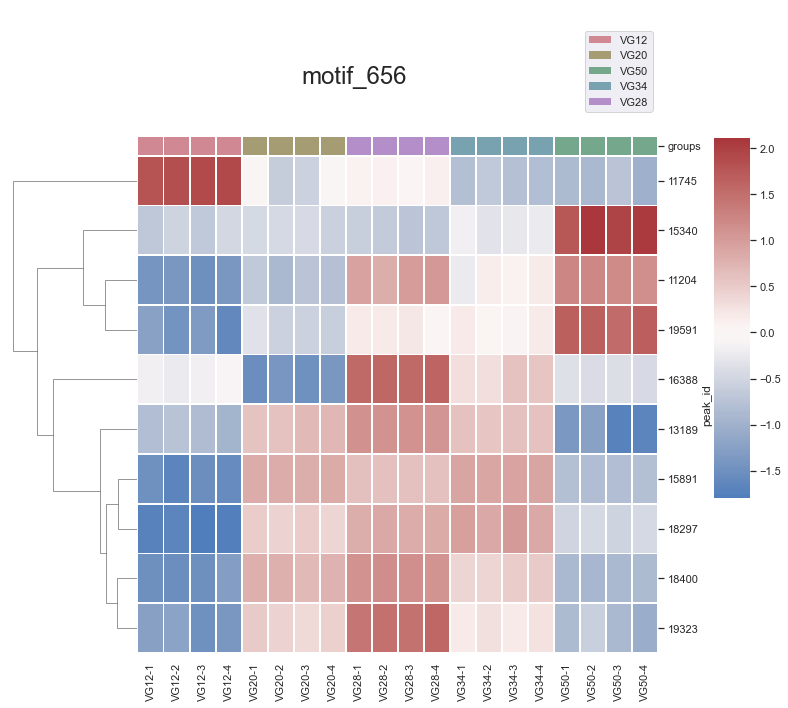

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
11204        NaN       313.1535       11.342      310668.0          20   
11745        NaN       319.1657        5.040      190193.0          20   
13189        NaN       337.1753       14.999       63724.0          20   
15340        NaN       366.2030       11.622     1938942.0          20   
15891        NaN       374.1713       10.924    14405805.0          20   
16388        NaN       380.2185       11.209      555037.0          20   
18297        NaN       408.2137       11.547      263462.0          20   
18400        NaN       410.1906        9.791      115745.0          20   
19323        NaN       424.1881        5.503      121188.0          20   
19591        NaN       428.1816       13.429       58089.0          20   

                                                                                                                                         link  
id                                                                                                                                             
11204  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1258&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11745   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=653&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13189   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=371&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
15340   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=825&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
15891   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=142&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
16388   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=620&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
18297   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=441&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
18400   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=561&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
19323    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=44&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
19591  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=2109&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

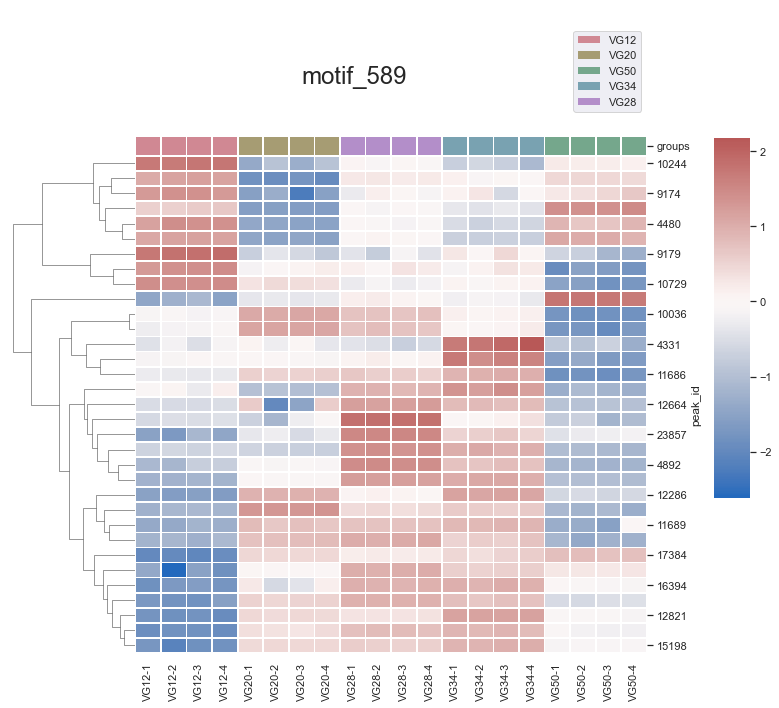

LibraryID  Precursor m/z  RTConsensus  \
id                                                                         
4331                                     NaN       215.1382        1.657   
4477                                     NaN       217.1544        3.715   
4480                                     NaN       217.1550        1.811   
4892                                     NaN       225.1229        3.328   
5363   Spectral Match to Leu-Val from NIST14       231.1711        2.393   
6859                                     NaN       255.1324        4.330   
7583                                     NaN       265.1545        3.934   
9047                                     NaN       285.2151       12.281   
9174                                     NaN       287.1939        3.965   
9179                                     NaN       287.1950        3.829   
9483                                     NaN       291.1691       11.235   
10036                                    NaN       299.1578        9.075   
10039                                    NaN       299.1599        8.583   
10244                                    NaN       301.2116        6.498   
10729                                    NaN       307.1657        3.445   
11515                                    NaN       316.2219        4.379   
11682                                    NaN       318.2015        2.623   
11686                                    NaN       318.2029        4.793   
11689                                    NaN       318.2030        6.776   
12030                                    NaN       323.1565        4.896   
12286                                    NaN       326.1720        3.966   
12358                                    NaN       327.1655        2.051   
12482                                    NaN       328.2230        6.469   
12663                                    NaN       330.2379        8.302   
12664                                    NaN       330.2379        6.984   
12821                                    NaN       332.1801        2.905   
13732                                    NaN       344.2548        9.881   
14905                                    NaN       360.2082        7.735   
14912                                    NaN       360.2121        6.721   
15198                                    NaN       364.2228       11.305   
16394                                    NaN       380.2191        5.803   
17384                                    NaN       394.2340        9.428   
23857                                    NaN       512.3461       13.898   

       PrecursorInt  no_spectra  \
id                                
4331     14624139.0          20   
4477       760245.0          20   
4480     16194913.0          20   
4892       679937.0          20   
5363     15058786.0          20   
6859       419624.0          20   
7583      3003645.0          20   
9047        28783.0          20   
9174        88334.0          20   
9179       157531.0          20   
9483        52916.0          20   
10036      470014.0          20   
10039      275200.0          20   
10244       71066.0          20   
10729      120629.0          20   
11515     3031485.0          20   
11682      826510.0          20   
11686     1266484.0          20   
11689      204237.0          20   
12030      132569.0          20   
12286     3791897.0          20   
12358      253369.0          20   
12482     1774274.0          20   
12663      387256.0          20   
12664     2761708.0          20   
12821      991746.0          20   
13732     1256519.0          20   
14905      339788.0          20   
14912      326329.0          20   
15198      274835.0          20   
16394      199225.0          20   
17384      240455.0          20   
23857      123464.0          20   

                                                                                                                                         link  
id  

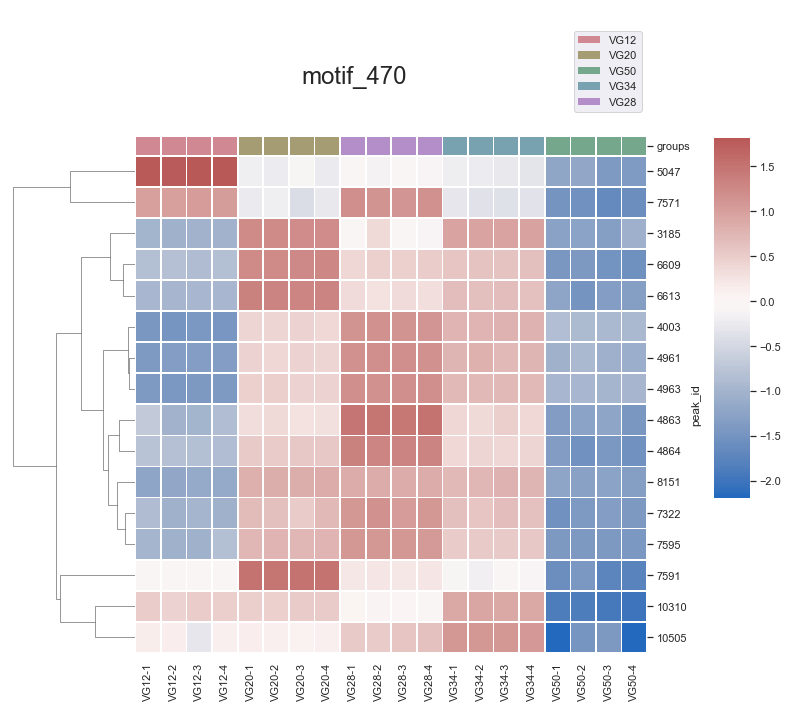

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
3185         NaN       195.1350       20.334      885696.0          20   
4003         NaN       210.1125        3.281     6529453.0          20   
4863         NaN       224.1274        8.392      142995.0          20   
4864         NaN       224.1277        5.374      295796.0          20   
4961         NaN       226.1070        4.502      546617.0          20   
4963         NaN       226.1071        5.223     1388957.0          20   
5047         NaN       227.1386        8.205      282357.0          20   
6609         NaN       251.1745       10.741      706531.0          20   
6613         NaN       251.1759       10.146      311463.0          20   
7322         NaN       261.1574       13.891       64087.0          20   
7571         NaN       265.1283        8.235      143931.0          20   
7591         NaN       265.1891       12.303      500183.0          20   
7595         NaN       265.1904       11.723      908268.0          20   
8151         NaN       273.1588       11.222      691097.0          20   
10310        NaN       302.1755       25.014      444076.0          20   
10505        NaN       304.1528       15.581       26561.0          20   

                                                                                                                                        link  
id                                                                                                                                            
3185    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=76&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4003   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=202&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4863   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=202&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4864   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=202&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4961   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=486&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4963   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=202&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5047   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=478&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6609   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=260&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6613   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=260&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7322   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=260&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7571   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=601&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7591   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=260&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7595   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=260&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8151   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=260&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10310  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=139&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10505  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=442&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

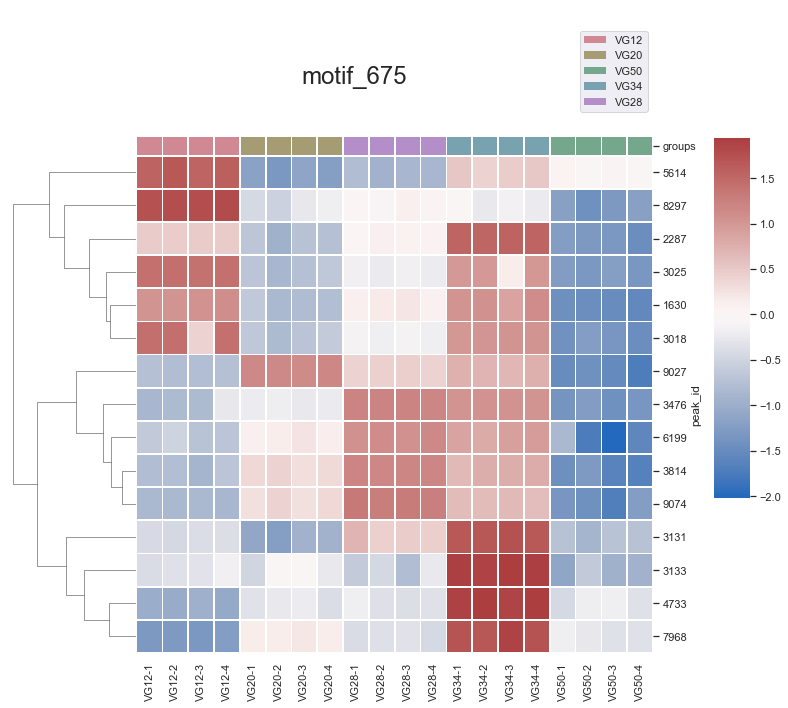

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                      
1630        NaN       164.1052       11.775      171813.0          20   
2287        NaN       178.1224        3.691      208348.0          20   
3018        NaN       192.1366        4.864     1070700.0          20   
3025        NaN       192.1389        4.959     1215659.0          20   
3131        NaN       194.1182        3.669      181246.0          20   
3133        NaN       194.1540        5.501      251841.0          20   
3476        NaN       200.1080        6.628     2937616.0          20   
3814        NaN       207.0647        9.293      141821.0          20   
4733        NaN       222.1116        2.479      847442.0          20   
5614        NaN       236.1279        3.212     2002955.0          20   
6199        NaN       245.1274        9.208      180944.0          20   
7968        NaN       271.1083        3.372      213506.0          20   
8297        NaN       275.1388       12.217      239820.0          20   
9027        NaN       285.1581       12.419      337673.0          20   
9074        NaN       286.1081        9.835       99589.0          20   

                                                                                                                                        link  
id                                                                                                                                            
1630    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2287    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3018    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3025    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3131    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3133    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3476    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3814  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1814&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4733  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1301&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5614  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1301&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6199    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=23&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7968    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=23&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8297    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=23&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9027   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=260&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9074    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=23&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

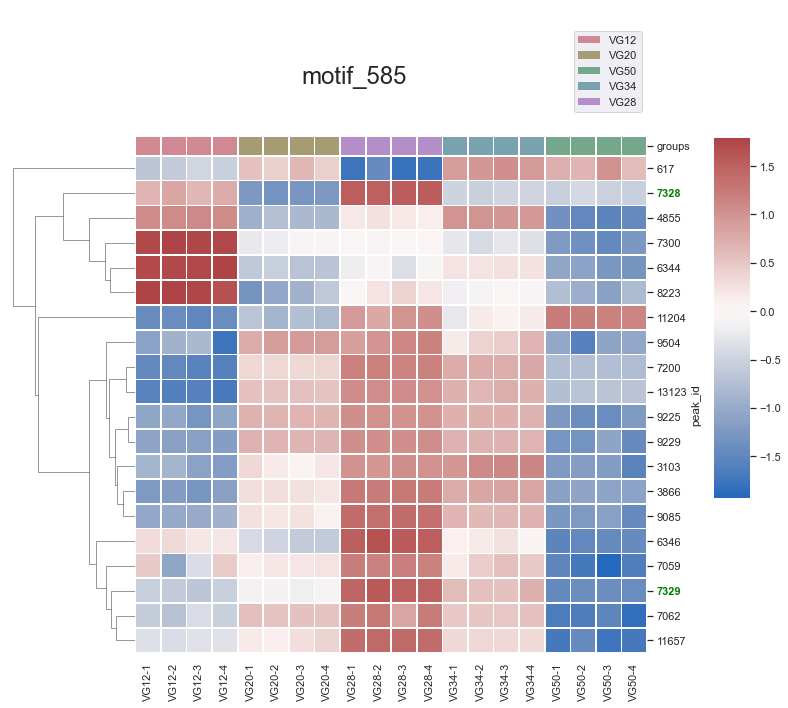

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                            
617               NaN       131.0491        1.962     2184143.0          20   
3103              NaN       194.0819        8.843       92596.0          20   
3866              NaN       208.0965        9.922     1752591.0          20   
4855              NaN       224.1254        3.893      245601.0          20   
6344              NaN       247.1432        8.161      311611.0          20   
6346              NaN       247.1446       13.381     5403305.0          20   
7059              NaN       258.1114       10.373       86846.0          20   
7062              NaN       258.1119        8.653      160294.0          20   
7200              NaN       260.0901        7.751      338595.0          20   
7300              NaN       261.1234       10.934      362636.0          20   
7328   cyclo(Phe-Leu)       261.1600       15.646     4465653.0          20   
7329   cyclo(Phe-Leu)       261.1600       15.437     4179367.0          20   
8223              NaN       274.1440       10.780       58027.0          20   
9085              NaN       286.1417       15.312       69848.0          20   
9225              NaN       288.1218        8.892      394621.0          20   
9229              NaN       288.1232        9.315      457074.0          20   
9504              NaN       291.2292       13.382       22833.0          20   
11204             NaN       313.1535       11.342      310668.0          20   
11657             NaN       318.1478       11.998       96853.0          20   
13123             NaN       336.1914       10.959     1581416.0          20   

                                                                                                                                         link  
id                                                                                                                                             
617      https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3103    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=957&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3866     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4855     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6344    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=362&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6346    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=181&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7059     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=23&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7062     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=23&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7200     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=23&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7300     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=23&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7328    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=181&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7329    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=181&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8223     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9085     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=23&task=30a1f92e87a047

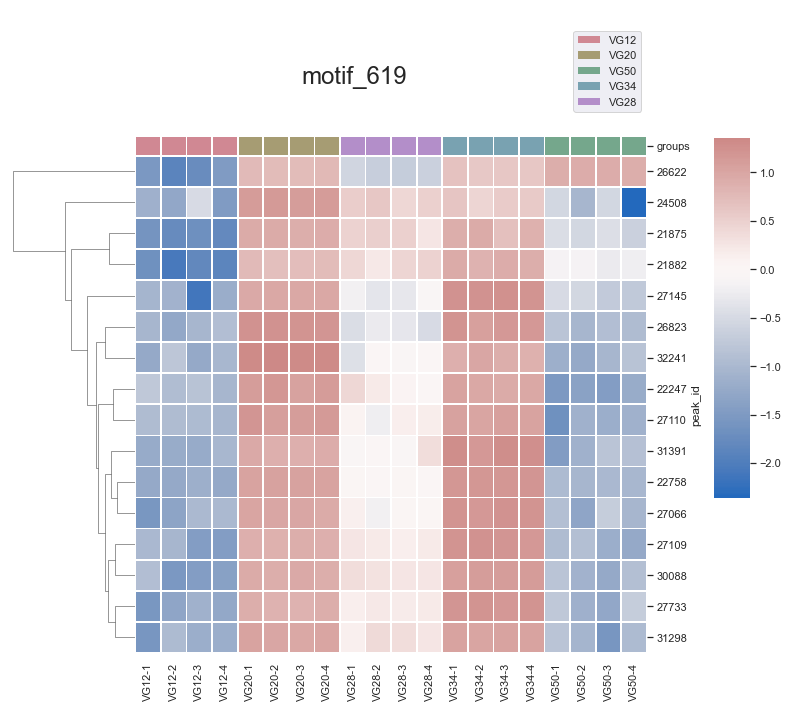

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
21875        NaN       470.2963        6.526      491203.0          20   
21882        NaN       470.3072        3.476      527455.0          20   
22247        NaN       477.2167       10.839      138172.0          20   
22758        NaN       488.2479        4.832      581623.0          20   
24508        NaN       527.3157        3.590       36736.0          20   
26622        NaN       583.3820       12.109      156332.0          20   
26823        NaN       589.7724       11.350      131708.0          19   
27066        NaN       597.2897        7.027       87325.0          20   
27109        NaN       598.3546       10.183       35844.0          20   
27110        NaN       598.3546        3.745       45276.0          19   
27145        NaN       599.3378        3.886      107358.0          20   
27733        NaN       617.2903        6.743      143918.0          20   
30088        NaN       714.3456        8.959      153218.0          20   
31298        NaN       791.3901       10.530       59404.0          20   
31391        NaN       799.3607       11.040       46372.0          20   
32241        NaN       893.4727       12.634       40011.0          18   

                                                                                                                                         link  
id                                                                                                                                             
21875     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=5&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
21882   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=836&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
22247  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1102&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
22758    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=41&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
24508   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=997&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
26622  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1281&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
26823  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1102&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
27066   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=628&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
27109  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1281&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
27110   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=411&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
27145   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=157&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
27733   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=382&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
30088   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=382&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
31298     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=9&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
31391     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=9&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
32241   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=240&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

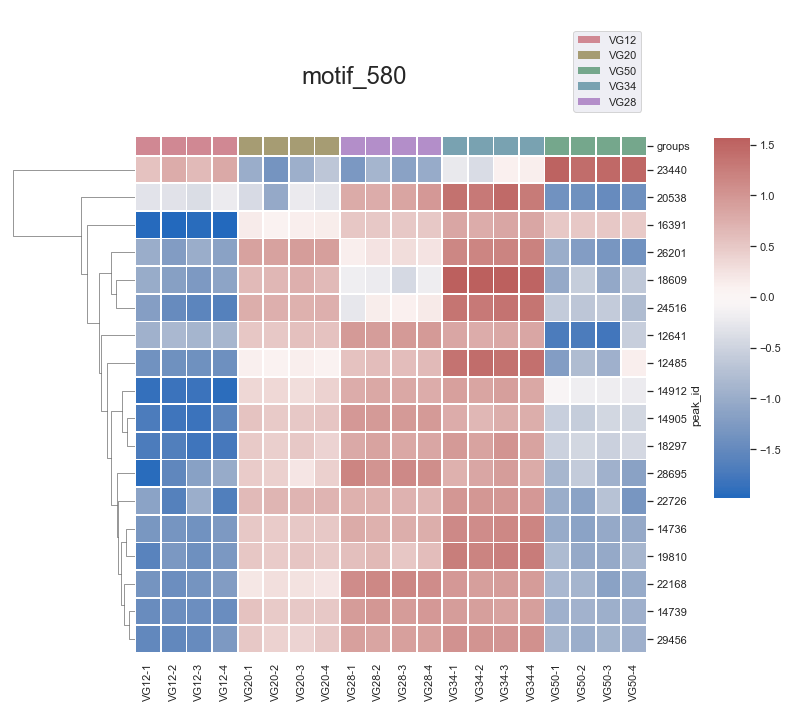

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
12485        NaN       328.2235        5.794     2464992.0          20   
12641        NaN       330.2018        2.458     5695001.0          20   
14736        NaN       358.1980        2.585     2297947.0          20   
14739        NaN       358.1984        2.861     2337438.0          20   
14905        NaN       360.2082        7.735      339788.0          20   
14912        NaN       360.2121        6.721      326329.0          20   
16391        NaN       380.2188       11.818      435425.0          20   
18297        NaN       408.2137       11.547      263462.0          20   
18609        NaN       413.2738        6.362      115946.0          20   
19810        NaN       431.2474        3.293      409235.0          20   
20538        NaN       443.2868       11.435      156458.0          20   
22168        NaN       475.2741        8.380       90217.0          20   
22726        NaN       487.3113       14.102       73980.0          20   
23440        NaN       502.3207        1.791      128490.0          20   
24516        NaN       527.3207       10.216      265362.0          20   
26201        NaN       570.2891       14.753       69740.0          20   
28695        NaN       653.3463        2.468       67479.0          20   
29456        NaN       685.4120       10.688      101014.0          20   

                                                                                                                                         link  
id                                                                                                                                             
12485   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=319&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12641   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=441&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
14736   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=441&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
14739   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=441&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
14905   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=643&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
14912   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=643&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
16391   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=441&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
18297   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=441&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
18609   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=386&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
19810   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=896&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
20538   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=126&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
22168  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1492&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
22726   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=752&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
23440  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=2046&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
24516  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1020&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
26201   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&com

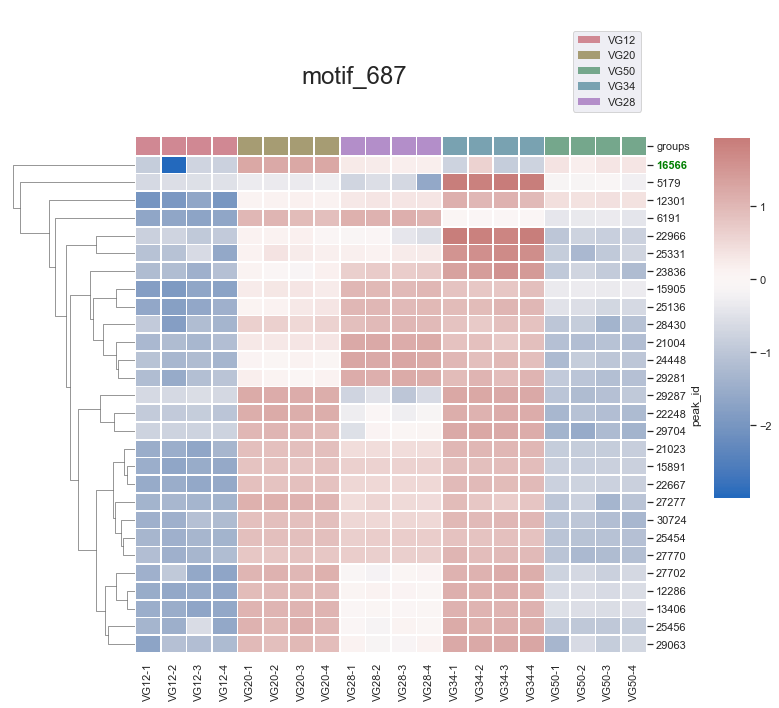

LibraryID  Precursor m/z  \
id                                                                    
5179                                             NaN       229.0992   
6191                                             NaN       245.0945   
12286                                            NaN       326.1720   
12301                                            NaN       326.2070   
13406                                            NaN       340.1871   
15891                                            NaN       374.1713   
15905                                            NaN       374.2247   
16566  Spectral Match to PyroGlu-Pro-Arg from NIST14       383.2034   
21004                                            NaN       453.1966   
21023                                            NaN       453.2716   
22248                                            NaN       477.2197   
22667                                            NaN       486.2542   
22966                                            NaN       492.2441   
23836                                            NaN       512.2696   
24448                                            NaN       526.2841   
25136                                            NaN       542.2818   
25331                                            NaN       547.2421   
25454                                            NaN       550.3218   
25456                                            NaN       550.3235   
27277                                            NaN       603.3003   
27702                                            NaN       616.2980   
27770                                            NaN       618.2903   
28430                                            NaN       642.3055   
29063                                            NaN       668.3582   
29281                                            NaN       679.2880   
29287                                            NaN       679.3657   
29704                                            NaN       696.3997   
30724                                            NaN       747.3370   

       RTConsensus  PrecursorInt  no_spectra  \
id                                             
5179         5.097     1689833.0          20   
6191         1.749     4214719.0          20   
12286        3.966     3791897.0          20   
12301        3.961      331767.0          20   
13406        9.028     5529322.0          20   
15891       10.924    14405805.0          20   
15905       10.884      589033.0          20   
16566        1.564      691722.0          20   
21004        1.959    17817479.0          20   
21023       13.814     1347951.0          20   
22248       11.226      447618.0          20   
22667        1.646     3931932.0          20   
22966        1.513      700315.0          20   
23836        2.200      208283.0          20   
24448        2.412      174772.0          20   
25136        2.242      298424.0          20   
25331        3.964       71626.0          20   
25454       14.464     1753817.0          20   
25456        8.953      143838.0          20   
27277       10.843      102981.0          19   
27702        9.179      111452.0          20   
27770       10.885      404267.0          20   
28430       10.930       61209.0          20   
29063        3.952       56479.0          20   
29281        2.085      150978.0          20   
29287        9.009      316456.0          20   
29704        8.979       39650.0          15   
30724       10.920     3431955.0          20   

                                                                                                                                         link  
id                                                                                                                                             
5179    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=976&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
6191    https://gnps.ucsd.edu/ProteoSAF

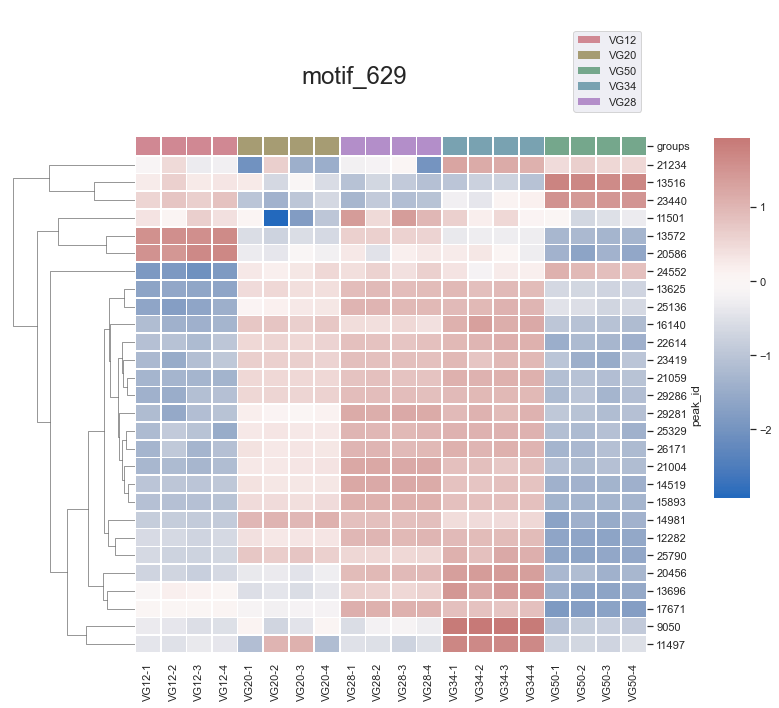

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
9050         NaN       285.2175       15.764       57256.0          20   
11497        NaN       316.1839        3.883      863046.0          20   
11501        NaN       316.1865        4.112      378749.0          20   
12282        NaN       326.1696        5.708      858516.0          20   
13516        NaN       342.0494        7.177       84343.0          20   
13572        NaN       342.2391        7.122     1414652.0          20   
13625        NaN       343.1978        1.809     1305665.0          20   
13696        NaN       344.1816        1.834     1495302.0          20   
14519        NaN       355.1604        1.763     5430035.0          20   
14981        NaN       361.1773       13.912      156092.0          20   
15893        NaN       374.1721       11.982      996609.0          20   
16140        NaN       377.1751        8.618      117122.0          20   
17671        NaN       399.2584       12.217      350928.0          20   
20456        NaN       442.2652        9.724      219523.0          20   
20586        NaN       444.2705        2.618       37932.0          20   
21004        NaN       453.1966        1.959    17817479.0          20   
21059        NaN       454.2294        5.209      456661.0          20   
21234        NaN       457.3073        2.336      216934.0          20   
22614        NaN       485.1866        2.201      361910.0          20   
23419        NaN       502.2295       11.034      569556.0          20   
23440        NaN       502.3207        1.791      128490.0          20   
24552        NaN       528.3012        2.501      190186.0          20   
25136        NaN       542.2818        2.242      298424.0          20   
25329        NaN       547.2386        2.071      172794.0          20   
25790        NaN       558.3473        2.449      166026.0          20   
26171        NaN       569.2885        1.769      337988.0          20   
29281        NaN       679.2880        2.085      150978.0          20   
29286        NaN       679.3655        9.996      263573.0          20   

                                                                                                                                         link  
id                                                                                                                                             
9050    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=951&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11497  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1705&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11501  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1705&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12282   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=208&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13516   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=233&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13572   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=233&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13625   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=182&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13696   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=441&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
14519   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=132&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
14981  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1443&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
15893   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=n

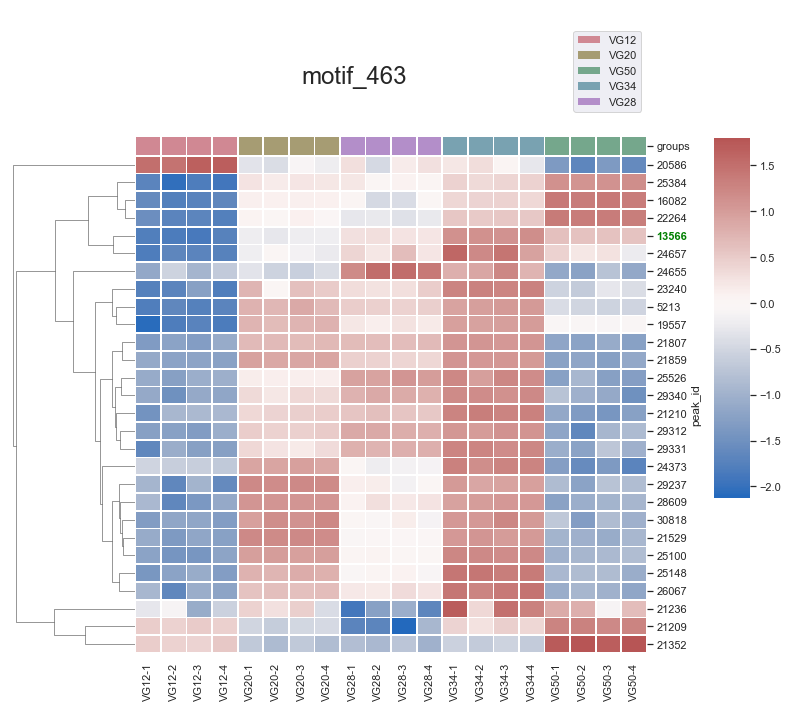

LibraryID  Precursor m/z  RTConsensus  \
id                                                                             
5213                                         NaN       229.1549        1.601   
13566  Spectral Match to Ile-Pro-Ile from NIST14       342.2374       10.005   
16082                                        NaN       376.2217       12.661   
19557                                        NaN       427.2909       10.664   
20586                                        NaN       444.2705        2.618   
21209                                        NaN       457.2167        2.458   
21210                                        NaN       457.2285        2.819   
21236                                        NaN       457.3082        2.435   
21352                                        NaN       459.3165        2.813   
21529                                        NaN       463.2528       13.533   
21807                                        NaN       469.2300       10.081   
21859                                        NaN       470.2370       10.151   
22264                                        NaN       477.2705       11.380   
23240                                        NaN       498.3280       12.589   
24373                                        NaN       524.2667       11.036   
24655                                        NaN       530.3495        2.821   
24657                                        NaN       530.3560        2.409   
25100                                        NaN       541.3350       12.130   
25148                                        NaN       542.3165       12.497   
25384                                        NaN       548.3043       12.965   
25526                                        NaN       552.3016        2.416   
26067                                        NaN       566.2822       10.894   
28609                                        NaN       649.3902       17.045   
29237                                        NaN       677.3474       11.040   
29312                                        NaN       680.3602        2.415   
29331                                        NaN       681.3480        2.777   
29340                                        NaN       681.4130       10.006   
30818                                        NaN       754.3373        8.953   

       PrecursorInt  no_spectra  \
id                                
5213      3424563.0          20   
13566     1168842.0          20   
16082      994116.0          20   
19557      129915.0          20   
20586       37932.0          20   
21209      483727.0          20   
21210     2489785.0          20   
21236      279925.0          20   
21352      292210.0          20   
21529      283841.0          20   
21807      668525.0          20   
21859      307528.0          20   
22264      288864.0          20   
23240       39943.0          20   
24373      105563.0          20   
24655      198401.0          20   
24657      922882.0          20   
25100     1991886.0          20   
25148      107770.0          20   
25384       42774.0          20   
25526      310400.0          20   
26067      115820.0          20   
28609       22638.0          20   
29237       57183.0          20   
29312      324416.0          20   
29331      116318.0          20   
29340       34594.0          20   
30818       28796.0          20   

                                                                                                                                         link  
id                                                                                                                                             
5213    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=326&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13566   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=319&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
16082   htt

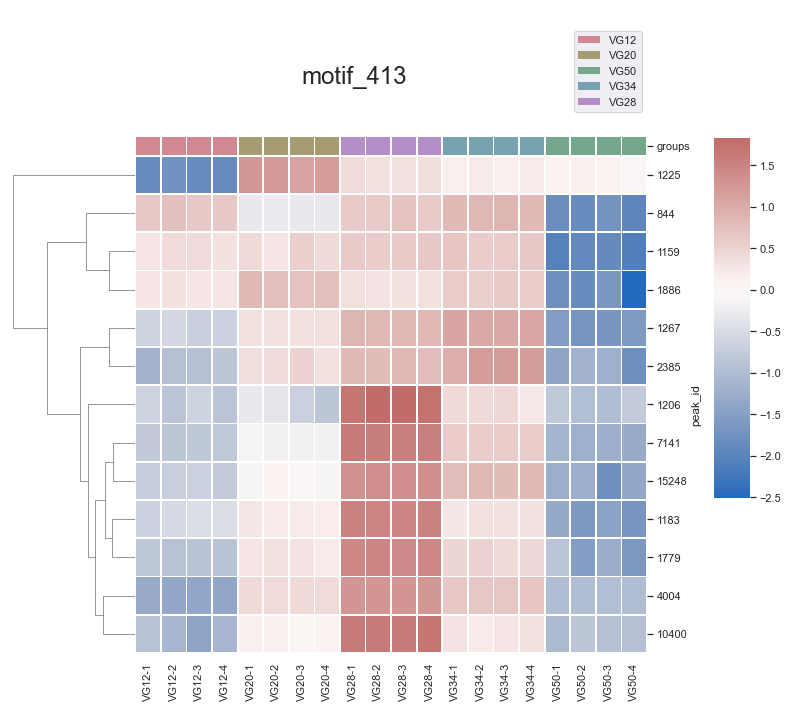

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
844          NaN       139.0869        2.272      271899.0          20   
1159         NaN       149.1069        1.379     3395528.0          20   
1183         NaN       150.0899        1.655     1065705.0          20   
1206         NaN       151.0833        3.938       67330.0          20   
1225         NaN       152.0697        7.755      120956.0          20   
1267         NaN       153.1019        3.046      807066.0          20   
1779         NaN       167.1174        4.385      167122.0          20   
1886         NaN       170.0813        2.100      377579.0          20   
2385         NaN       180.5613        4.827       46346.0          20   
4004         NaN       210.1125       19.400      752745.0          20   
7141         NaN       259.1440        9.548     1235825.0          20   
10400        NaN       303.1353        8.334      156907.0          20   
15248        NaN       365.1850       12.621      127746.0          20   

                                                                                                                                         link  
id                                                                                                                                             
844     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=359&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1159    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=161&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1183    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=161&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1206    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=359&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1225   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1222&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1267    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=359&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1779    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=359&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1886   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1600&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2385   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1045&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4004    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=404&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7141    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=404&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10400   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=404&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
15248   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=343&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

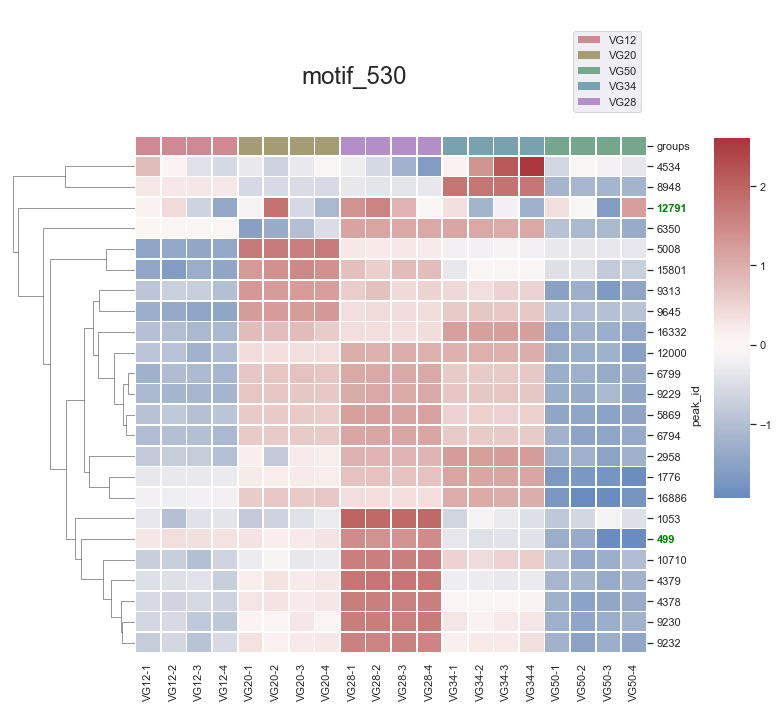

LibraryID  \
id                                                                
499                           6-Oxo-2-piperidinecarboxylic acid   
1053                                                        NaN   
1776                                                        NaN   
2958                                                        NaN   
4378                                                        NaN   
4379                                                        NaN   
4534                                                        NaN   
5008                                                        NaN   
5869                                                        NaN   
6350                                                        NaN   
6794                                                        NaN   
6799                                                        NaN   
8948                                                        NaN   
9229                                                        NaN   
9230                                                        NaN   
9232                                                        NaN   
9313                                                        NaN   
9645                                                        NaN   
10710                                                       NaN   
12000                                                       NaN   
12791  Spectral Match to 1-Hexadecanoyl-sn-glycerol from NIST14   
15801                                                       NaN   
16332                                                       NaN   
16886                                                       NaN   

       Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                            
499         126.0526        1.404      415634.0          20   
1053        146.0571        9.260       41287.0          20   
1776        167.1168        2.930     4105773.0          20   
2958        191.1152        3.478      274451.0          20   
4378        216.1004        7.386      274520.0          20   
4379        216.1005        8.543      147652.0          20   
4534        218.1376       21.542      165712.0          20   
5008        227.0806        5.409     4707667.0          20   
5869        240.1221        2.673      436134.0          20   
6350        247.1522       15.780       54933.0          20   
6794        254.1376        5.199      345796.0          20   
6799        254.1387        7.046      910076.0          20   
8948        284.1487        2.565     2892682.0          20   
9229        288.1232        9.315      457074.0          20   
9230        288.1234        9.874       56999.0          20   
9232        288.1242        9.748       56155.0          20   
9313        289.1317       16.164       38399.0          20   
9645        293.2093       19.077      361758.0          20   
10710       307.1269        7.822       47628.0          20   
12000       322.2719       16.144      134794.0          19   
12791       331.2839       34.010      612020.0          20   
15801       373.1240        5.787      157905.0          20   
16332       379.2981       15.971      168561.0          20   
16886       387.1819       21.461      369866.0          20   

                                                                                                                                         link  
id                                                                                                                                             
499      https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=13&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1053     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=91&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1776   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1619&ta

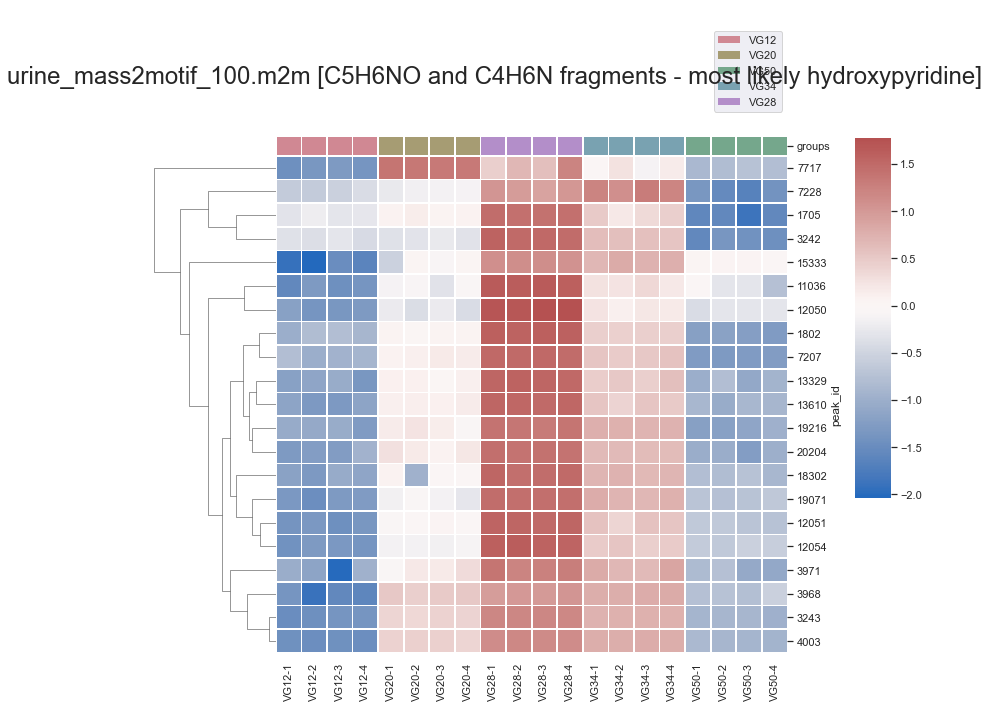

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
1705         NaN       166.0853        1.441      628171.0          20   
1802         NaN       168.0645        1.367     2419075.0          20   
3242         NaN       196.0966        1.497     1065127.0          20   
3243         NaN       196.0967        1.975     6667765.0          20   
3968         NaN       209.4508        3.732      241081.0          20   
3971         NaN       209.9783        3.735       19489.0          20   
4003         NaN       210.1125        3.281     6529453.0          20   
7207         NaN       260.0918        3.713      188250.0          20   
7228         NaN       260.1602        1.831     1792531.0          20   
7717         NaN       267.1459        2.713      274931.0          20   
11036        NaN       311.1586        3.444      227016.0          20   
12050        NaN       323.1950       10.555      178093.0          20   
12051        NaN       323.1955       11.376      217860.0          20   
12054        NaN       323.1970       11.909      167938.0          20   
13329        NaN       339.1549        3.660      271957.0          20   
13610        NaN       343.1628        9.764      179254.0          20   
15333        NaN       366.2020        5.041      155984.0          20   
18302        NaN       408.2445       13.622      113056.0          20   
19071        NaN       420.2479       13.048      115523.0          20   
19216        NaN       422.2609       15.371       82757.0          20   
20204        NaN       438.2226        5.173       57019.0          20   

                                                                                                                                        link  
id                                                                                                                                            
1705   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=202&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1802   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=202&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3242   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=202&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3243   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=202&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3968   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=202&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
3971   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=202&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4003   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=202&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7207    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=23&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7228    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=23&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7717   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=249&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11036  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=249&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12050  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=249&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12051  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=249&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12054  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=249&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13329  https://g

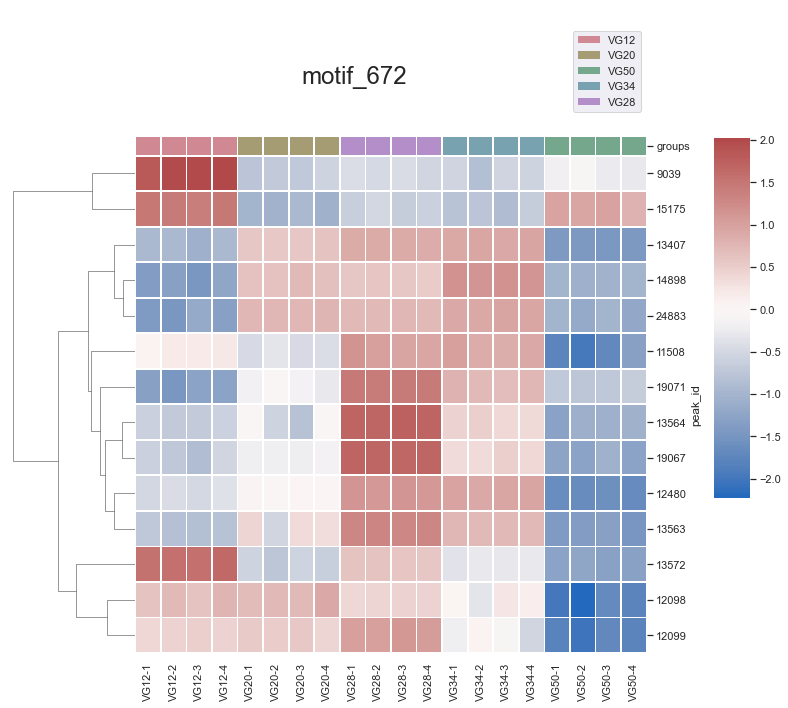

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
9039         NaN       285.1826        2.721      306785.0          20   
11508        NaN       316.1877        1.788     1830613.0          20   
12098        NaN       324.1318       10.690       40854.0          20   
12099        NaN       324.1338       12.704       67308.0          20   
12480        NaN       328.2226        5.311      914133.0          20   
13407        NaN       340.1879        9.998     4010046.0          20   
13563        NaN       342.2370       13.934      101383.0          20   
13564        NaN       342.2371       14.257      152568.0          20   
13572        NaN       342.2391        7.122     1414652.0          20   
14898        NaN       360.1923        8.911      672427.0          20   
15175        NaN       364.1864        4.389      806738.0          20   
19067        NaN       420.2450       12.826       75498.0          20   
19071        NaN       420.2479       13.048      115523.0          20   
24883        NaN       536.3094       13.313     1685758.0          20   

                                                                                                                                         link  
id                                                                                                                                             
9039   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1608&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11508   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=441&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12098    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=91&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12099  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1955&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12480   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=843&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13407    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=21&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13563  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1773&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13564  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1773&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13572   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=233&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
14898    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=16&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
15175   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=441&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
19067     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
19071     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
24883    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=14&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

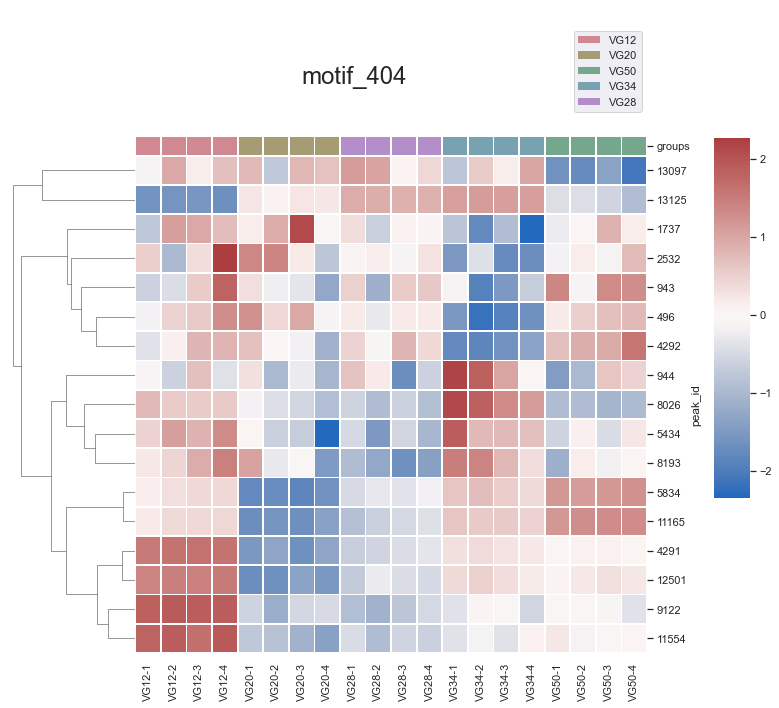

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
496          NaN       125.9852       40.103     2716511.0          20   
943          NaN       142.9759       40.144      174318.0          20   
944          NaN       142.9998       40.102      270078.0          20   
1737         NaN       167.0136       40.105      206270.0          20   
2532         NaN       184.0026       40.150       53956.0          20   
4291         NaN       214.9171        1.195      357303.0          20   
4292         NaN       214.9182       40.100     5227915.0          20   
5434         NaN       232.8909       40.097      885554.0          20   
5834         NaN       239.9666        1.195      636930.0          20   
8026         NaN       271.9169       40.143      106474.0          20   
8193         NaN       273.9175       40.096      437564.0          20   
9122         NaN       287.0405        1.202      104000.0          20   
11165        NaN       312.9207        1.192      264508.0          20   
11554        NaN       317.0362        1.204       18897.0          20   
12501        NaN       328.8999        1.196      136718.0          20   
13097        NaN       336.1219        7.868      185358.0          20   
13125        NaN       336.1923        8.885      319115.0          20   

                                                                                                                                         link  
id                                                                                                                                             
496      https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=97&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
943      https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=97&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
944      https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=97&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1737     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=97&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2532     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=97&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4291     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=15&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4292     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=15&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5434     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=15&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5834     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=15&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8026     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=15&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8193     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=15&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9122     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=15&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11165    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=15&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11554    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=15&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
12501    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=15&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13097    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=15&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
13125  h

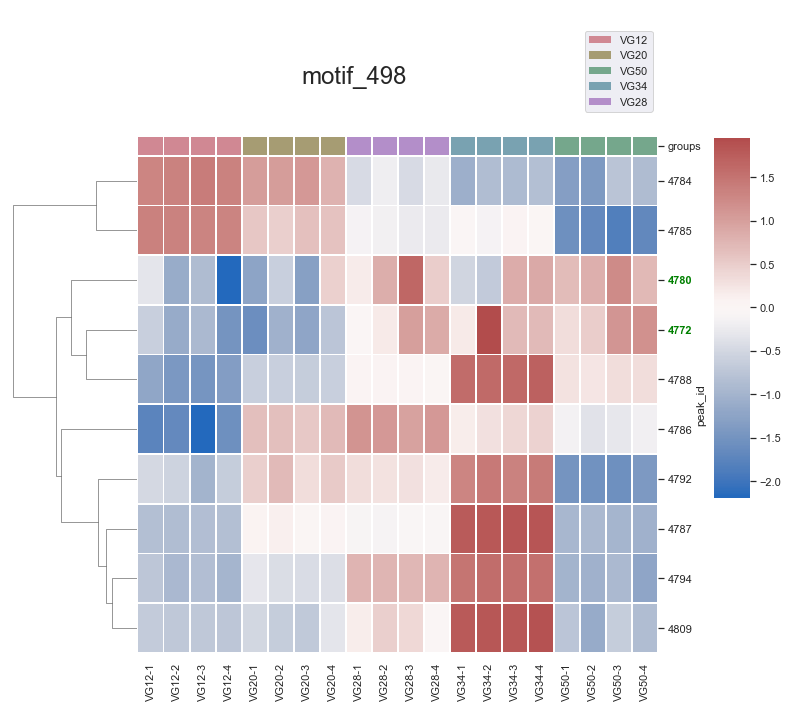

LibraryID  \
id                                                                  
4772  Spectral Match to Cyclotrisiloxane, hexamethyl- from NIST14   
4780  Spectral Match to Cyclotrisiloxane, hexamethyl- from NIST14   
4784                                                          NaN   
4785                                                          NaN   
4786                                                          NaN   
4787                                                          NaN   
4788                                                          NaN   
4792                                                          NaN   
4794                                                          NaN   
4809                                                          NaN   

      Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                           
4772       223.0633       31.118      379099.0          20   
4780       223.0649        4.185      439486.0          20   
4784       223.0826        2.122      319189.0          20   
4785       223.0836        1.778      297709.0          20   
4786       223.0933       11.545       91450.0          20   
4787       223.0950        7.450      146950.0          20   
4788       223.0951        9.751      107846.0          20   
4792       223.0971        8.558       96926.0          20   
4794       223.0978       12.802       77103.0          20   
4809       223.1664       15.464       31333.0          20   

                                                                                                                                        link  
id                                                                                                                                            
4772    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=12&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4780    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=12&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4784  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1717&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4785  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1717&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4786    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=12&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4787  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1920&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4788    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=12&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4792    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=12&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4794   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=567&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
4809    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=12&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

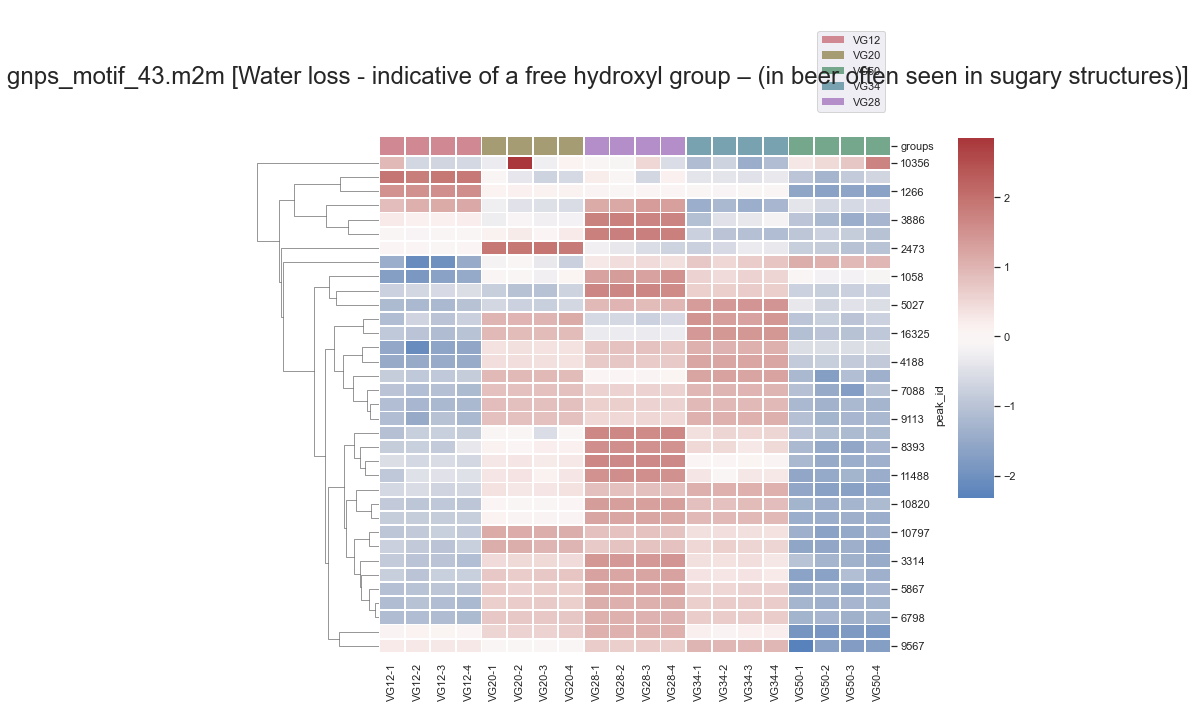

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
527          NaN       127.0896        1.919       41644.0          18   
1058         NaN       146.0595        2.608      126666.0          20   
1266         NaN       153.1016        2.070     1155125.0          20   
1267         NaN       153.1019        3.046      807066.0          20   
2450         NaN       182.0808        1.947      909428.0          20   
2473         NaN       182.1181        3.722      171779.0          20   
2736         NaN       187.0594        2.729      491015.0          20   
2959         NaN       191.1163        2.915      144931.0          20   
3314         NaN       197.1292        3.208      279244.0          20   
3410         NaN       199.0871        6.733     1263972.0          20   
3886         NaN       208.1333        2.882      113377.0          20   
4014         NaN       210.1479        7.139      158733.0          20   
4188         NaN       213.1023        9.431     3405398.0          20   
4378         NaN       216.1004        7.386      274520.0          20   
5027         NaN       227.1168       11.763      266971.0          20   
5867         NaN       240.1218        2.912      461426.0          20   
6796         NaN       254.1381        5.792      272806.0          20   
6798         NaN       254.1384        6.556      993327.0          20   
6845         NaN       255.1111       10.892      289434.0          20   
7087         NaN       258.2059        9.476     1534335.0          20   
7088         NaN       258.2062        9.945      324120.0          20   
8393         NaN       276.1359        8.641       71123.0          20   
9113         NaN       286.2374       14.436      290251.0          20   
9567         NaN       292.2241       17.682      391292.0          20   
10356        NaN       302.3043       28.437     2138864.0          20   
10797        NaN       308.1596        6.465       88378.0          20   
10800        NaN       308.1614       11.657       73708.0          20   
10820        NaN       308.2214       17.201       92126.0          20   
10821        NaN       308.2215       17.503     2488664.0          20   
11488        NaN       316.1548       13.502       43928.0          20   
11885        NaN       321.1456       11.328       62655.0          20   
13772        NaN       345.1442       10.268       46067.0          20   
15803        NaN       373.1265        4.312      123695.0          20   
16325        NaN       379.2945       22.730      624464.0          20   
16475        NaN       381.3115       24.283      286193.0          20   

                                                                                                                                         link  
id                                                                                                                                             
527    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1619&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1058     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=91&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1266   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1619&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
1267    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=359&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2450   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1652&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2473   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1652&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
2736     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=13&task=30a1f92e87a047b58

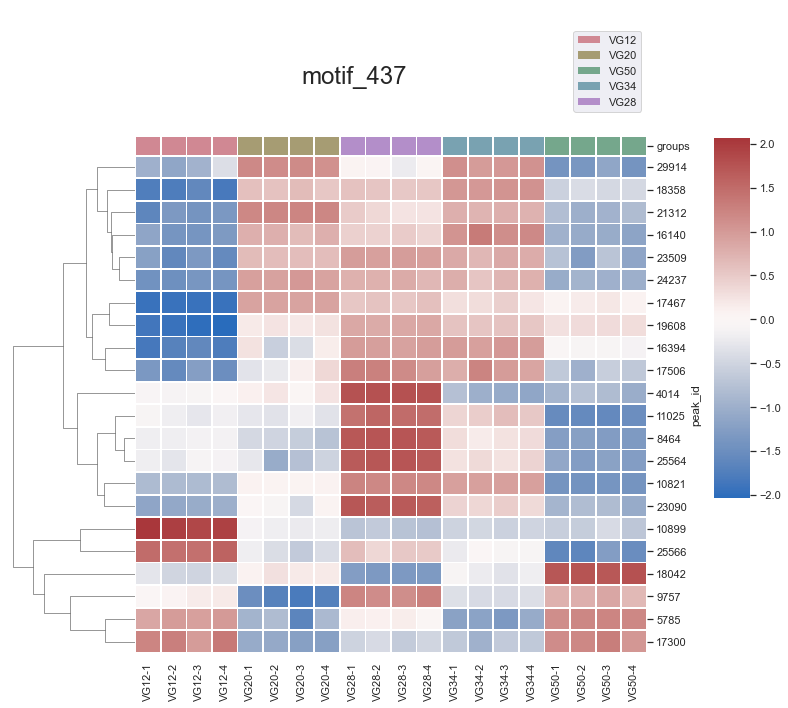

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
4014         NaN       210.1479        7.139      158733.0          20   
5785         NaN       239.1011        1.482     1348467.0          20   
8464         NaN       277.1547        6.705     1798337.0          20   
9757         NaN       295.1653        4.685      968413.0          20   
10821        NaN       308.2215       17.503     2488664.0          20   
10899        NaN       309.1818       10.986      484639.0          20   
11025        NaN       311.1384       11.515     1645568.0          20   
16140        NaN       377.1751        8.618      117122.0          20   
16394        NaN       380.2191        5.803      199225.0          20   
17300        NaN       393.1768        1.756      534903.0          20   
17467        NaN       395.7140        2.725       56218.0          16   
17506        NaN       396.2180        2.807      207007.0          20   
18042        NaN       404.1529        1.440     1034418.0          20   
18358        NaN       409.2068        5.325      238750.0          20   
19608        NaN       428.2177       11.841      131139.0          20   
21312        NaN       459.1846        2.934      143261.0          20   
23090        NaN       495.2539        6.749       35700.0          20   
23509        NaN       504.2426        3.650      149750.0          20   
24237        NaN       521.2376        3.413      623027.0          20   
25564        NaN       553.3008        6.731       34285.0          20   
25566        NaN       553.3027        9.098       92140.0          20   
29914        NaN       705.3464        8.549       40865.0          20   

                                                                                                                                         link  
id                                                                                                                                             
4014   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1187&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
5785    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=604&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
8464    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=181&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9757    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=604&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10821   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=936&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10899   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=604&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11025   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=181&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
16140  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1443&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
16394   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=922&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
17300  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1293&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
17467   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=537&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
17506  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1018&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
18042    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=34&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
18358  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displa

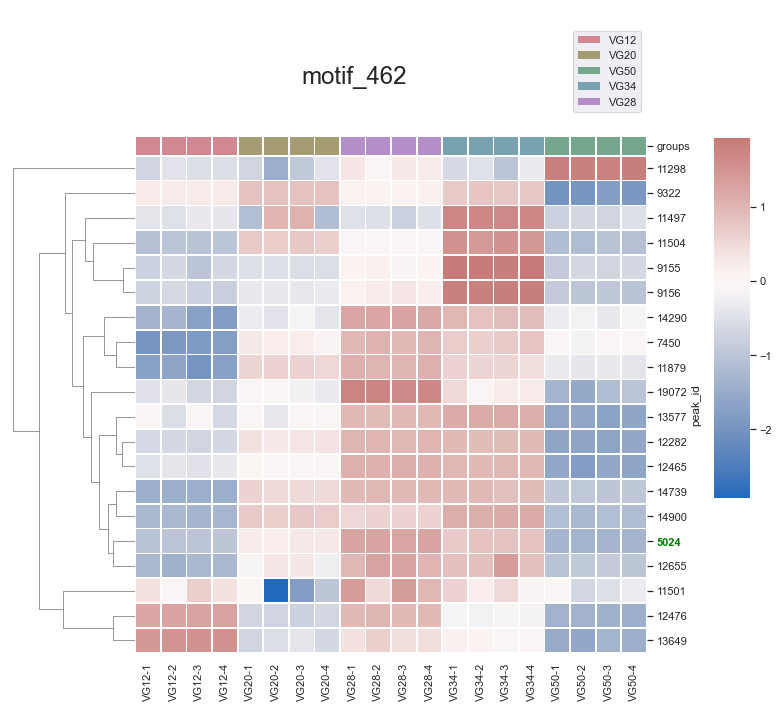

LibraryID  Precursor m/z  RTConsensus  \
id                                                                             
5024   Spectral Match to PyroGlu-Pro from NIST14       227.1017        1.958   
7450                                         NaN       263.1367        5.442   
9155                                         NaN       287.1383       21.796   
9156                                         NaN       287.1389       19.188   
9322                                         NaN       289.1528        7.916   
11298                                        NaN       314.1495       10.635   
11497                                        NaN       316.1839        3.883   
11501                                        NaN       316.1865        4.112   
11504                                        NaN       316.1870        3.984   
11879                                        NaN       321.1429        9.430   
12282                                        NaN       326.1696        5.708   
12465                                        NaN       328.2202        5.371   
12476                                        NaN       328.2224        4.053   
12655                                        NaN       330.2038        3.965   
13577                                        NaN       342.2398        8.254   
13649                                        NaN       343.2434        7.013   
14290                                        NaN       352.1298       19.200   
14739                                        NaN       358.1984        2.861   
14900                                        NaN       360.1925        8.772   
19072                                        NaN       420.2481       16.513   

       PrecursorInt  no_spectra  \
id                                
5024     13669771.0          20   
7450      1482139.0          20   
9155        30584.0          20   
9156        54564.0          20   
9322       522362.0          20   
11298       58543.0          20   
11497      863046.0          20   
11501      378749.0          20   
11504     1085855.0          20   
11879      126045.0          20   
12282      858516.0          20   
12465      882394.0          20   
12476     1578591.0          20   
12655      730240.0          20   
13577     1470857.0          20   
13649      286125.0          20   
14290       23285.0          20   
14739     2337438.0          20   
14900      689207.0          20   
19072       16316.0          20   

                                                                                                                                         link  
id                                                                                                                                             
5024    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=389&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
7450     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=75&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9155    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=787&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9156    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=787&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
9322     https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=90&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11298    https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=58&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11497  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1705&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11501  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1705&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
11504   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_di

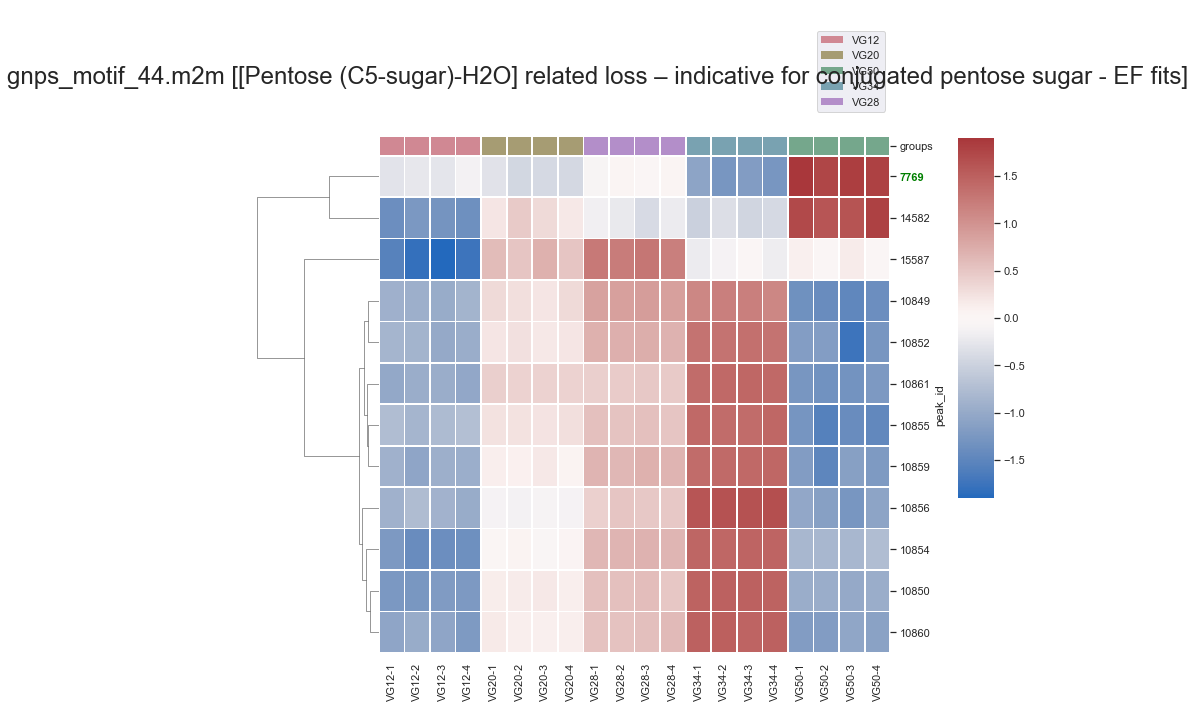

LibraryID  Precursor m/z  RTConsensus  PrecursorInt  no_spectra  \
id                                                                       
7769   Adenosine       268.1028        1.393     1784759.0          20   
10849        NaN       309.0956        8.790      359688.0          20   
10850        NaN       309.0956        9.413      275742.0          20   
10852        NaN       309.0956        7.441       76781.0          20   
10854        NaN       309.0960        7.658      153171.0          20   
10855        NaN       309.0960       11.121      816621.0          20   
10856        NaN       309.0962       14.337       72619.0          20   
10859        NaN       309.0967       12.963      165221.0          20   
10860        NaN       309.0969        8.224      260548.0          20   
10861        NaN       309.0978       12.621      730705.0          20   
14582        NaN       356.1202        1.800      853532.0          20   
15587        NaN       370.1346        2.773      191692.0          20   

                                                                                                                                        link  
id                                                                                                                                            
7769   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=883&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10849   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=13&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10850   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=13&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10852   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=13&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10854   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=13&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10855   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=13&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10856   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=13&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10859   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=13&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10860   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=13&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
10861   https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=13&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
14582  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=961&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true  
15587  https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=961&task=30a1f92e87a047b58ee8c0faf2b4734e&show=true

OSError: [Errno 22] Invalid argument: 'urine_mass2motif_272.m2m [Taurine related (+ 143.1177 fragment?)].pdf'

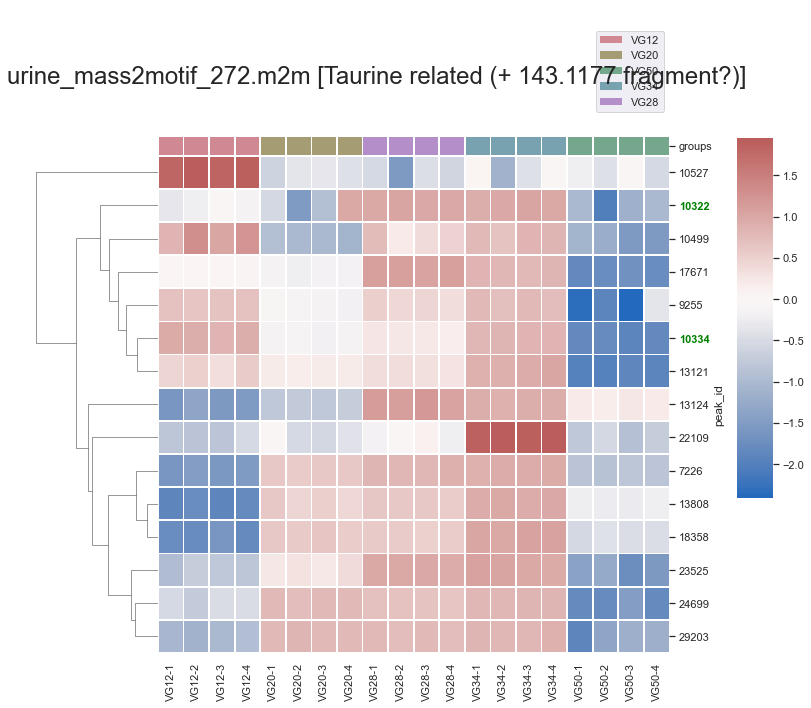

In [29]:
for idx, row in df.iterrows():
    members = gnps_ds.dataset_pathways_to_row_ids[idx]
    if len(members) < min_members:
        continue
        
    pw_name = row['pw_name']
    p_value = row[p_value_col]
                    
    # get group intensities
    group_intensities = intensities_df.loc[members][all_samples]    
    
    # get group info
    # print('%s p-value=%.4f' % (pw_name, p_value))
    data = []
    for member in members:
        member_info = entity_dict[member]
        unique_id = member_info['unique_id']
        library_id = member_info['LibraryID']
        gnps_linkout_network = member_info['GNPSLinkout_Network']
        no_spectra = member_info['number of spectra']
        rt = member_info['RT']
        mz = member_info['mass']    
        intensity = member_info['SumPeakIntensity']
        row = [unique_id, library_id, mz, rt, intensity, no_spectra, gnps_linkout_network]
        data.append(row)
    member_df = pd.DataFrame(data, columns=['id', 'LibraryID', 'Precursor m/z', 'RTConsensus', 'PrecursorInt', 'no_spectra', 'link']).set_index('id')    
    
    # Create a categorical palette to identify the networks
    used_groups = list(set(all_groups))
    group_pal = sns.husl_palette(len(used_groups), s=.45)
    group_lut = dict(zip(map(str, used_groups), group_pal))

    # Convert the palette to vectors that will be drawn on the side of the matrix
    group_colours = pd.Series(all_groups, index=group_intensities.columns).map(group_lut)    
    group_colours.name = 'groups'
    
    # plot heatmap
    g = sns.clustermap(group_intensities, center=0, cmap=cmap, col_colors=group_colours, 
                   col_cluster=False, linewidths=0.75, figsize=(10, 10), cbar_pos=(1.0, 0.3, 0.05, 0.5))

    title = pw_name
    if 'gnps_motif_54.m2m' in pw_name:
        title = 'Ferulic-acid-related Mass2Motif'
    plt.suptitle('%s' % (title), fontsize=24, y=0.9)

    # draw group legend
    for group in used_groups:
        g.ax_col_dendrogram.bar(0, 0, color=group_lut[group], label=group, linewidth=0)
    g.ax_col_dendrogram.legend(loc="right")
    
    # make the annotated peaks to have labels in bold
    annotated_df = member_df[member_df['LibraryID'].notnull()]
    annotated_peaks = annotated_df.index.values
    for label in g.ax_heatmap.get_yticklabels():
        if label.get_text() in annotated_peaks:
            label.set_weight("bold")
            label.set_color("green")   
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)        

    out_file = '%s.pdf' % pw_name
    plt.savefig(out_file, dpi=300)
    plt.show()
    
    out_file = '%s.csv' % pw_name
    display(member_df)
    member_df.drop('link', axis=1).round(4).to_csv(out_file, index=True)